## Predicting tectonic settings using basalt fingerprinting

Using the Seton et al. (2012) plate model and the EarthChem database to classify the tectonic setting of basalts

In [1]:
import pygplates as pgp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pickle as pkl
import time
#import GPMLTools
import random

#from collections import Counter
#from IPython.display import Image
from mpl_toolkits.basemap import Basemap, cm

% matplotlib inline

#### Load data

In [2]:
# Load EarthChem data
#geochem_data_file = '/Users/Mike/Projects/tectonic_classifications_data/EarthChem_reconstruction/NBQuery.txt'
geochem_data_file = '/Users/Mike/Projects/tectonic_classifications_data/EarthChem_full/AllofEarthChemQuery/AllofEarthChemQuery.txt'
#geochem_data_file = '/Users/Mike/Projects/tectonic_classifications_data/EarthChem_full/PetDBOnlyQuery/PetDBOnlyQuery.txt'
geochem_data = pd.read_csv(geochem_data_file, sep='\t', skipinitialspace=True)
chemdata = geochem_data.dropna(axis=1, how='all')


# Load plate model rotation files
# 250 - 0 Ma
rotation_file1 = '/Users/Mike/Projects/tectonic_classifications_data/Global_EB_250-0Ma_GK07_2015_v1.rot'
rotation_model_250_0 = pgp.RotationModel(rotation_file1)

# 410 - 251 Ma
rotation_file2 = '/Users/Mike/Projects/tectonic_classifications_data/Global_EB_410-250Ma_GK07_2015_v1.rot'
rotation_model_410_251 = pgp.RotationModel(rotation_file2)

# 540 - 411 Ma
rotation_file3 = '/Users/Mike/Projects/tectonic_classifications_data/Palaeozoic_SAfrica_Frame_2012.rot'
rotation_model_540_411 = pgp.RotationModel(rotation_file3)

# 1100 - 541 Ma
rotation_file4 = '/Users/Mike/Projects/tectonic_classifications_data/Merdith_2015/Rod-Gondw_intraplate.rot'
rotation_model_1100_541 = pgp.RotationModel(rotation_file4)


# Load polygons for assignment of plate ID for reconstructions for each time period
polyFile1 = '/Users/Mike/Projects/tectonic_classifications_data/Static_polygons_2014_v2/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2014_v2.gpmlz'
featureCollection = pgp.FeatureCollectionFileFormatRegistry()
polygons_410_0 = featureCollection.read(polyFile1)

polyFile2 = '/Users/Mike/Projects/tectonic_classifications_data/Palaeozoic_Plates_Simple.gpml'
featureCollection = pgp.FeatureCollectionFileFormatRegistry()
polygons_540_411 = featureCollection.read(polyFile2)

polyFile3 = '/Users/Mike/Projects/tectonic_classifications_data/Merdith_2015/Rod-Gondw_intraplate.gpml'
featureCollection = pgp.FeatureCollectionFileFormatRegistry()
polygons_1100_541 = featureCollection.read(polyFile3)



# Load first-order selection polygons
first_order_subduction = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_FIRST_ORDER/first_order_SUBDUCTION-ZONES.gpml'
first_order_mor = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_FIRST_ORDER/first_order_MID-OCEAN-RIDGES.gpml'
first_order_hotspots = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_FIRST_ORDER/first_order_HOTSPOTS.gpml'

first_subduction_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
first_subduction_polygons = first_subduction_featureCollection.read(first_order_subduction)

first_mor_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
first_mor_polygons = first_mor_featureCollection.read(first_order_mor)

first_hotspots_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
first_hotspots_polygons = first_hotspots_featureCollection.read(first_order_hotspots)


# Load second-order selection polygons
second_order_BAB = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_BAB.gpml'
second_order_arc_cont_aleutian = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_CONTINENTAL-ARCS-ALEUTIAN-STYLE.gpml'
second_order_arc_cont = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_CONTINENTAL-ARCS.gpml'
second_order_arc_intraoceanic = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_INTRAOCEANIC-ARCS.gpml'
second_order_hotspot_ridge = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_HOTSPOT-RIDGE-ZONES.gpml'
second_order_hotspot = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_HOTSPOTS.gpml'
second_order_mor = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_MID-OCEAN-RIDGES.gpml'
second_order_rift = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_RIFT-SYSTEMS.gpml'
second_order_lip = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_CONTINENTAL-LIPS.gpml'
second_order_bnr = '/Users/Mike/Projects/tectonic_classifications_data/Selection_polygons/20150709_SECOND_ORDER/second_order_BASIN-AND-RANGE.gpml'

second_BAB_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_BAB_polygons = second_BAB_featureCollection.read(second_order_BAB)

second_arc_cont_aleutian_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_arc_cont_aleutian_polygons = second_arc_cont_aleutian_featureCollection.read(second_order_arc_cont_aleutian)

second_arc_cont_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_arc_cont_polygons = second_arc_cont_featureCollection.read(second_order_arc_cont)

second_arc_intra_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_arc_intra_polygons = second_arc_intra_featureCollection.read(second_order_arc_intraoceanic)

second_hotspot_ridge_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_hotspot_ridge_polygons = second_hotspot_ridge_featureCollection.read(second_order_hotspot_ridge)

second_hotspot_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_hotspot_polygons = second_hotspot_featureCollection.read(second_order_hotspot)

second_mor_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_mor_polygons = second_mor_featureCollection.read(second_order_mor)

second_rift_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_rift_polygons = second_rift_featureCollection.read(second_order_rift)

second_lip_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_lip_polygons = second_lip_featureCollection.read(second_order_lip)

second_bnr_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
second_bnr_polygons = second_bnr_featureCollection.read(second_order_bnr)

gpml_path = '/Users/Mike/Projects/tectonic_classifications_data/resolved_topologies/GPML/'

/Users/Mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (1,4,13,14,15,16,17,18,19,21,23,25,27,29,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,57,59,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,99,100,101,102,103,104,105,107,109,111,113,114,115,116,117,118,119,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,141,143,145,147,149,151,153,155,157,159,161,163,164,165,166,167,168,169,170,171,172,173,175,176,177,178,179,183,185,186,187,189,190,191,193,194,195,199,201,203,204,205,206,207,209,211,212,213,215,217,219,220,221,222,223,224,225,226,227,229,231,233,235,238,239,243,244,245,247,249,251,253,255,257,258,259,261,263,265,267,269,270,271,272,273,275,277,279,280,281,283,284,285,289,291,292,293,294,295,298,299,301,302,303,305,306,307,309,311,314,315) have mixed types. Specify dtype option on import or set low_memory

#### Code profiling

In [3]:
time_list = []

def start_clock():
    
    time_list.append(time.time())
    

def stop_clock():
    
    time_list.append(time.time() - time_list[-1])
    
    h = np.modf(time_list[-1] / 60 / 60)
    ms = np.modf(h[0] * 60)
    print 'Process took', int(h[1]), 'hour(s),', int(ms[1]), 'minute(s),', round(ms[0] * 60, 4), 'second(s)'

#### Pre-process EarthChem data

Only need to do this once as it saves a pickle file at the end that can be loaded.
If already done, skip to next cell

In [4]:
# start_clock()

# # Remove "UNITS" columns and remove white space -- Check units are consistent
# dropcols = []
# stripcols = []
# unitrecord = {}

# for i, cname in enumerate(chemdata.columns):
#     if cname.find("UNIT") > 0:

#         # Filter NaN values
#         nanmask = ~pd.isnull(chemdata[cname])

#         # Change "less than" values (no-detect) to 0
#         dcol = chemdata.columns[i-1]
#         ltmask = [str(row).find('<') >= 0 for row in chemdata[dcol]]
#         chemdata[dcol][np.array(ltmask)] = 0

#         # Now convert all units to floats
#         chemdata[dcol] = chemdata[dcol].astype(float)

#         # Get the set of units
#         setunits = set(chemdata[cname][nanmask].values)

#         # If the units are insconsistent in a column, deal with it or drop it
#         if len(setunits) > 1:

#             if (setunits == set(['WT%', 'PPM'])):
#                 wgtmask = chemdata[cname] == "WT%"
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['wt%', 'ppm', 'WT%'])):
#                 wgtmask = chemdata[cname] == "WT%"
#                 wwgtmask = chemdata[cname] == "wt%"
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['wt%', 'ppm'])):
#                 wgtmask = chemdata[cname] == "wt%"
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPM', 'ppm'])):
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'PPM'])):
#                 ppmmask = chemdata[cname] == "PPM"
#                 chemdata[dcol][ppmmask] *= 1e3
#                 unitrecord.update({dcol: 'PPB'})
                
#             elif (setunits == set(['ppb', 'ppm'])):
#                 ppmmask = chemdata[cname] == "ppm"
#                 chemdata[dcol][ppmmask] *= 1e3
#                 unitrecord.update({dcol: 'PPB'})
                
#             elif (setunits == set(['WT%', 'PPB', 'PPM'])):
#                 ppmmask = chemdata[cname] == "PPM"
#                 wgtmask = chemdata[cname] == "WT%"
#                 chemdata[dcol][ppmmask] *= 1e3
#                 chemdata[dcol][wgtmask] *= 1e7
#                 unitrecord.update({dcol: 'PPB'})
                
#             elif (setunits == set(['RATIO', 'wt%', 'ppm', 'WT%'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'wt%'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] == np.float('nan')
#                 unitrecord.update({dcol: 'WT%'})
                
#             elif (setunits == set(['RATIO', 'PPM', 'ppm'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['mol/g', 'wt%', 'ppm', 'WT%'])):
#                 molmask = chemdata[cname] == 'mol/g'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][molmask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'ppn', 'ppm', 'PPM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'ppm'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'wt%', 'ppm', 'PPM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'wt%', 'ppm', 'WT%'])):
#                 ppbmask = chemdata[cname] == 'ppb'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ng/g', 'RATIO', 'dpm/g', 'ppm', 'PPM'])):
#                 nggmask = chemdata[cname] == 'ng/g'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 dpmgmask = chemdata[cname] == 'dpm/g'
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][dpmgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'ng/g', 'ppm', 'ppt'])):
#                 ppbmask = chemdata[cname] == 'ppb'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 pptmask = chemdata[cname] == 'ppt'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][pptmask] /= 1e6
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['nanomol', 'umol', 'RATIO', 'cc', 'ccstp', 'ppm', 'wt%', 'mol', 'ccstp/g', 'WT%'])):
#                 nanmolmask = chemdata[cname] == 'nanmol'
#                 umolmask = chemdata[cname] == 'umol'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 ccmask = chemdata[cname] == 'cc'
#                 ccstpmask = chemdata[cname] == 'ccstp'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 molmask = chemdata[cname] == 'mol'
#                 ccstpgmask = chemdata[cname] == 'ccstp/g'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][nanmolmask] = np.float('nan')
#                 chemdata[dcol][umolmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][ccmask] = np.float('nan')
#                 chemdata[dcol][ccstpmask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][molmask] = np.float('nan')
#                 chemdata[dcol][ccstpgmask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'ng/g', 'RATIO', 'ppm'])):
#                 ppbmask = chemdata[cname] == 'ppb'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ng/g', 'RATIO', 'PPM', 'ppm'])):
#                 nggmask = chemdata[cname] == 'ng/g'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MICROMOL PER KG', 'WT%', 'ppm', 'wt%'])):
#                 mmpgmask = chemdata[cname] == 'MICROMOL PER KG'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['WT%', 'wt%'])):
#                 unitrecord.update({dcol: 'WT%'})
                
#             elif (setunits == set(['ppm', 'WT%', 'PPM', 'wt%'])):
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'RATIO', 'WT%', 'PPM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'WT%', 'PPM'])):
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['DPM/G', 'PPM'])):
#                 dpmgmask = chemdata[cname] == 'DPM/G'
#                 chemdata[dcol][dpmgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'WT%', 'wt%'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'WT%'})
                
#             elif (setunits == set(['nanomol', 'PPM', 'RATIO', 'cc', 'ccstp', 'ppm', 'umol', 'WT%', 'mol', 'ccstp/g', 'wt%'])):
#                 nanmolmask = chemdata[cname] == 'nanmol'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 ccmask = chemdata[cname] == 'cc'
#                 ccstpmask = chemdata[cname] == 'ccstp'
#                 umolmask = chemdata[cname] == 'umol'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 molmask = chemdata[cname] == 'mol'
#                 ccstpgmask = chemdata[cname] == 'ccstp/g'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 chemdata[dcol][nanmolmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][ccmask] = np.float('nan')
#                 chemdata[dcol][ccstpmask] = np.float('nan')
#                 chemdata[dcol][umolmask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][molmask] = np.float('nan')
#                 chemdata[dcol][ccstpgmask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MILLIGRAM PER GRAM', 'ppm', 'WT%', 'PPM', 'wt%'])):
#                 mpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 chemdata[dcol][mpgmask] *= 1e3
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MILLIGRAM PER GRAM', 'MICROMOLE PER GRAM', 'ppm', 'wt%', 'PPM', 'WT%'])):
#                 mpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][mpgmask] *= 1e3
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MILLIGRAM PER KILOGRAM', 'RATIO', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'MILLIGRAM PER GRAM', 'MICROMOLE PER GRAM', 'ppm', 'WT%', 'PPM', 'wt%'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 mgpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 chemdata[dcol][ppbmask] /= 1e4 
#                 chemdata[dcol][mgpgmask] *= 1e3
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['RATIO', 'MILLIGRAM PER KILOGRAM', 'ppm', 'WT%', 'PPM', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['wt%', 'MILLIGRAM PER GRAM', 'ppm', 'MILLIGRAM PER KILOGRAM', 'PPM', 'WT%', 
#                                    'MICROMOLE PER GRAM', 'MICROMOL PER KG', 'MICROGRAM PER GRAM', 'GRAM PER KILOGRAM'])):
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 mgpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 mmpkgmask = chemdata[cname] == 'MICROMOLE PER KG'
#                 gpkgmask = chemdata[cname] == 'GRAM PER KILOGRAM'
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][mgpgmask] *= 1e3
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 chemdata[dcol][mmpkgmask] = np.float('nan')
#                 chemdata[dcol][gpkgmask] *= 1e3
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['wt%', 'RATIO', 'MILLIGRAM PER KILOGRAM', 'ppm', 'WT%', 'PPM', 'MICROGRAM PER GRAM'])):
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'RATIO', 'WT%', 'PPM', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'RATIO', 'MILLIGRAM PER KILOGRAM', 'PPM', 'WT%', 'MICROMOLE PER GRAM', 
#                                    'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'RATIO', 'MILLIGRAM PER KILOGRAM', 'PPM', 'MICROMOL', 'WT%', 
#                                    'MICROMOLE PER GRAM', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 mmmask = chemdata[cname] == 'MICROMOL'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][mmmask] = np.float('nan')
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'ppm', 'WT%', 'PPM', 'ppb'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][pppbmask] /= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'ppm', 'WT%', 'PPM'])):
#                 pppbmask = chemdata[cname] == 'ppb'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'ng/g', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 pppbmask = chemdata[cname] == 'ppb'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppb', 'MILLIGRAM PER GRAM', 'ppm', 'WT%', 'PPM', 'wt%'])):
#                 pppbmask = chemdata[cname] == 'ppb'
#                 mgpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 wwgtmask = chemdata[cname] == 'wt%'
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][mgpgmask] *= 1e3
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][wwgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
            
#             elif (setunits == set(['RATIO', 'NANOMOLE PER GRAM', 'MILLIGRAM PER KILOGRAM', 'ppm', 'PPM', 
#                                    'dpm/g', 'ng/g', 'MICROGRAM PER GRAM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 nmpgmask = chemdata[cname] == 'NANOMOLE PER GRAM'
#                 dpmgmask = chemdata[cname] == 'dpm/g'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][nmpgmask] = np.float('nan')
#                 chemdata[dcol][dpmgmask] = np.float('nan')
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'PPG', 'ppb', 'ppt', 'ppm', 'PPM', 'PPT', 'ng/g', 'MICROGRAM PER GRAM'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 ppgmask = chemdata[cname] == 'PPG'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 ppptmask = chemdata[cname] == 'ppt'
#                 pptmask = chemdata[cname] == 'PPT'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][ppgmask] = np.float('nan')
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][ppptmask] /= 1e6
#                 chemdata[dcol][pptmask] /= 1e6
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MILLIGRAM PER GRAM', 'ppm', 'WT%', 'PPM', 'MICROMOLE PER GRAM'])):
#                 mgpgmask = chemdata[cname] == 'MILLIGRAM PER GRAM'
#                 wgtmask = chemdata[cname] == 'WT%'
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 chemdata[dcol][mgpgmask] *= 1e3
#                 chemdata[dcol][wgtmask] *= 1e4
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MILLIGRAM PER KILOGRAM', 'RATIO', 'ppm', 'PPM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'RATIO', 'ppb', 'ppm', 'PPM', 'ng/g'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ng/g', 'ppm', 'PPM'])):
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'RATIO', 'ppb', 'ppm', 'PPM', 'PPG', 'ng/g'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 ppgmask = chemdata[cname] == 'PPG'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][ppgmask] = np.float('nan')
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'WT%', 'PPM', 'MICROGRAM PER GRAM'])):
#                 wgtmask = chemdata[cname] == 'WT%'
#                 chemdata[dcol][wgtmask] *= 1e4
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'PPG', 'ppb', 'ppm', 'PPM', 'PPT', 'ng/g'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 ppgmask = chemdata[cname] == 'PPG'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 pptmask = chemdata[cname] == 'PPT'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][ppgmask] = np.float('nan')
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][pptmask] /= 1e6
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ng/g', 'RATIO', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 nggmask = chemdata[cname] == 'ng/g'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MICROMOL', 'RATIO', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 mmmask = chemdata[cname] == 'MICROMOL'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][mmmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MICROMOL', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 mmmask = chemdata[cname] == 'MICROMOL'
#                 chemdata[dcol][mmmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'PPG', 'ppb', 'ppt', 'ppm', 'PPM', 'PPT', 'ng/g'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 ppgmask = chemdata[cname] == 'PPG'
#                 pppbmask = chemdata[cname] == 'ppb'
#                 ppptmask = chemdata[cname] == 'ppt'
#                 pptmask = chemdata[cname] == 'PPT'
#                 nggmask = chemdata[cname] == 'ng/g'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][ppgmask] = np.float('nan')
#                 chemdata[dcol][pppbmask] /= 1e4
#                 chemdata[dcol][ppptmask] /= 1e6
#                 chemdata[dcol][pptmask] /= 1e6
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['MICROMOLE PER GRAM', 'ppm', 'PPM', 'MICROGRAM PER GRAM'])):
#                 mmpgmask = chemdata[cname] == 'MICROMOLE PER GRAM'
#                 chemdata[dcol][mmpgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ppm', 'RATIO', 'DPM/G', 'PPM'])):
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 dpmgmask = chemdata[cname] == 'DPM/G'
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 chemdata[dcol][dpmgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['PPB', 'NG/G', 'DPM/G', 'PPM'])):
#                 ppbmask = chemdata[cname] == 'PPB'
#                 nggmask = chemdata[cname] == 'NG/G'
#                 dpmgmask = chemdata[cname] == 'DPM/G'
#                 chemdata[dcol][ppbmask] /= 1e4
#                 chemdata[dcol][nggmask] = np.float('nan')
#                 chemdata[dcol][dpmgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['dpm', 'RATIO', 'ppm'])):
#                 dpmmask = chemdata[cname] == 'dpm'
#                 ratiomask = chemdata[cname] == 'RATIO'
#                 chemdata[dcol][dpmmask] = np.float('nan')
#                 chemdata[dcol][ratiomask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['ATOMS PER GRAM', 'atoms/g', 'PPM'])):
#                 apgmask = chemdata[cname] = 'ATOMS PER GRAM'
#                 aapgmask = chemdata[cname] = 'atoms/g'
#                 chemdata[dcol][apgmask] = np.float('nan')
#                 chemdata[dcol][aapgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'PPM'})
                
#             elif (setunits == set(['wt%', 'WT%', 'cps/g'])):
#                 cpsgmask = chemdata[cname] = 'cps/g'
#                 chemdata[dcol][cpsgmask] = np.float('nan')
#                 unitrecord.update({dcol: 'WT%'})
            
                
                
#             else:
#                 vals = nanmask.sum()
#                 print "Multiple units, {}, in {} cannot be converted, " \
#                       "dropping {} values!".format(setunits, cname, vals)
#                 dropcols.append(dcol)
#                 stripcols.pop()
                
#         else:
#             unitrecord.update({dcol: setunits.pop()})

#         # Add column name to drop list
#         dropcols.append(cname)
#         continue

#     stripcols.append(chemdata.columns[i].strip())

# chemdata = chemdata.drop(dropcols, 1)
# chemdata.columns = stripcols
# print chemdata.shape

# # Save processed data to pickle file
# chemdata.to_pickle('chemdata.pkl')

# stop_clock()

#### Load pre-processed chemdata file

In [5]:
chemdata = pd.read_pickle('chemdata.pkl')

In [6]:
# List all column headings from database - these are the data types for chem_data_vector
print len(chemdata.columns.values)
chemdata.columns.values

152


array(['SAMPLE ID', 'IGSN', 'SOURCE', 'REFERENCE', 'CRUISE ID', 'LATITUDE',
       'LONGITUDE', 'LOC PREC', 'MIN AGE', 'AGE', 'MAX AGE', 'MATERIAL',
       'TYPE', 'COMPOSITION', 'ROCK NAME', 'MINERAL', 'SIO2', 'TIO2',
       'AL2O3', 'FE2O3', 'FE2O3T', 'FEO', 'FEOT', 'RA228_RA226', 'MGO',
       'CAO', 'U238', 'NA2O', 'K2O', 'P2O5', 'MNO', 'LOI', 'H2O_PLUS',
       'H2O_MINUS', 'H2O', 'CR2O3', 'NIO', 'LA', 'CACO3', 'CE', 'PR', 'ND',
       'SM', 'EU', 'GD', 'TB', 'DY', 'HO', 'ER', 'TM', 'YB', 'LU', 'LI',
       'BE', 'B', 'C', 'CO2', 'F', 'CL', 'TH230', 'K', 'CA', 'MG', 'SC',
       'TI', 'V', 'FE', 'CR', 'MN', 'CO', 'NI', 'ZN', 'CU', 'ZR', 'GA',
       'GER', 'RA226', 'PA231', 'TH232', 'U234_U238', 'U234_U238_ACTIVITY',
       'TH230_TH232', 'TH232_TH230', 'TH232_U238', 'U235_PB204',
       'TH232_PB204', 'PO210_TH230', 'U238_PB204', 'BA', 'W', 'AR37_AR39',
       'AU', 'XE129_XE132', 'LU176_HF177', 'HG', 'OS186_OS188',
       'PB206_PB208', 'TA', 'PB210_U238', 'SB', 'SR87_SR86', 'SE

#### Remove any data that does not have an associated age

In [7]:
# # Process ages ------------------------------------------------------------------------

# # Remove samples without ages
# chemdata = chemdata[~np.isnan(chemdata['AGE'].values)]

# # Adjust samples with infeasible ages
# chemdata['AGE'] = np.abs(chemdata['AGE'])
# iagemask = chemdata['AGE'].values > 5.0e3
# chemdata['AGE'][iagemask] /= 1.0e6

# # Make sure the min and max ages are also adjusted if they exist
# chemdata['MIN AGE'][iagemask & ~pd.isnull(chemdata['MIN AGE'])] /= 1.0e6
# chemdata['MAX AGE'][iagemask & ~pd.isnull(chemdata['MAX AGE'])] /= 1.0e6

# chemdata.shape

#### Plot global data function

In [8]:
def plot_global_data(lon, lat, title, vmin, vmax, markersize=None, age=None, presentTime=True, plates=None, 
                     subductionZones=None, MORBs=None, hotspots=None, plates_younger=None, plates_older=None,
                     subductionZones_younger=None, subductionZones_older=None, MORBs_younger=None, MORBs_older=None):
    
    fig = plt.figure(figsize=(20,16),dpi=150)

    pmap = Basemap(projection='robin', lat_0=0, lon_0=0, resolution='l')
    
    if presentTime == True:
        
        pmap.warpimage('/Users/Mike/PhD/Map_resources/DNSC08GRA_greyscale_.jpg', scale=0.5, alpha=0.5)
        pmap.drawcoastlines(color='grey', zorder=1)
        
    if plates:
        
        pmap.readshapefile(plates, 'Plate Polygons', drawbounds=True, zorder=1, linewidth=1, color='lightgray')
        
    if subductionZones:
        
        pmap.readshapefile(subductionZones, 'Subduction Zones', drawbounds=True, zorder=1, linewidth=2, color='red')
        
    if MORBs:
        
        pmap.readshapefile(MORBs, 'Mid-Ocean Ridges', drawbounds=True, zorder=1, linewidth=2, color='green')
        
        
    if plates_younger:
        
        pmap.readshapefile(plates_younger, 'Plate Polygons_younger', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='lightgray')
        
    if plates_older:
        
        pmap.readshapefile(plates_older, 'Plate Polygons_older', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='lightgray')
        
    if subductionZones_younger:
        
        pmap.readshapefile(subductionZones_younger, 'Subduction Zones_younger', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='red')
        
    if subductionZones_older:
        
        pmap.readshapefile(subductionZones_older, 'Subduction Zones_older', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='red')
        
    if MORBs_younger:
        
        pmap.readshapefile(MORBs_younger, 'Mid-Ocean Ridges_younger', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='green')
        
    if MORBs_older:
        
        pmap.readshapefile(MORBs_older, 'Mid-Ocean Ridges_older', drawbounds=True, zorder=1, linewidth=0.4, 
                           color='green')
        

    if markersize:
        
        markersize = markersize
        
    else:
        
        markersize = 10
        
         
    if age:
        
        age = age
        
    else:
        
        age = 'k'
    
        
    pmap.drawmapboundary(fill_color='white')
    pmap.drawmeridians(np.arange(0, 360, 30))
    pmap.drawparallels(np.arange(-90, 90, 30))

    xh, yh = pmap(lon, lat)
    l1 = pmap.scatter(xh, yh, marker='o', s=markersize, c=age, edgecolor='none', vmin=vmin, vmax=vmax)
    
    
    if hotspots:
        
        hotspot_info = pmap.readshapefile(hotspots, 'Hotspots', drawbounds=True, zorder=1, linewidth=2, color='orange')
        
        for point in pmap.Hotspots:
       
            pmap.plot(point[0], point[1], marker='o', c='orange', markersize=5)
            

    
        
    
    #if age != 'k':
        
        #pmap.colorbar(l1, location='bottom', pad="5%")
    
    plt.title(title, y=1.02)
    plt.legend()
    plt.show()

#### Plot complete basalt dataset (0 - 4500 Ma) over present day plate polygons, mid-ocean ridges, and subduction zones as per Seton et al. (2012)

/Users/Mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


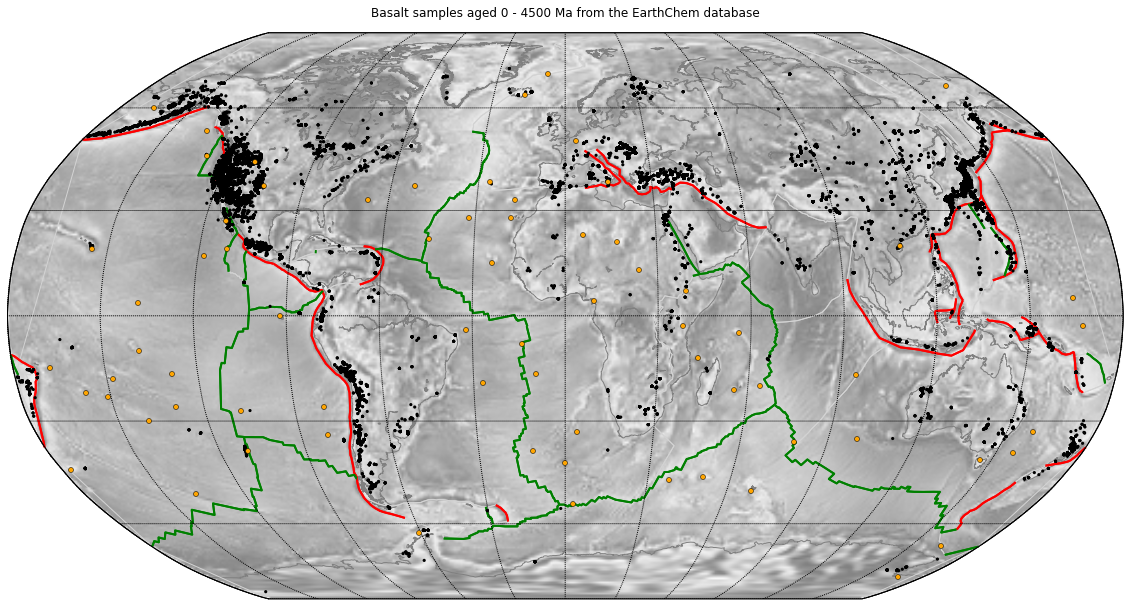

Filtered data contains 33487 points.
 


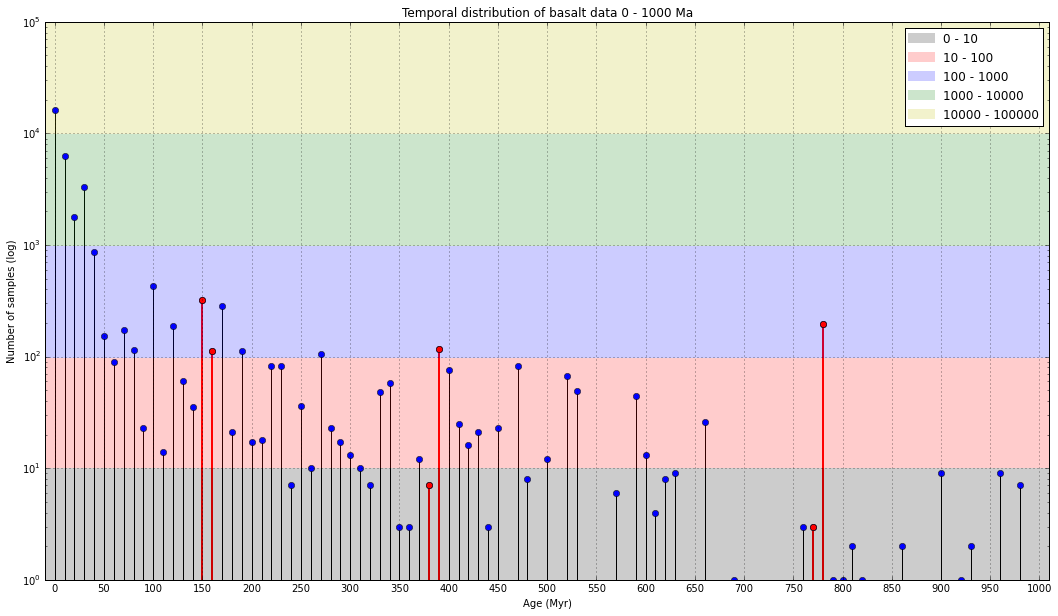

In [9]:
gpml_path = '/Users/Mike/Projects/tectonic_classifications_data/resolved_topologies_0-25Ma/gplates_export/'
hotspot_path = '/Users/Mike/Projects/tectonic_classifications_data/JW_HotspotCatalogue_20140605/'

lat = []
lon = []
age = []

for i in xrange(0, len(chemdata)):
        
    # Filter data by rock name
    if chemdata['ROCK NAME'][i] == "ANDESITE":
    
        # Filter by source
        if chemdata['SOURCE'][i] == "PETDB":
            
            if chemdata['MIN AGE'][i] >= 0 and chemdata['MAX AGE'][i] <= 4500:
        
                lat.append(chemdata['LATITUDE'][i])
                lon.append(chemdata['LONGITUDE'][i])
                age.append(0)
                
            elif np.isnan(chemdata['MIN AGE'][i]) == True and np.isnan(chemdata['MAX AGE'][i]) == True:
            
                lat.append(chemdata['LATITUDE'][i])
                lon.append(chemdata['LONGITUDE'][i])
                age.append(0)
                
                     
        else:

            # Filter data by age window
            if chemdata['AGE'][i] >= 0 and chemdata['AGE'][i] <= 4500:

                lat.append(chemdata['LATITUDE'][i])
                lon.append(chemdata['LONGITUDE'][i])
                age.append(chemdata['AGE'][i])
            
            
plot_global_data(lon, lat, 'Basalt samples aged 0 - 4500 Ma from the EarthChem database', 0, 1, 
                 None, None, True, 
                 gpml_path + 'topology_platepolygons_0_00Ma', 
                 gpml_path + 'topology_subduction_boundaries_0_00Ma',
                 gpml_path + 'topology_mid_ocean_ridges_0_00Ma',
                 hotspot_path + 'JW_HotspotCatalogue_20140605')

print "Filtered data contains", str(len(lon)), "points."
print " "


# Calculate data temporal distribution
age_dist = np.histogram(age, 380)
age_range = np.arange(0, 3800, 10)

fig = plt.figure(figsize=(18,10),dpi=150)

# selected case study snapshots
snapshots = [770, 780, 380, 390, 150, 160]

# Plot vertical lines
for i in xrange(0, len(age_range)):
    
    if i == snapshots[0] / 10 or i == snapshots[1] / 10 or i == snapshots[2] / 10 or i == snapshots[3] / 10 or \
       i == snapshots[4] / 10 or i == snapshots[5] / 10:
        
        plt.plot([age_range[i], age_range[i]], [age_dist[0][i], 1], 'o-', linewidth=2, markersize=0, color='r')
        
    else:
        
        plt.plot([age_range[i], age_range[i]], [age_dist[0][i], 1], 'o-', linewidth=1, markersize=0, color='k')
  
# Plot colour bars
plt.plot([-10, 1010], [3., 3.], 'o-', linewidth=118, markersize=0, color='k', alpha=0.2)
plt.plot([-10, 1010], [31., 31.], 'o-', linewidth=110, markersize=0, color='r', alpha=0.2)
plt.plot([-10, 1010], [310., 310.], 'o-', linewidth=112, markersize=0, color='b', alpha=0.2)
plt.plot([-10, 1010], [3100., 3100.], 'o-', linewidth=112, markersize=0, color='g', alpha=0.2)
plt.plot([-10, 1010], [31300., 31300.], 'o-', linewidth=112, markersize=0, color='y', alpha=0.2)

# Plot colour bars off-screen to get labels
plt.plot([-100, -50], [3., 3.], 'o-', linewidth=10, markersize=0, color='k', alpha=0.2, label='0 - 10')
plt.plot([-100, -50], [31., 31.], 'o-', linewidth=10, markersize=0, color='r', alpha=0.2, label='10 - 100')
plt.plot([-100, -50], [310., 310.], 'o-', linewidth=10, markersize=0, color='b', alpha=0.2, label='100 - 1000')
plt.plot([-100, -50], [3100., 3100.], 'o-', linewidth=10, markersize=0, color='g', alpha=0.2, label='1000 - 10000')
plt.plot([-100, -50], [31300., 31300.], 'o-', linewidth=10, markersize=0, color='y', alpha=0.2, label='10000 - 100000')

# Plot blue dots
plt.plot(age_range, age_dist[0], marker='o', linestyle='None')

for i in xrange(0, len(snapshots)):
    
    plt.plot(snapshots[i], age_dist[0][snapshots[i] / 10], marker='o', linestyle='None', color='r')
    


plt.semilogy()
plt.grid()
plt.xticks(np.arange(0, 4000, 50))
plt.xlim(-10, 1010)

plt.title('Temporal distribution of basalt data 0 - 1000 Ma')
plt.xlabel('Age (Myr)')
plt.ylabel('Number of samples (log)')

plt.legend()
plt.show()

#### Create vector for each data point within training set (0 - 5 Ma) containing all available geochemical data

In [12]:
# Create vector for chemdata
start_clock()

vector_length = len(chemdata.columns.values)
chem_data_vector = []

# Function to find any data point that contains zero measurement data (all nan)
def empty(items):
    
    return all(np.isnan(x) for x in items)


# Loop through EarthChem data and extract Basalts aged 0 - 5 Ma
for i in xrange(0, len(chemdata)):
    
    # Filter data by rock name
    if chemdata['ROCK NAME'][i] == "BASALT":
        
        # Filter by source (PetDB has special requirements)
        if chemdata['SOURCE'][i] == "PETDB": 
            
            # Check if sample has age and add to vector if within range
            if chemdata['MIN AGE'][i] >= 0 and chemdata['MAX AGE'][i] <= 5:
                
                chem_data_vector.append([0] * vector_length)

                # Add all chem data to data point vector
                for j in xrange(0, vector_length):

                    chem_data_vector[-1][j] = chemdata[chemdata.columns.values[j]][i]

                # Check to make sure actual chem data exists for data point (not metadata: labels etc)
                tmp_data = []
                for k in xrange(16, vector_length, 1):

                    tmp_data.append(chem_data_vector[-1][k])

                # If no chem data found, remove data point from dataset
                if empty(tmp_data):

                    del chem_data_vector[-1]
                    
        
            # Check if sample ages are nan. If True we assume age = 0 and add them to set (mainly MORB data) 
            elif np.isnan(chemdata['MIN AGE'][i]) == True and np.isnan(chemdata['MAX AGE'][i]) == True:
                
                chem_data_vector.append([0] * vector_length)

                # Add all chem data to data point vector
                for j in xrange(0, vector_length):

                    chem_data_vector[-1][j] = chemdata[chemdata.columns.values[j]][i]

                # Check to make sure actual chem data exists for data point (not metadata: labels etc)
                tmp_data = []
                for k in xrange(16, vector_length, 1):

                    tmp_data.append(chem_data_vector[-1][k])

                # If no chem data found, remove data point from dataset
                if empty(tmp_data):

                    del chem_data_vector[-1]
         
                    
        # Else for all other data filter by age
        else:
            
            # Filter data by age window
            if chemdata['AGE'][i] >= 0 and chemdata['AGE'][i] <= 5:

                chem_data_vector.append([0] * vector_length)

                # Add all chem data to data point vector
                for j in xrange(0, vector_length):

                    chem_data_vector[-1][j] = chemdata[chemdata.columns.values[j]][i]

                # Check to make sure actual chem data exists for data point (not metadata: labels etc)
                tmp_data = []
                for k in xrange(16, vector_length, 1):

                    tmp_data.append(chem_data_vector[-1][k])

                # If no chem data found, remove data point from dataset
                if empty(tmp_data):

                    del chem_data_vector[-1]
                    
print "Processed data contains", str(len(chem_data_vector)), "valid points."
stop_clock()

Processed data contains 67295 valid points.
Process took 0 hour(s), 1 minute(s), 32.1703 second(s)


#### Create vector for special LIP case for each data point within 60 - 260 Ma

In [13]:
# Create vector for chemdata
start_clock()

vector_length = len(chemdata.columns.values)
chem_data_vector_lip = []

# Function to find any data point that contains zero measurement data (all nan)
def empty(items):
    
    return all(np.isnan(x) for x in items)


# Loop through EarthChem data and extract Basalts aged 60 - 260 Ma
for i in xrange(0, len(chemdata)):
    
    # Filter data by rock name
    if chemdata['ROCK NAME'][i] == "BASALT":
        
        # Filter data by age window
        if chemdata['AGE'][i] >= 60 and chemdata['AGE'][i] <= 260:

            chem_data_vector_lip.append([0] * vector_length)

            # Add all chem data to data point vector
            for j in xrange(0, vector_length):

                chem_data_vector_lip[-1][j] = chemdata[chemdata.columns.values[j]][i]

            # Check to make sure actual chem data exists for data point (not metadata: labels etc)
            tmp_data = []
            for k in xrange(16, vector_length, 1):

                tmp_data.append(chem_data_vector_lip[-1][k])

            # If no chem data found, remove data point from dataset
            if empty(tmp_data):

                del chem_data_vector_lip[-1]
                    
print "Processed data contains", str(len(chem_data_vector_lip)), "valid points."
stop_clock()

Processed data contains 6873 valid points.
Process took 0 hour(s), 0 minute(s), 15.4802 second(s)


#### Assign tectonic setting label to each data point within the model training set based on its geographical correlation with the Seton et al. (2012) model

Method assigns tectonic setting labels to data points aged between 0 - 5 Ma that are found within first and second order tectonic setting polygon sets.


**First order classifications:**

* Mid-ocean Ridge
* Subduction
* Hotspots


**Second order clasifications:**

* Intraoceanic Arc
* Continental Arc
* Arc Aleutian style
* Basin and Range
* Back Arc Basin
* Mid-Ocean Ridge
* Rift
* Hotspot
* Hotspot-ridge Zone
* Large Igneous Province

#### Use polygon sets to locate and label data points for 0 - 5 Ma

In [14]:
start_clock()

polygon_sets = [first_mor_polygons, first_subduction_polygons, first_hotspots_polygons,
                second_mor_polygons, second_arc_intra_polygons, second_arc_cont_polygons, second_arc_cont_aleutian_polygons,
                second_BAB_polygons, second_rift_polygons, second_hotspot_polygons, second_hotspot_ridge_polygons,
                second_bnr_polygons]

labels = ['f-MOR', 'f-Subduction', 'f-Hotspot', 's-MOR', 's-Arc-Intraoceanic', 's-Arc-Continental', 
          's-Arc-Continental-Aleutian', 's-BAB', 's-Rift', 's-Hotspot', 's-Hotspot-Ridge', 's-Basin-Range', 's-LIP']


chem_data_vector_labelled = []
 
for i in xrange(0, len(chem_data_vector)):

    inputlatLon = pgp.LatLonPoint(chem_data_vector[i][5], chem_data_vector[i][6])
    latLonPoint = pgp.convert_lat_lon_point_to_point_on_sphere(inputlatLon)
    
    tectonic_setting = []
    
    for j in xrange(0, len(polygon_sets)):
        
        polygon_set = polygon_sets[j]
        
        for feature in polygon_set:
        
            for geometry in feature.get_geometries():

                polygon = pgp.PolygonOnSphere(geometry)
                isPoly = polygon.is_point_in_polygon(latLonPoint)
                
                if isPoly == True:

                    tectonic_setting.append(labels[j])
                    break

                else:

                    continue
                        
    
    if len(tectonic_setting) > 0:
        
        chem_data_vector_labelled.append(chem_data_vector[i])
        tmp_len = len(chem_data_vector_labelled)
        chem_data_vector_labelled[tmp_len - 1].append(tectonic_setting)
        
                              
print "Located and labelled", len(chem_data_vector_labelled), "data points within selection polygons."
stop_clock()

Located and labelled 40609 data points within selection polygons.
Process took 0 hour(s), 3 minute(s), 8.8641 second(s)


#### Use polygon set to locate and label special case LIP data set 60 - 260 Ma

In [15]:
start_clock()

chem_data_vector_lip_labelled = []

for i in xrange(0, len(chem_data_vector_lip)):
    
    try:
        inputlatLon = pgp.LatLonPoint(chem_data_vector_lip[i][5], chem_data_vector_lip[i][6])
        latLonPoint = pgp.convert_lat_lon_point_to_point_on_sphere(inputlatLon)
    except:
        continue
    
    tectonic_setting = []
    
    polygon_set = second_lip_polygons

    for feature in polygon_set:

        for geometry in feature.get_geometries():

            polygon = pgp.PolygonOnSphere(geometry)
            isPoly = polygon.is_point_in_polygon(latLonPoint)

            if isPoly == True:

                tectonic_setting.append('s-LIP')
                break

            else:

                continue
                        
    
    if len(tectonic_setting) > 0:
        
        chem_data_vector_lip_labelled.append(chem_data_vector_lip[i])
        tmp_len = len(chem_data_vector_lip_labelled)
        chem_data_vector_lip_labelled[tmp_len - 1].append(tectonic_setting)
        
                              
print "Located and labelled", len(chem_data_vector_lip_labelled), "data points within LIP selection polygons."
stop_clock()

Located and labelled 1062 data points within LIP selection polygons.
Process took 0 hour(s), 0 minute(s), 0.7502 second(s)


#### Plot labelled data points

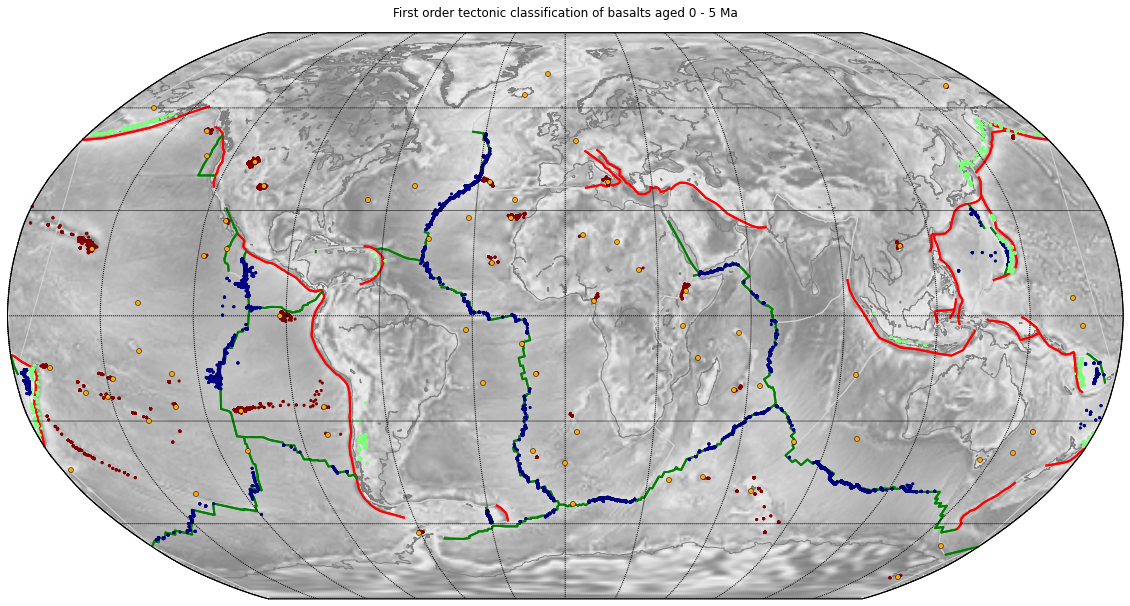

 
Blue:         MORB -              18213 identified data points
Green:        Subduction -        1858 identified data points
Red:          Hotspot -           10164 identified data points
 
 


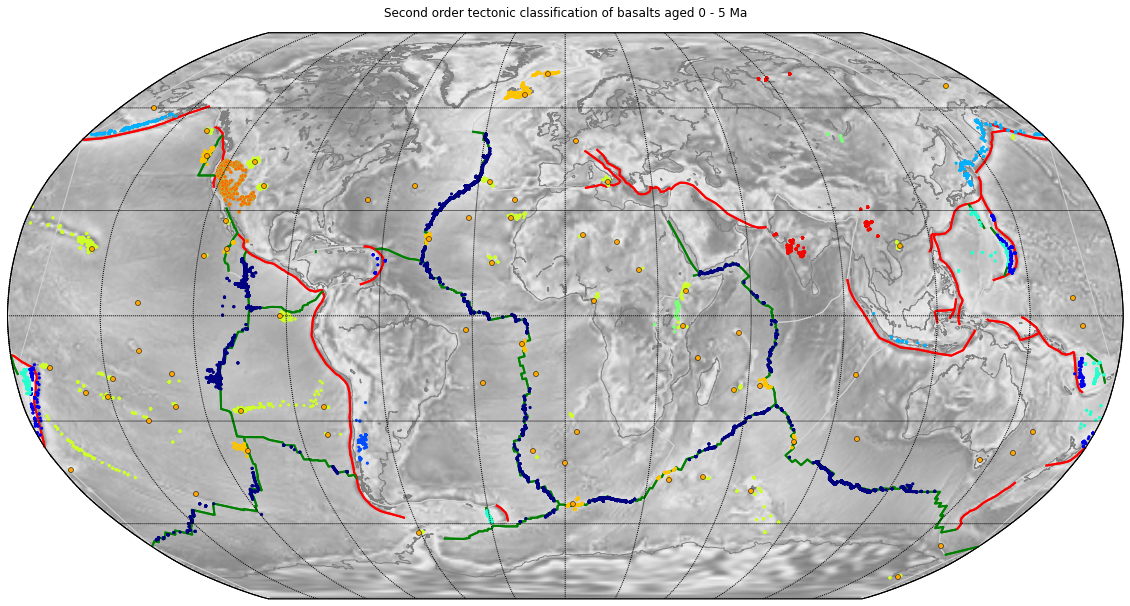

 
Dark Blue:      Mid-Ocean Ridge -                     16338 identified data points
Blue:           Arc Intraoceanic -                    637 identified data points
Mid Blue:       Arc Continental -                     176 identified data points
Light Blue:     Arc Continental (Aleutian Style) -    1045 identified data points
Aqua:           Back Arc Basin -                      1875 identified data points
Light green:    Rifting -                             6312 identified data points
Yellow:         Hotspot -                             10199 identified data points
Mustard:        Hotspot-Ridge -                       4027 identified data points
Orange:         Basin and Range -                     6144 identified data points
Red:            Large Igneous Provice -               1062 identified data points
 


In [16]:
lon = []
lat = []
label = []

f_mor_len = 0
f_sub_len = 0
f_hs_len = 0


# Plot first-order polygon classifications 
for i in xrange(0, len(chem_data_vector_labelled)):
    
    if 'f-MOR' in chem_data_vector_labelled[i][-1]:
        
        label.append(0)
        f_mor_len = f_mor_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
    
    if 'f-Subduction' in chem_data_vector_labelled[i][-1]:
        
        label.append(1)
        f_sub_len = f_sub_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 'f-Hotspot' in chem_data_vector_labelled[i][-1]:
        
        label.append(2)
        f_hs_len = f_hs_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])


plot_global_data(lon, lat, 'First order tectonic classification of basalts aged 0 - 5 Ma', 0, 2, None, label, True,
                 gpml_path + 'topology_platepolygons_0_00Ma', 
                 gpml_path + 'topology_subduction_boundaries_0_00Ma',
                 gpml_path + 'topology_mid_ocean_ridges_0_00Ma',
                 hotspot_path + 'JW_HotspotCatalogue_20140605')

print " "
print "Blue:         MORB -             ", f_mor_len, 'identified data points'
print "Green:        Subduction -       ", f_sub_len, 'identified data points'
print "Red:          Hotspot -          ", f_hs_len, 'identified data points'
print " "
print " "


# Plot second-order polygon classifications
lon = []
lat = []
label = []

s_mor_len = 0
s_ao_len = 0
s_ac_len = 0
s_aca_len = 0
s_bab_len = 0
s_rift_len = 0
s_hs_len = 0
s_hsr_len = 0
s_bnr_len = 0
s_lip_len = 0

for i in xrange(0, len(chem_data_vector_labelled)):
    
    if 's-MOR' in chem_data_vector_labelled[i][-1]:
        
        label.append(0)
        s_mor_len = s_mor_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Arc-Intraoceanic' in chem_data_vector_labelled[i][-1]:
        
        label.append(1)
        s_ao_len = s_ao_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Arc-Continental' in chem_data_vector_labelled[i][-1]:
        
        label.append(2)
        s_ac_len = s_ac_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Arc-Continental-Aleutian' in chem_data_vector_labelled[i][-1]:
        
        label.append(3)
        s_aca_len = s_aca_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-BAB' in chem_data_vector_labelled[i][-1]:
        
        label.append(4)
        s_bab_len = s_bab_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Rift' in chem_data_vector_labelled[i][-1]:
        
        label.append(5)
        s_rift_len = s_rift_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
    
    if 's-Hotspot' in chem_data_vector_labelled[i][-1]:
        
        label.append(6)
        s_hs_len = s_hs_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Hotspot-Ridge' in chem_data_vector_labelled[i][-1]:
        
        label.append(7)
        s_hsr_len = s_hsr_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        
    if 's-Basin-Range' in chem_data_vector_labelled[i][-1]:
        
        label.append(8)
        s_bnr_len = s_bnr_len + 1
        
        lon.append(chem_data_vector_labelled[i][6])
        lat.append(chem_data_vector_labelled[i][5])
        

# Plot LIPs
for i in xrange(0, len(chem_data_vector_lip_labelled)):
    
    if 's-LIP' in chem_data_vector_lip_labelled[i][-1]:
        
        label.append(9)
        s_lip_len = s_lip_len + 1
        
        lon.append(chem_data_vector_lip_labelled[i][6])
        lat.append(chem_data_vector_lip_labelled[i][5])
        

        
# def plot_global_data(lon, lat, title, vmin, vmax, markersize=None, age=None, presentTime=True, plates=None, 
                     # subductionZones=None, MORBs=None, hotspots=None, plates_younger=None, plates_older=None,
                     # subductionZones_younger=None, subductionZones_older=None, MORBs_younger=None, MORBs_older=None):


plot_global_data(lon, lat, 'Second order tectonic classification of basalts aged 0 - 5 Ma', 0, 10, None, label, True,
                 gpml_path + 'topology_platepolygons_0_00Ma', 
                 gpml_path + 'topology_subduction_boundaries_0_00Ma',
                 gpml_path + 'topology_mid_ocean_ridges_0_00Ma',
                 hotspot_path + 'JW_HotspotCatalogue_20140605')

print " "
print "Dark Blue:      Mid-Ocean Ridge -                    ", s_mor_len, 'identified data points'
print "Blue:           Arc Intraoceanic -                   ", s_ao_len, 'identified data points'
print "Mid Blue:       Arc Continental -                    ", s_ac_len, 'identified data points'
print "Light Blue:     Arc Continental (Aleutian Style) -   ", s_aca_len, 'identified data points'
print "Aqua:           Back Arc Basin -                     ", s_bab_len, 'identified data points'
print "Light green:    Rifting -                            ", s_rift_len, 'identified data points'
print "Yellow:         Hotspot -                            ", s_hs_len, 'identified data points'
print "Mustard:        Hotspot-Ridge -                      ", s_hsr_len, 'identified data points'
print "Orange:         Basin and Range -                    ", s_bnr_len, 'identified data points' 
print "Red:            Large Igneous Provice -              ", s_lip_len, 'identified data points'
print " "


#### Normalise training datasets (0 - 5 Ma, and 60 - 260 Ma) to generate tectonic setting geochemical signature models

Normalising data measurements using feature scaling

*NB. Instead of using actual max and min values, I am scaling between the 5th and 95th percentile of the dataset to prevent extreme results skewing normalisation.

\begin{equation}
zi = \frac{xi - min(x)}{max(x) - min(x)}
\end{equation}


In [17]:
start_clock()

# Gather all measurement data into vectors to perform normalisation
len_data = len(chem_data_vector_labelled[0]) - 17

pre_normalised_data = []
pre_normalised_data_lip = []

pre_normalised_f_mor = []
pre_normalised_f_subduction = []
pre_normalised_f_hotspot = []

pre_normalised_s_mor = []
pre_normalised_s_arc_intraoceanic = []
pre_normalised_s_arc_continental = []
pre_normalised_s_arc_continental_aleutian = []
pre_normalised_s_bab = []
pre_normalised_s_rift = []
pre_normalised_s_hotspot = []
pre_normalised_s_hotspot_ridge = []
pre_normalised_s_basin_range = []
pre_normalised_s_lip = []


for i in xrange(0, len_data):
    
    pre_normalised_data.append([])
    pre_normalised_data_lip.append([])
    
    pre_normalised_f_mor.append([])
    pre_normalised_f_subduction.append([])
    pre_normalised_f_hotspot.append([])

    pre_normalised_s_mor.append([])
    pre_normalised_s_arc_intraoceanic.append([])
    pre_normalised_s_arc_continental.append([])
    pre_normalised_s_arc_continental_aleutian.append([])
    pre_normalised_s_bab.append([])
    pre_normalised_s_rift.append([])
    pre_normalised_s_hotspot.append([])
    pre_normalised_s_hotspot_ridge.append([])
    pre_normalised_s_basin_range.append([])
    pre_normalised_s_lip.append([])
    
    
for i in xrange(0, len(chem_data_vector_labelled)):
    
    for j in xrange(16, len(chem_data_vector_labelled[i]) - 1):
        
        pre_normalised_data[j - 16].append(chem_data_vector_labelled[i][j])
        
          
        if 'f-MOR' in chem_data_vector_labelled[i][-1]:

            pre_normalised_f_mor[j - 16].append(chem_data_vector_labelled[i][j])
            
        
        if 'f-Subduction' in chem_data_vector_labelled[i][-1]:
            
            pre_normalised_f_subduction[j - 16].append(chem_data_vector_labelled[i][j])
            
        
        if 'f-Hotspot' in chem_data_vector_labelled[i][-1]:
            
            pre_normalised_f_hotspot[j - 16].append(chem_data_vector_labelled[i][j])
            
            
            
            
        if 's-MOR' in chem_data_vector_labelled[i][-1]:
        
            pre_normalised_s_mor[j - 16].append(chem_data_vector_labelled[i][j])
            
        
        if 's-Arc-Intraoceanic' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_arc_intraoceanic[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-Arc-Continental' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_arc_continental[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-Arc-Continental-Aleutian' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_arc_continental_aleutian[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-BAB' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_bab[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-Rift' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_rift[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-Hotspot' in chem_data_vector_labelled[i][-1]:

            pre_normalised_s_hotspot[j - 16].append(chem_data_vector_labelled[i][j])
            

        if 's-Hotspot-Ridge' in chem_data_vector_labelled[i][-1]:
            
            pre_normalised_s_hotspot_ridge[j - 16].append(chem_data_vector_labelled[i][j])
            
        if 's-Basin-Range' in chem_data_vector_labelled[i][-1]:
            
            pre_normalised_s_basin_range[j - 16].append(chem_data_vector_labelled[i][j])
            
            
# LIP case
for i in xrange(0, len(chem_data_vector_lip_labelled)):
    
    for j in xrange(16, len(chem_data_vector_lip_labelled[i]) - 1):
        
        pre_normalised_data_lip[j - 16].append(chem_data_vector_lip_labelled[i][j])
        
          
        if 's-LIP' in chem_data_vector_lip_labelled[i][-1]:

            pre_normalised_s_lip[j - 16].append(chem_data_vector_lip_labelled[i][j])
            
        
    
# Normalise data (use feature scaling to normalise all measurement data to values between 0 - 1)
normalised_f_mor = []
normalised_f_subduction = []
normalised_f_hotspot = []

normalised_s_mor = []
normalised_s_arc_intraoceanic = []
normalised_s_arc_continental = []
normalised_s_arc_continental_aleutian = []
normalised_s_bab = []
normalised_s_rift = []
normalised_s_hotspot = []
normalised_s_hotspot_ridge = []
normalised_s_basin_range = []
normalised_s_lip = []

data_types = []
data_types_lip = []
data_95 = []
data_95_lip = []
data_minmax = []


for i in xrange(0, len_data):
    
    normalised_f_mor.append([])
    normalised_f_subduction.append([])
    normalised_f_hotspot.append([])

    normalised_s_mor.append([])
    normalised_s_arc_intraoceanic.append([])
    normalised_s_arc_continental.append([])
    normalised_s_arc_continental_aleutian.append([])
    normalised_s_bab.append([])
    normalised_s_rift.append([])
    normalised_s_hotspot.append([])
    normalised_s_hotspot_ridge.append([])
    normalised_s_basin_range.append([])
    normalised_s_lip.append([])
    

# Get 95th and 5th percentile values for all data for use in normalisation
# for 0 - 5 Ma set
for i in xrange(0, len(pre_normalised_data)):
    
    tmp_data = []
    
    for j in xrange(0, len(pre_normalised_data[i])):
    
        if np.isnan(pre_normalised_data[i][j]) != True:
            
            tmp_data.append(pre_normalised_data[i][j])
        
        
    if True in np.isfinite(tmp_data):
        
        tmp_data_2_5 = np.percentile(tmp_data, 2.5)
        tmp_data_97_5 = np.percentile(tmp_data, 97.5)

        data_95.append([tmp_data_2_5, tmp_data_97_5])
        
    else:
        
        data_95.append([0, 0])
        
        
# for LIP set
for i in xrange(0, len(pre_normalised_data_lip)):
    
    tmp_data = []
    
    for j in xrange(0, len(pre_normalised_data_lip[i])):
    
        if np.isnan(pre_normalised_data_lip[i][j]) != True:
            
            tmp_data.append(pre_normalised_data_lip[i][j])
        
        
    if True in np.isfinite(tmp_data):
        
        tmp_data_2_5 = np.percentile(tmp_data, 2.5)
        tmp_data_97_5 = np.percentile(tmp_data, 97.5)

        data_95_lip.append([tmp_data_2_5, tmp_data_97_5])
        
    else:
        
        data_95_lip.append([0, 0])
        
    
    
    
# Normalise data for each model (0 - 5 Ma)
pre_normalised_models = [pre_normalised_f_mor, pre_normalised_f_subduction, pre_normalised_f_hotspot, 
                         pre_normalised_s_mor, pre_normalised_s_arc_intraoceanic, pre_normalised_s_arc_continental, 
                         pre_normalised_s_arc_continental_aleutian, pre_normalised_s_bab, pre_normalised_s_rift, 
                         pre_normalised_s_hotspot, pre_normalised_s_hotspot_ridge, pre_normalised_s_basin_range]

normalised_models = [normalised_f_mor, normalised_f_subduction, normalised_f_hotspot, normalised_s_mor, 
                     normalised_s_arc_intraoceanic, normalised_s_arc_continental, normalised_s_arc_continental_aleutian, 
                     normalised_s_bab, normalised_s_rift, normalised_s_hotspot, normalised_s_hotspot_ridge,
                     normalised_s_basin_range]
    
    
    
for i in xrange(0, len(pre_normalised_models)):
    
    for j in xrange(0, len(pre_normalised_models[i])):
        
        data_types.append(chemdata.columns.values[j + 16])
        
        for k in xrange(0, len(pre_normalised_models[i][0])):
            
            if np.isnan(pre_normalised_models[i][j][k]) != True:
                
                normalised_models[i][j].append( (pre_normalised_models[i][j][k] - data_95[j][0]) / 
                                                (data_95[j][1] - data_95[j][0]) )
            
            else:

                normalised_models[i][j].append(-1)
                
                
                
# Normalise data for LIP case
for j in xrange(0, len(pre_normalised_s_lip)):
        
    data_types_lip.append(chemdata.columns.values[j + 16])

    for k in xrange(0, len(pre_normalised_s_lip[0])):

        if np.isnan(pre_normalised_s_lip[j][k]) != True:
            
# NB Decided to normalise LIP data to the 0-5Ma set
#             normalised_s_lip[j].append( (pre_normalised_s_lip[j][k] - data_95_lip[j][0]) / 
#                                             (data_95_lip[j][1] - data_95_lip[j][0]) )

            normalised_s_lip[j].append( (pre_normalised_s_lip[j][k] - data_95[j][0]) / 
                                            (data_95[j][1] - data_95[j][0]) )

        else:

            normalised_s_lip[j].append(-1)
    
                
stop_clock()

Process took 0 hour(s), 0 minute(s), 43.5433 second(s)


#### Function to process normalised data into bins

In [18]:
def bin_data(data, bin_labels):

    bins = []
    
    for i in xrange(0, len(data)):

        bins.append([[], [], [], [], [], [], [], [], [], []])
        
    
    for i in xrange(0, len(bins)):
        
        for j in xrange(0, len(data[0])):
            
            if data[i][j] > bin_labels[0][0] and data[i][j] < bin_labels[0][1]:
                
                bins[i][0].append(data[i][j])
                
            elif data[i][j] > bin_labels[1][0] and data[i][j] < bin_labels[1][1]:
                
                bins[i][1].append(data[i][j])
                
            elif data[i][j] > bin_labels[2][0] and data[i][j] < bin_labels[2][1]:
                
                bins[i][2].append(data[i][j])
                
            elif data[i][j] > bin_labels[3][0] and data[i][j] < bin_labels[3][1]:
                
                bins[i][3].append(data[i][j])
                
            elif data[i][j] > bin_labels[4][0] and data[i][j] < bin_labels[4][1]:
                
                bins[i][4].append(data[i][j])
                
            elif data[i][j] > bin_labels[5][0] and data[i][j] < bin_labels[5][1]:
                
                bins[i][5].append(data[i][j])
                
            elif data[i][j] > bin_labels[6][0] and data[i][j] < bin_labels[6][1]:
                
                bins[i][6].append(data[i][j])
                
            elif data[i][j] > bin_labels[7][0] and data[i][j] < bin_labels[7][1]:
                
                bins[i][7].append(data[i][j])
                
            elif data[i][j] > bin_labels[8][0] and data[i][j] < bin_labels[8][1]:
                
                bins[i][8].append(data[i][j])
                
            elif data[i][j] > bin_labels[9][0] and data[i][j] < bin_labels[9][1]:
                
                bins[i][9].append(data[i][j])
                
    return bins
              

#### Process data into bins

In [19]:
# Create bin size (this can be anything appropriate)
bin_labels = [[0.0, 0.1], [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6], [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], 
                  [0.9, 1.0]]

# Call function to sort data into bins
f_mor_bin = bin_data(normalised_f_mor, bin_labels)
f_subduction_bin = bin_data(normalised_f_subduction, bin_labels)
f_hotspot_bin = bin_data(normalised_f_hotspot, bin_labels)

s_mor_bin = bin_data(normalised_s_mor, bin_labels)
s_arc_intraoceanic_bin = bin_data(normalised_s_arc_intraoceanic, bin_labels)
s_arc_continental_bin = bin_data(normalised_s_arc_continental, bin_labels)
s_arc_continental_aleutian_bin = bin_data(normalised_s_arc_continental_aleutian, bin_labels)
s_bab_bin = bin_data(normalised_s_bab, bin_labels)
s_rift_bin = bin_data(normalised_s_rift, bin_labels)
s_hotspot_bin = bin_data(normalised_s_hotspot, bin_labels)
s_hotspot_ridge_bin = bin_data(normalised_s_hotspot_ridge, bin_labels)
s_basin_range_bin = bin_data(normalised_s_basin_range, bin_labels)
s_lip_bin = bin_data(normalised_s_lip, bin_labels)


sorted_bins = [f_mor_bin, f_subduction_bin, f_hotspot_bin,
               s_mor_bin, s_arc_intraoceanic_bin, s_arc_continental_bin, s_arc_continental_aleutian_bin, s_bab_bin,
               s_rift_bin, s_hotspot_bin, s_hotspot_ridge_bin, s_basin_range_bin, s_lip_bin]

#### Extract 10 highest frequency bins for each data type

In [20]:
# Length is number of classifiers
bin_max = [[], [], [], [], [], [], [], [], [], [], [], [], []]

for i in xrange(0, len(sorted_bins)):
    
    bin_data = sorted_bins[i]

        
    # Loop to extract 10 highest frequency bins for each data type
    for j in xrange(0, len(bin_data)):

        count = []

        for k in xrange(0, len(bin_data[0])):

            try:
                count.append(len(bin_data[j][k]))
            except:
                pass

        count = np.array(count)
        top = np.partition(-count, 9)
        top = -top[:10]
    
        # Sorts top 10 in ascending order (e.g. [0, 1, 2])
        top = np.sort(top)
        
        bin_max[i].append([np.where(count == top[0])[0][0], np.where(count == top[1])[0][0], 
                           np.where(count == top[2])[0][0], np.where(count == top[3])[0][0],
                           np.where(count == top[4])[0][0], np.where(count == top[5])[0][0],
                           np.where(count == top[6])[0][0], np.where(count == top[7])[0][0],
                           np.where(count == top[8])[0][0], np.where(count == top[9])[0][0]])
       

#### Calculate diagnostic weighting for model output 

In [21]:
f_mor_weighting = []
f_subduction_weighting = []
f_hotspot_weighting = []

f_order_weighting = [f_mor_weighting, f_subduction_weighting, f_hotspot_weighting]

s_mor_weighting = []
s_arc_intraoceanic_weighting = []
s_arc_continental_weighting = []
s_arc_continental_aleutian_weighting = []
s_bab_weighting = []
s_rift_weighting = []
s_hotspot_weighting = []
s_hotspot_ridge_weighting = []
s_basin_range_weighting = []
s_lip_weighting = []

s_order_weighting = [s_mor_weighting, s_arc_intraoceanic_weighting, s_arc_continental_weighting,
                     s_arc_continental_aleutian_weighting, s_bab_weighting, s_rift_weighting, s_hotspot_weighting,
                     s_hotspot_ridge_weighting, s_basin_range_weighting, s_lip_weighting]


for ii in xrange(0, len(bin_data)):
    
    # Calculate only for first-order models
    f_model_max = []
    tmp_f_order_bin_max = []
    
    for i in xrange(0, 3):

        f_model_max.append(bin_max[i][ii][-1])
        
    freq_mean = np.mean(f_model_max)
    freq_std = np.std(f_model_max)
    freq_bin = np.bincount(f_model_max)

    ldf = np.where(freq_bin == np.max(freq_bin))[0]
    
    for i in xrange(0, len(f_model_max)):
        
        if f_model_max[i] == ldf[0]:
            
            f_order_weighting[i].append(0)
            
        else:
            
            f_order_weighting[i].append(1)


   
    # Calculate only for second-order models
    s_model_max = []
    tmp_s_order_bin_max = []
    
    for i in xrange(3, len(bin_max)):

        s_model_max.append(bin_max[i][ii][-1])
        
    freq_mean = np.mean(s_model_max)
    freq_std = np.std(s_model_max)
    freq_bin = np.bincount(s_model_max)

    ldf = np.where(freq_bin == np.max(freq_bin))[0]
    
    for i in xrange(0, len(s_model_max)):
        
        if s_model_max[i] == ldf[0]:
            
            s_order_weighting[i].append(0)
            
        else:
            
            s_order_weighting[i].append(1)
            
            
            
# Calculate first-order scaling factors
f_mor_scaling = []
f_subduction_scaling = []
f_hotspot_scaling = []

f_order_scaling = [f_mor_scaling, f_subduction_scaling, f_hotspot_scaling]
diagnostic_array = []

for i in xrange(0, len(f_order_weighting)):
    
    diagnostic = 0
    
    for j in xrange(0, len(f_order_weighting[i])):
        
        diagnostic = diagnostic + f_order_weighting[i][j]
        
        
    diagnostic_array.append(diagnostic)
    d_scaling = round(50 / ((diagnostic / np.float(len(f_order_weighting[0]))) * 100), 2)
    nd_scaling = round(50 / (((len(f_order_weighting[i]) - diagnostic) / np.float(len(f_order_weighting[0]))) * 100), 2)
    
    f_order_scaling[i].append(d_scaling)
    f_order_scaling[i].append(nd_scaling)
    
#     print labels[i], "Diagnostic:     ", diagnostic, "      - Scaling:", d_scaling
#     print labels[i], "Non-diagnostic: ", len(f_order_weighting[i]) - diagnostic, "      - Scaling:", nd_scaling
#     print " "
    

# Calculate second-order scaling factors
s_mor_scaling = []
s_arc_intraoceanic_scaling = []
s_arc_continental_scaling = []
s_arc_continental_aleutian_scaling = []
s_bab_scaling = []
s_rift_scaling = []
s_hotspot_scaling = []
s_hotspot_ridge_scaling = []
s_basin_range_scaling = []
s_lip_scaling = []

s_order_scaling = [s_mor_scaling, s_arc_intraoceanic_scaling, s_arc_continental_scaling, s_arc_continental_aleutian_scaling,
                   s_bab_scaling, s_rift_scaling, s_hotspot_scaling, s_hotspot_ridge_scaling, s_basin_range_scaling,
                   s_lip_scaling]


for i in xrange(0, len(s_order_weighting)):
    
    diagnostic = 0
    
    for j in xrange(0, len(s_order_weighting[i])):
        
        diagnostic = diagnostic + s_order_weighting[i][j]
        
    diagnostic_array.append(diagnostic) 
    d_scaling = round(50 / ((diagnostic / np.float(len(s_order_weighting[0]))) * 100), 2)
    nd_scaling = round(50 / (((len(s_order_weighting[i]) - diagnostic) / np.float(len(s_order_weighting[0]))) * 100), 2)
    
    s_order_scaling[i].append(d_scaling)
    s_order_scaling[i].append(nd_scaling)
    
#     print labels[i + 3], "Diagnostic:     ", diagnostic, "      - Scaling:", d_scaling
#     print labels[i + 3] , "Non-diagnostic: ", len(s_order_weighting[i]) - diagnostic, "      - Scaling:", nd_scaling
#     print " "
    

for i in xrange(0, len(s_order_scaling)):
    
    f_order_scaling.append(s_order_scaling[i])
    f_order_weighting.append(s_order_weighting[i])
    
scaling = f_order_scaling
weighting = f_order_weighting


#### Element measurement key for classification plots

In [22]:
for i in xrange(16, len(chemdata.columns.values)):
    
    print i - 15, chemdata.columns.values[i]  

1 SIO2
2 TIO2
3 AL2O3
4 FE2O3
5 FE2O3T
6 FEO
7 FEOT
8 RA228_RA226
9 MGO
10 CAO
11 U238
12 NA2O
13 K2O
14 P2O5
15 MNO
16 LOI
17 H2O_PLUS
18 H2O_MINUS
19 H2O
20 CR2O3
21 NIO
22 LA
23 CACO3
24 CE
25 PR
26 ND
27 SM
28 EU
29 GD
30 TB
31 DY
32 HO
33 ER
34 TM
35 YB
36 LU
37 LI
38 BE
39 B
40 C
41 CO2
42 F
43 CL
44 TH230
45 K
46 CA
47 MG
48 SC
49 TI
50 V
51 FE
52 CR
53 MN
54 CO
55 NI
56 ZN
57 CU
58 ZR
59 GA
60 GER
61 RA226
62 PA231
63 TH232
64 U234_U238
65 U234_U238_ACTIVITY
66 TH230_TH232
67 TH232_TH230
68 TH232_U238
69 U235_PB204
70 TH232_PB204
71 PO210_TH230
72 U238_PB204
73 BA
74 W
75 AR37_AR39
76 AU
77 XE129_XE132
78 LU176_HF177
79 HG
80 OS186_OS188
81 PB206_PB208
82 TA
83 PB210_U238
84 SB
85 SR87_SR86
86 SE
87 PB207_PB204
88 PB206_PB204
89 PB208_PB204
90 SN
91 S
92 TH230_U238
93 ND143_ND144
94 U
95 RA226_TH230
96 RE
97 I
98 P
99 Y
100 EPSILON_ND
101 MO
102 BE10_BE
103 OS184_OS188
104 PD
105 RA226_TH228
106 TE
107 PT
108 HF
109 OS187_OS186
110 CL36_CL
111 RA228_TH232
112 PB206_PB207
113 IR

#### Build classification models

f-MOR model built from 18213 data points containing 102 available measured data types.


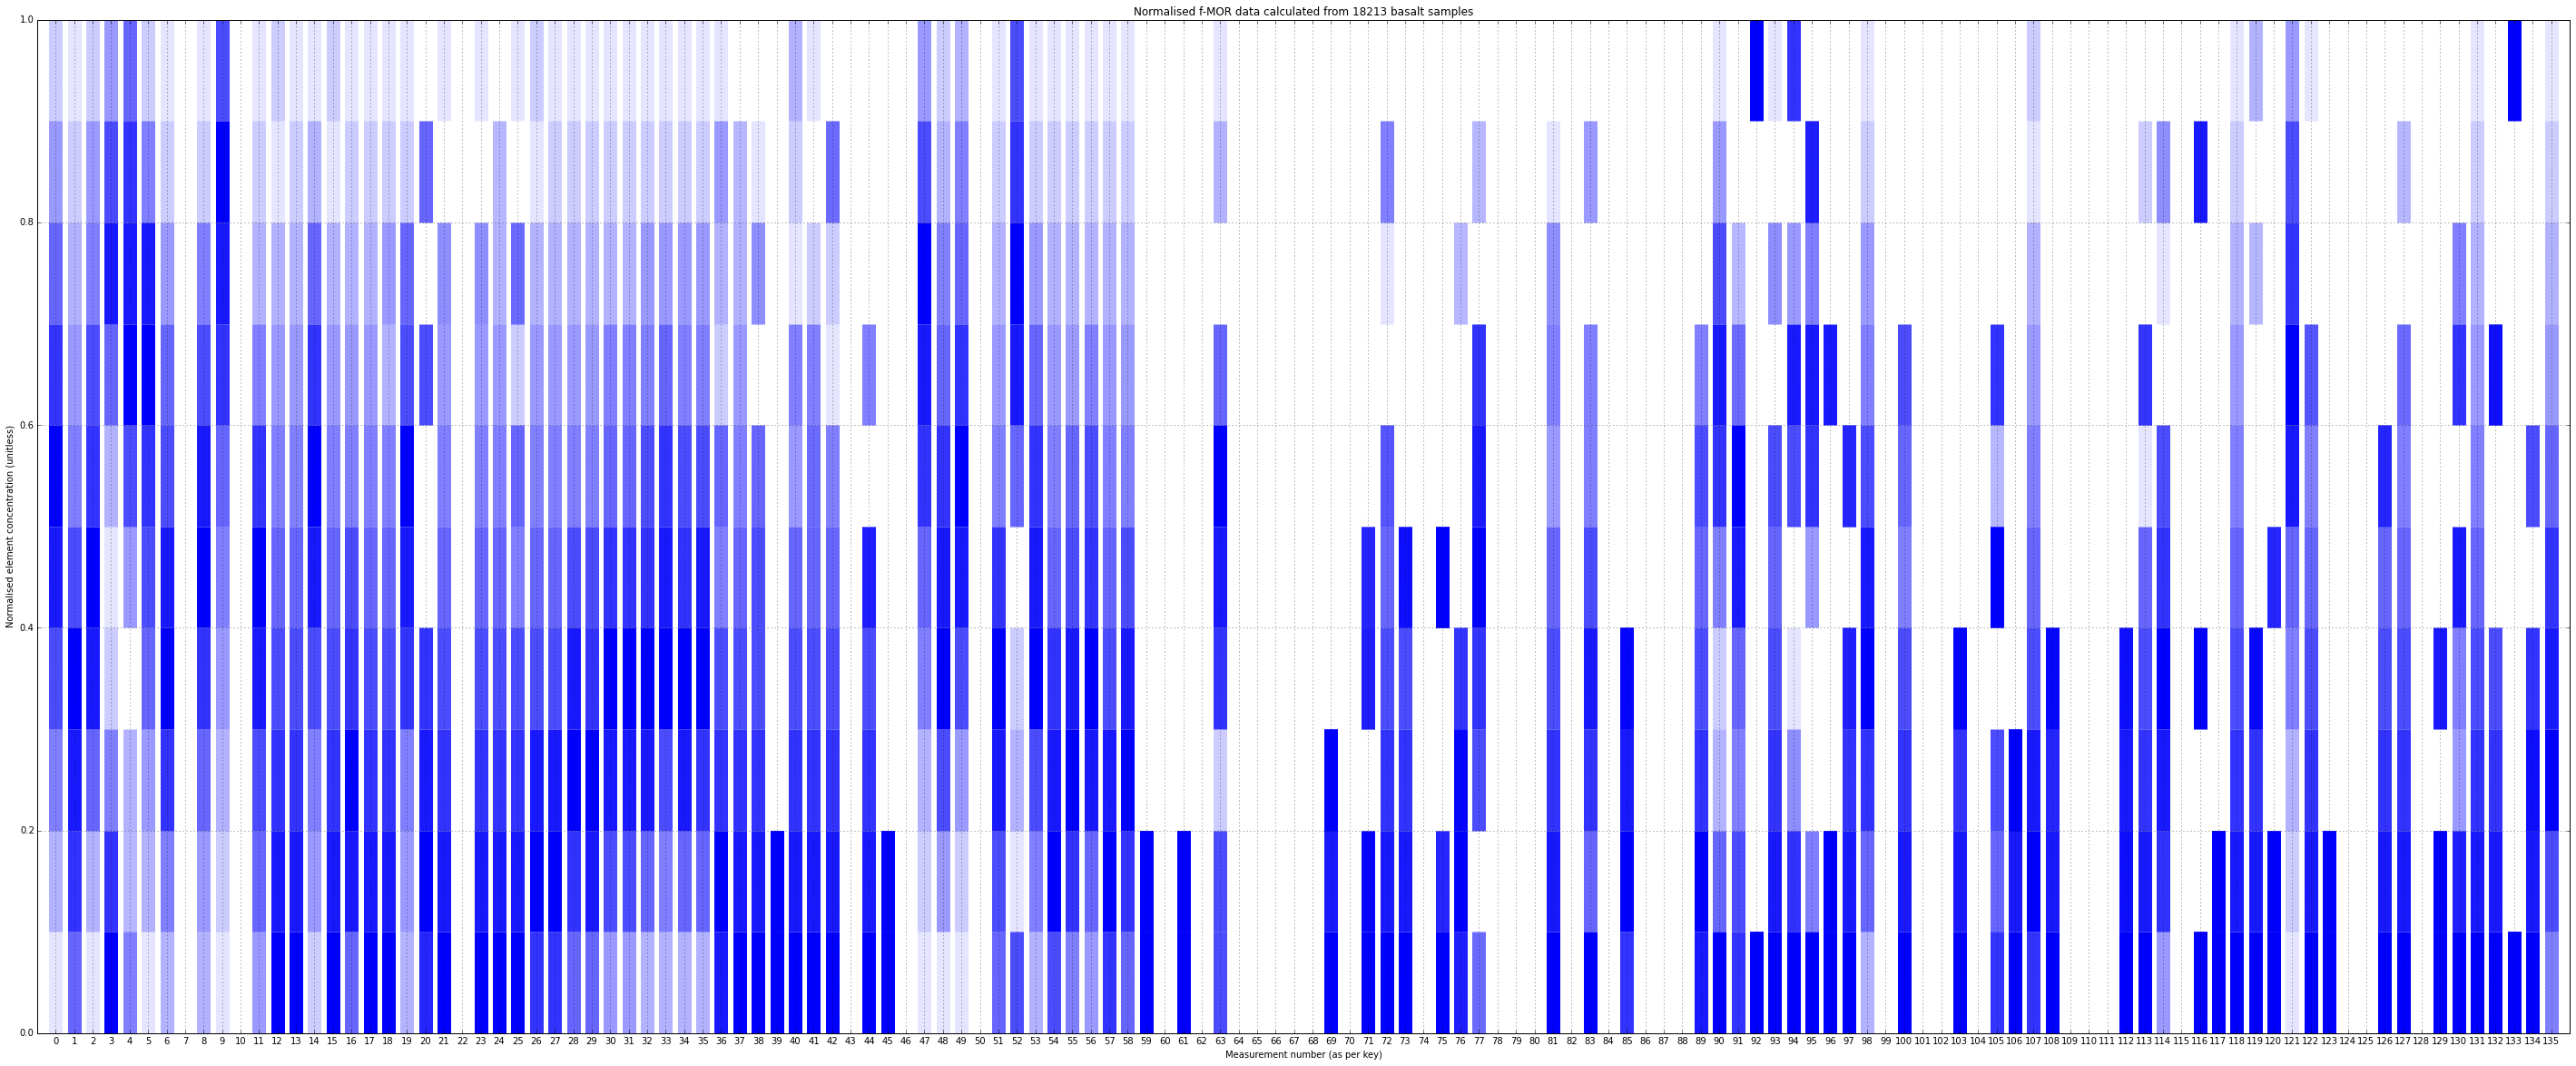

f-Subduction model built from 1858 data points containing 94 available measured data types.


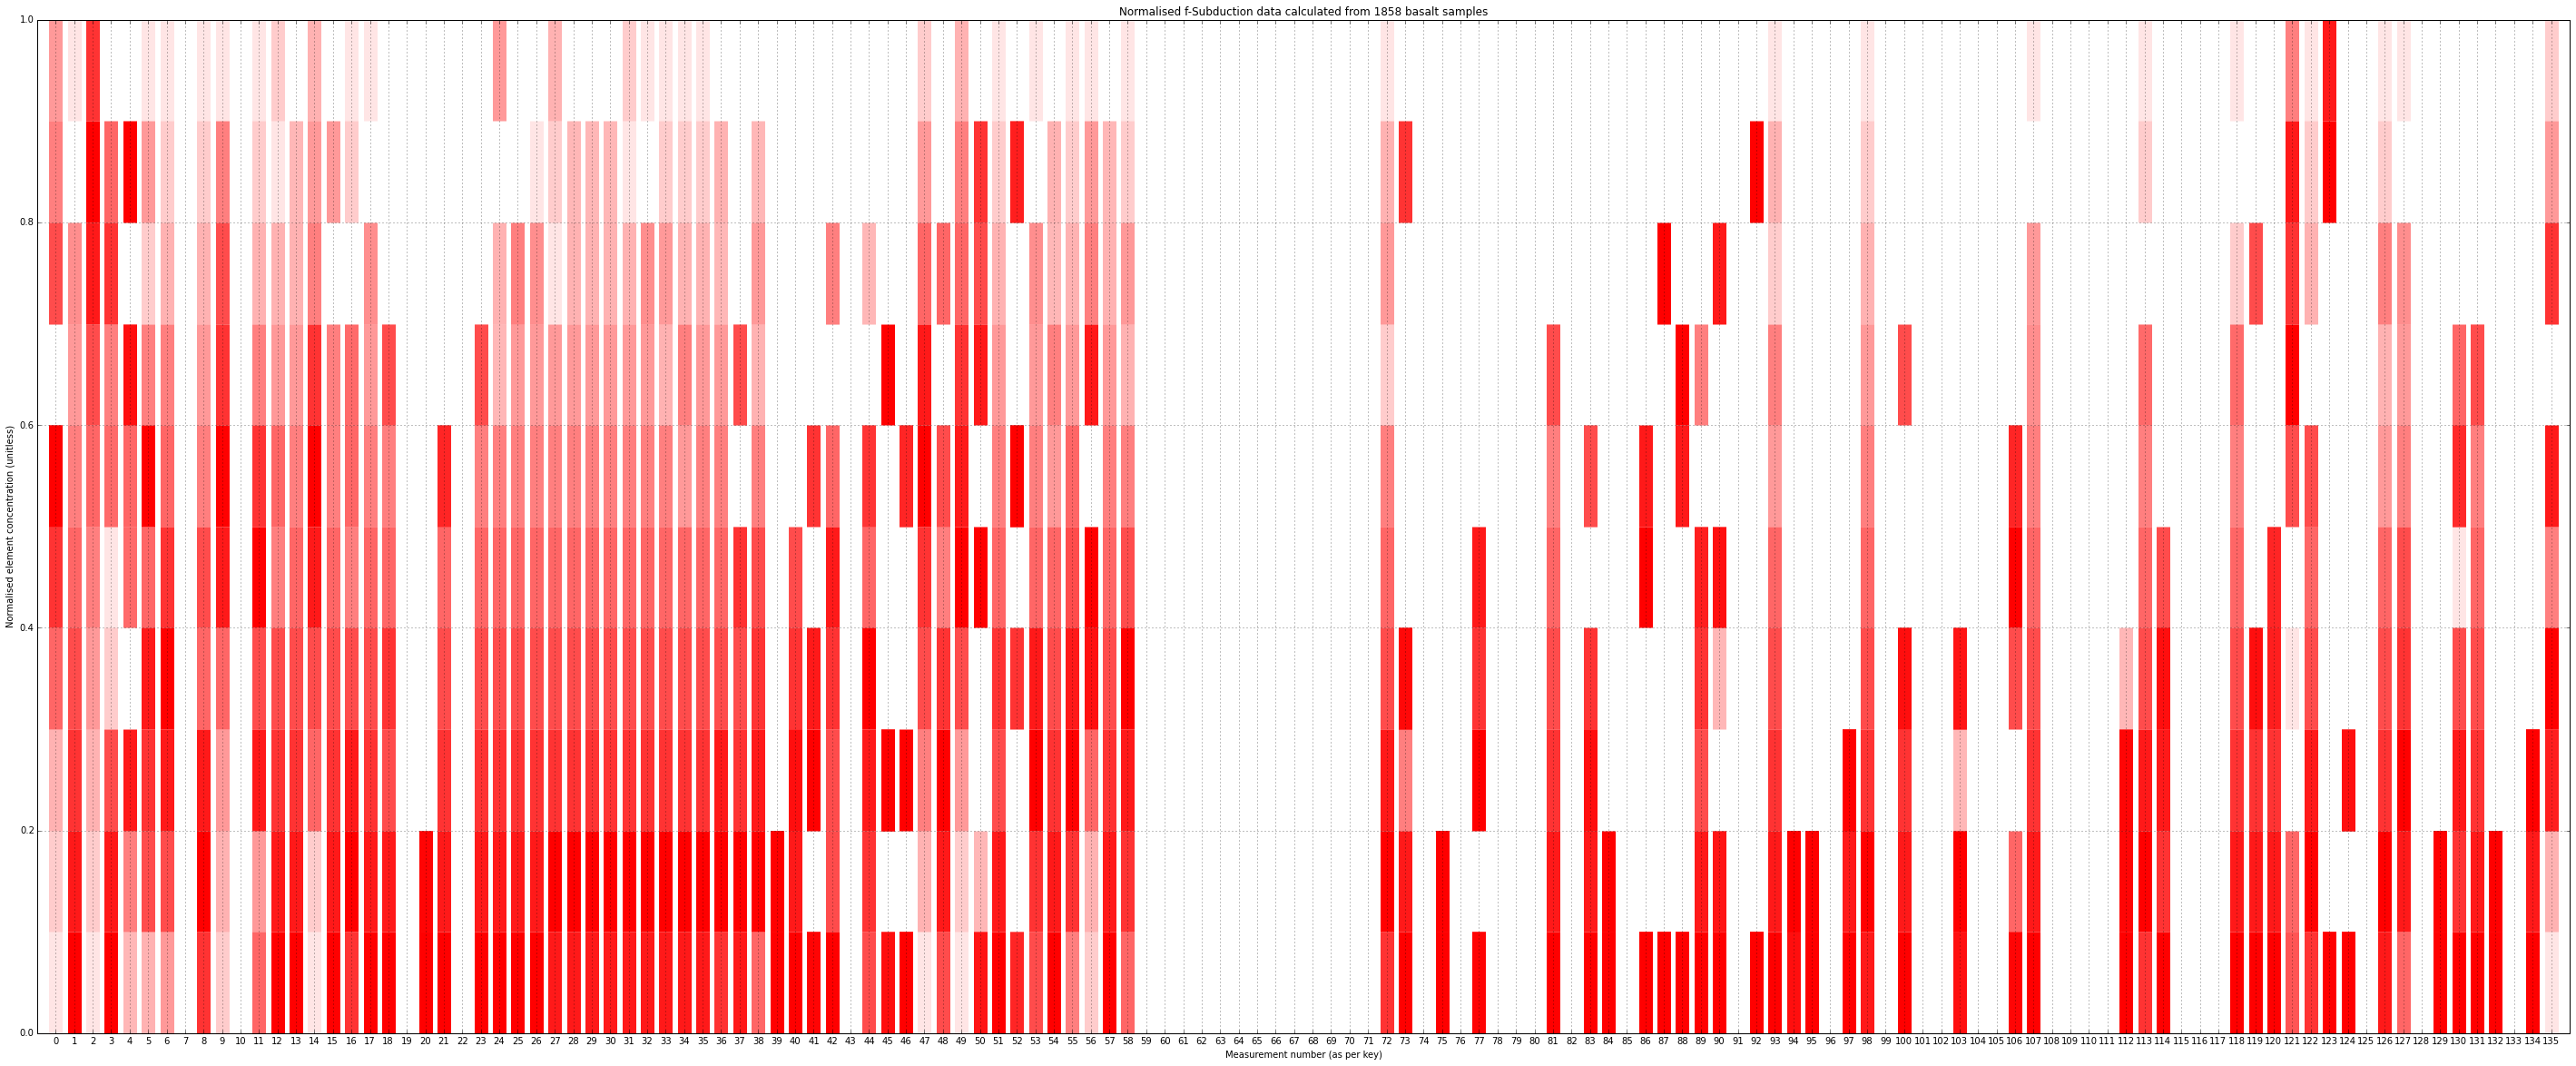

f-Hotspot model built from 10164 data points containing 107 available measured data types.


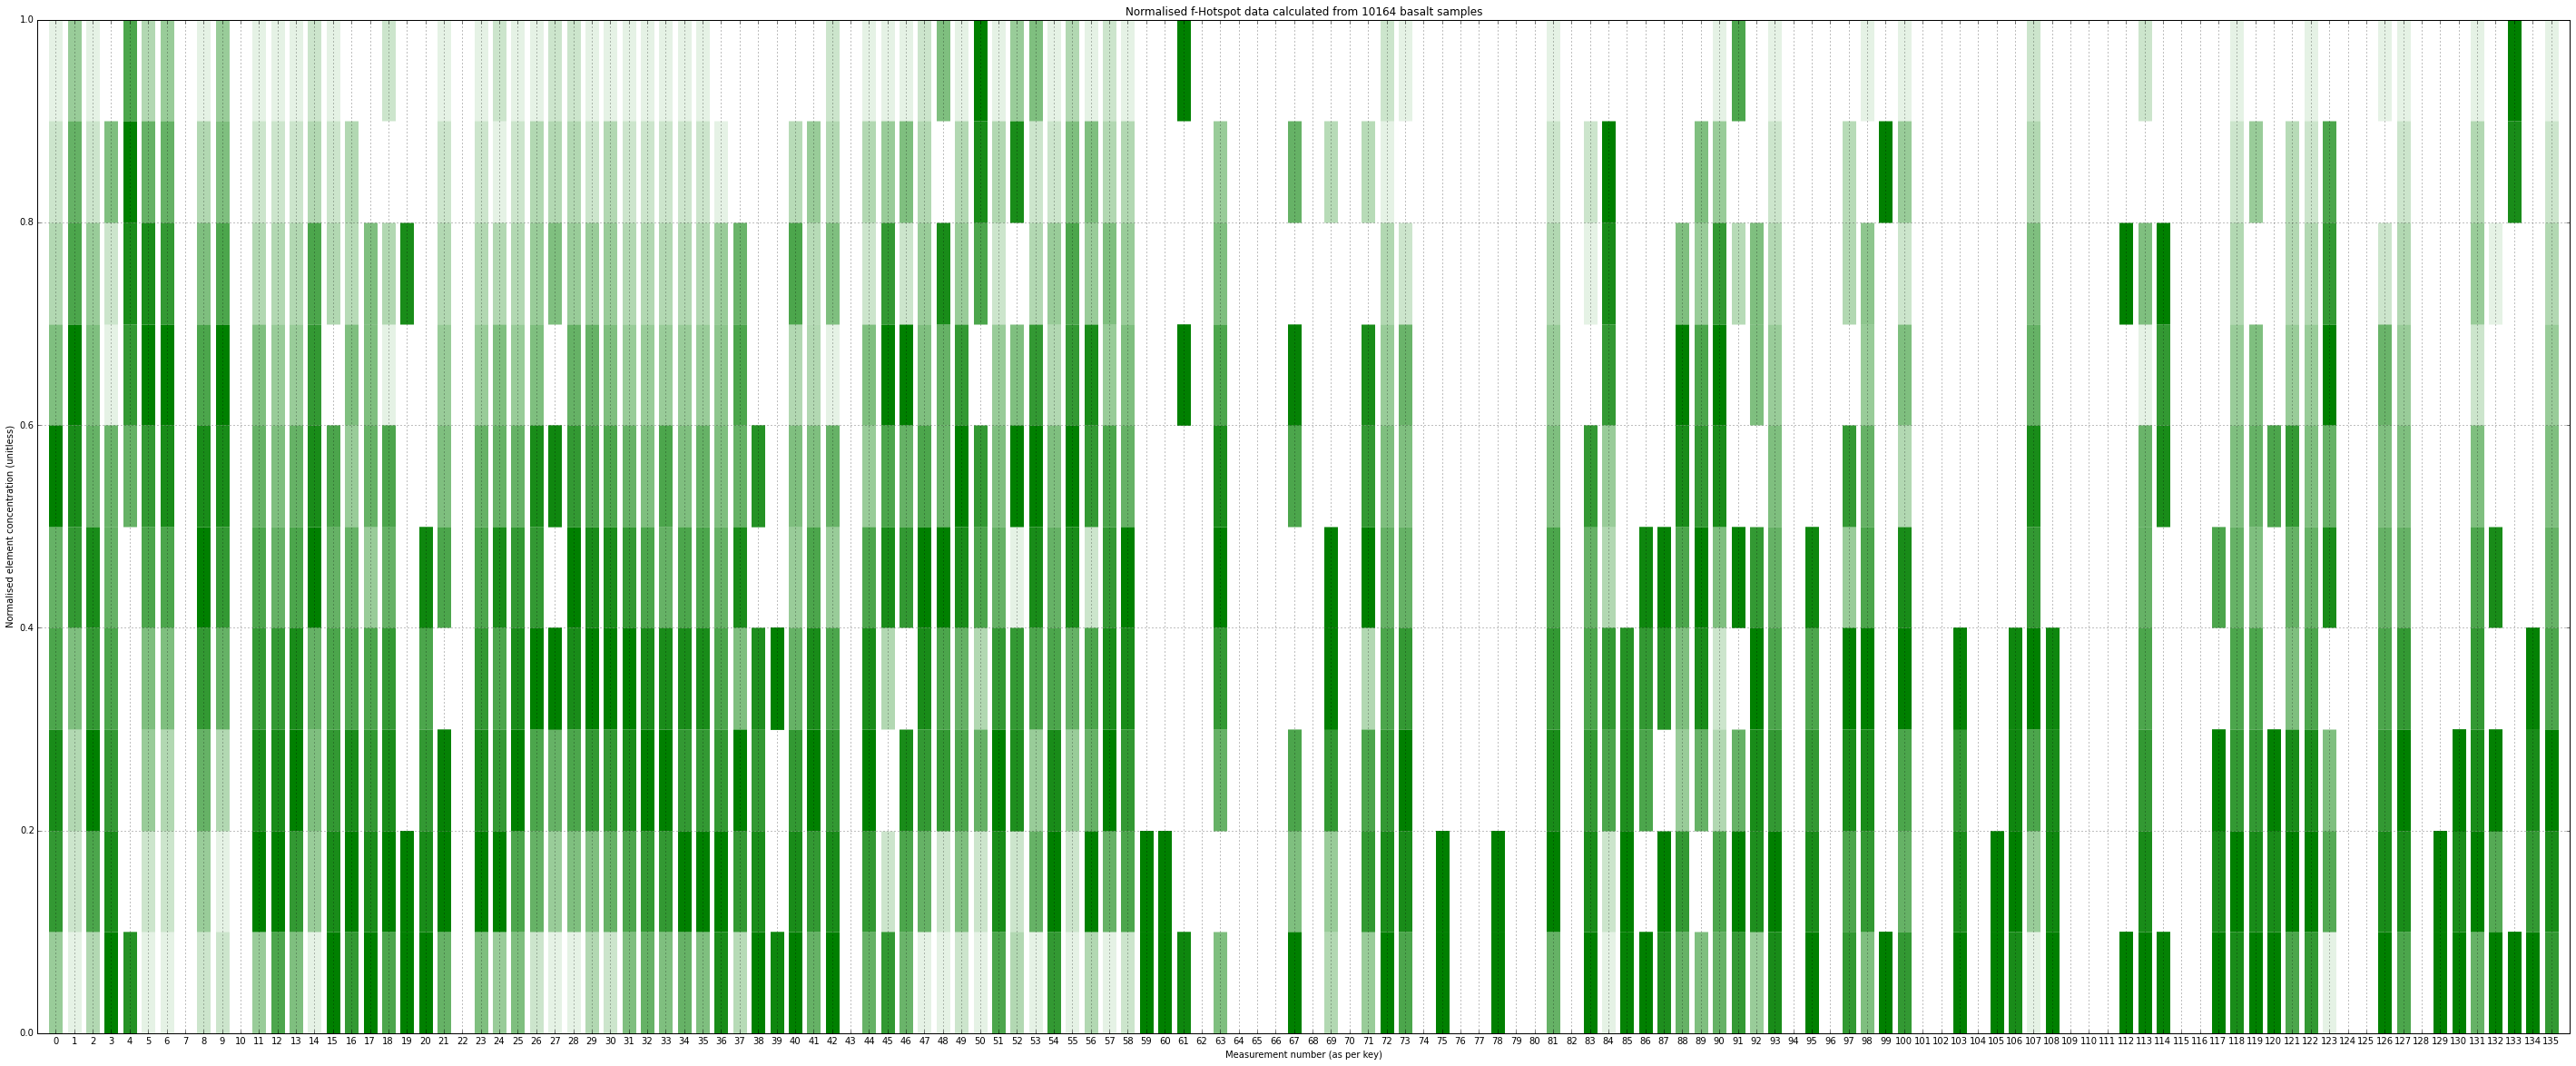

s-MOR model built from 16338 data points containing 102 available measured data types.


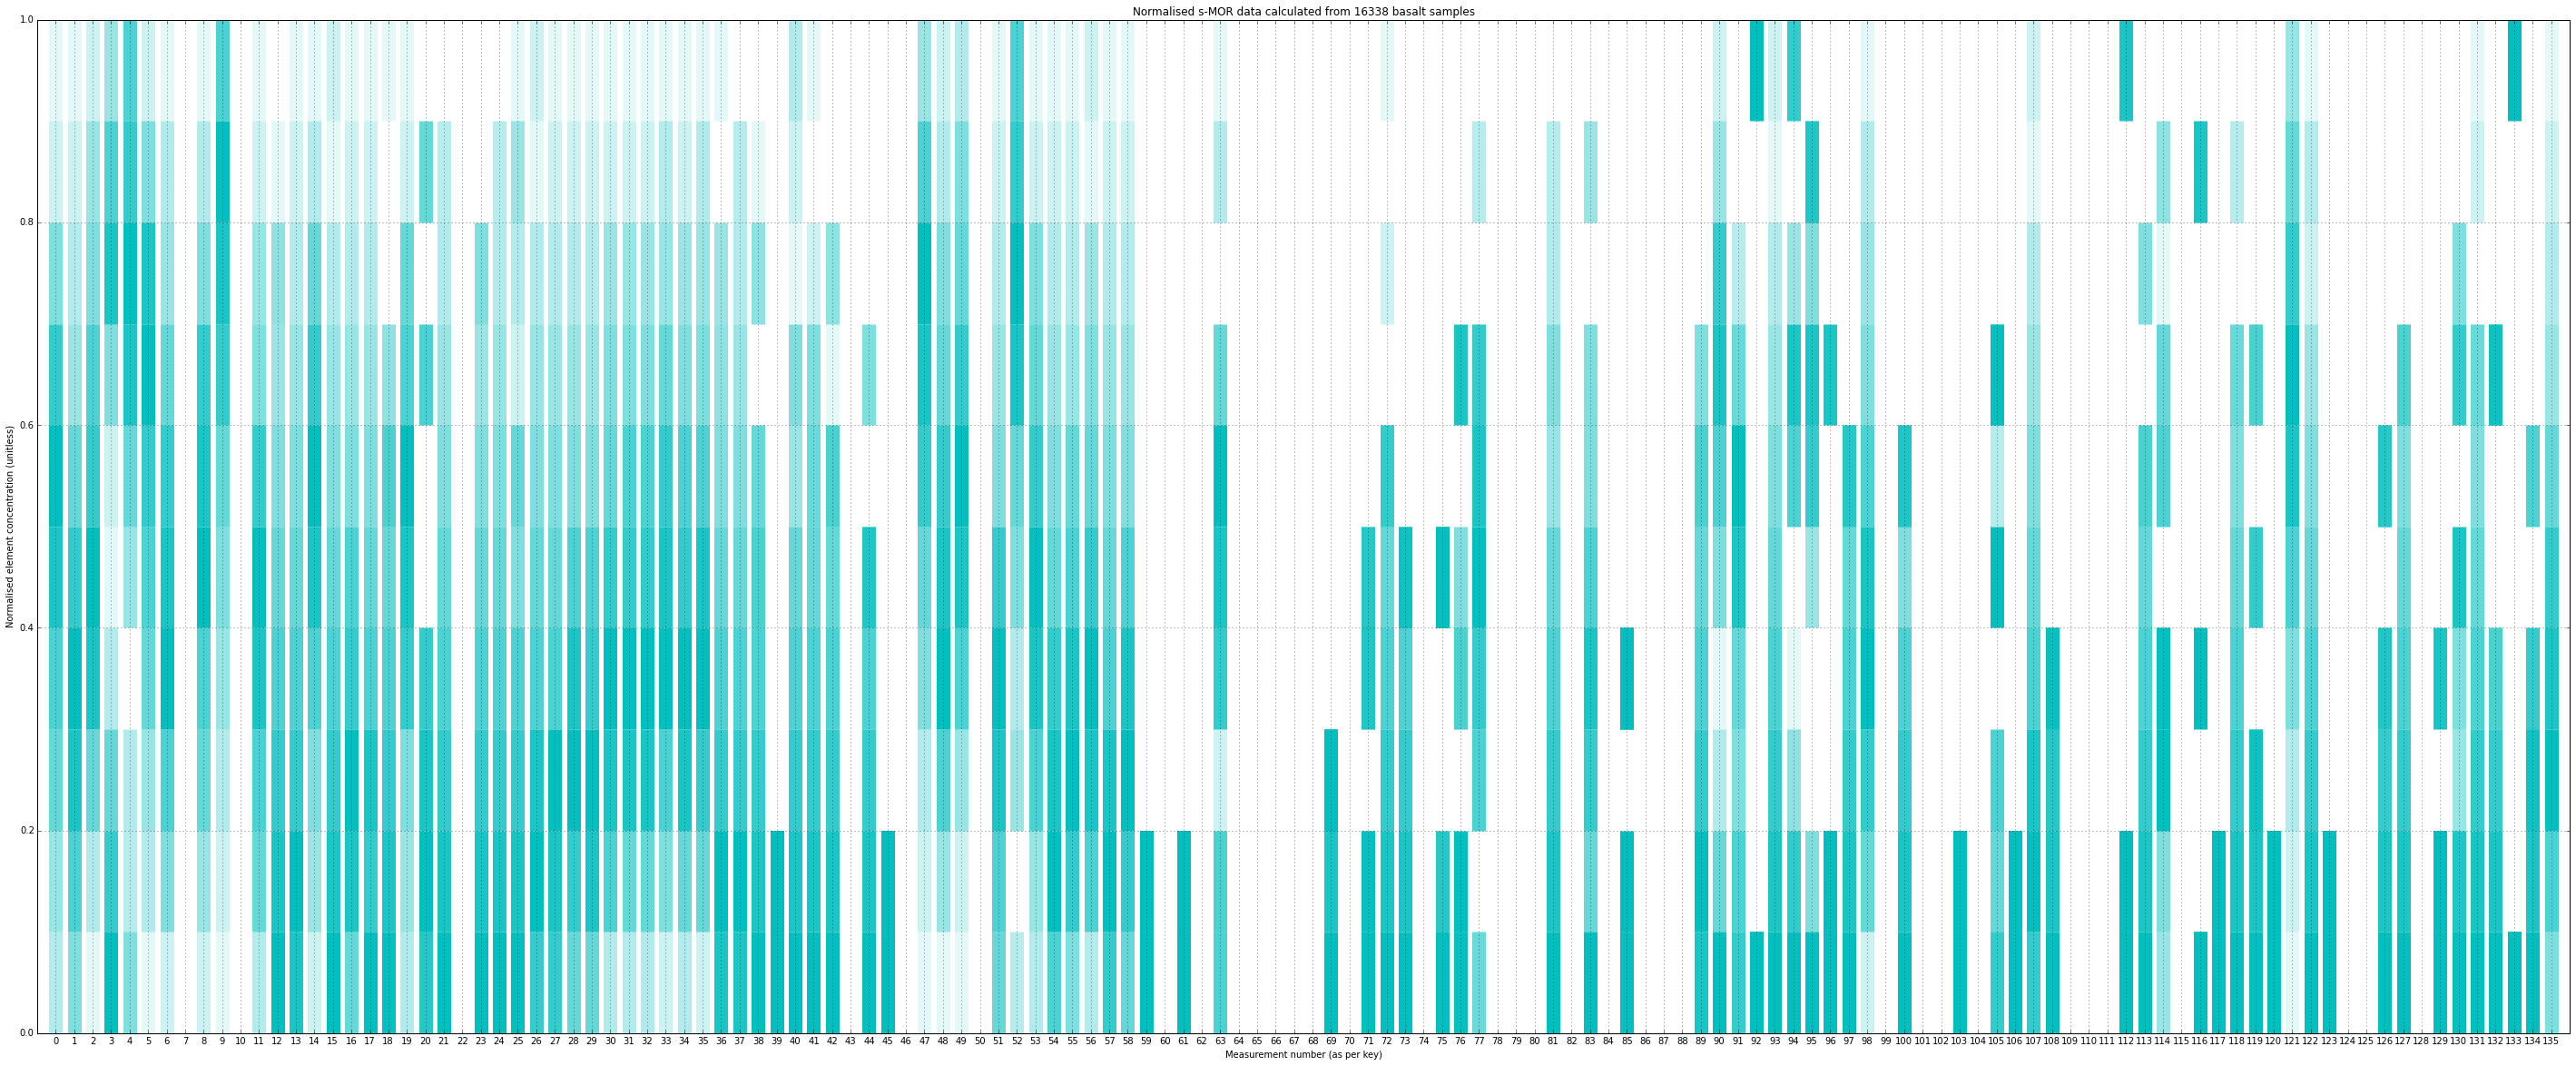

s-Arc-Intraoceanic model built from 637 data points containing 80 available measured data types.


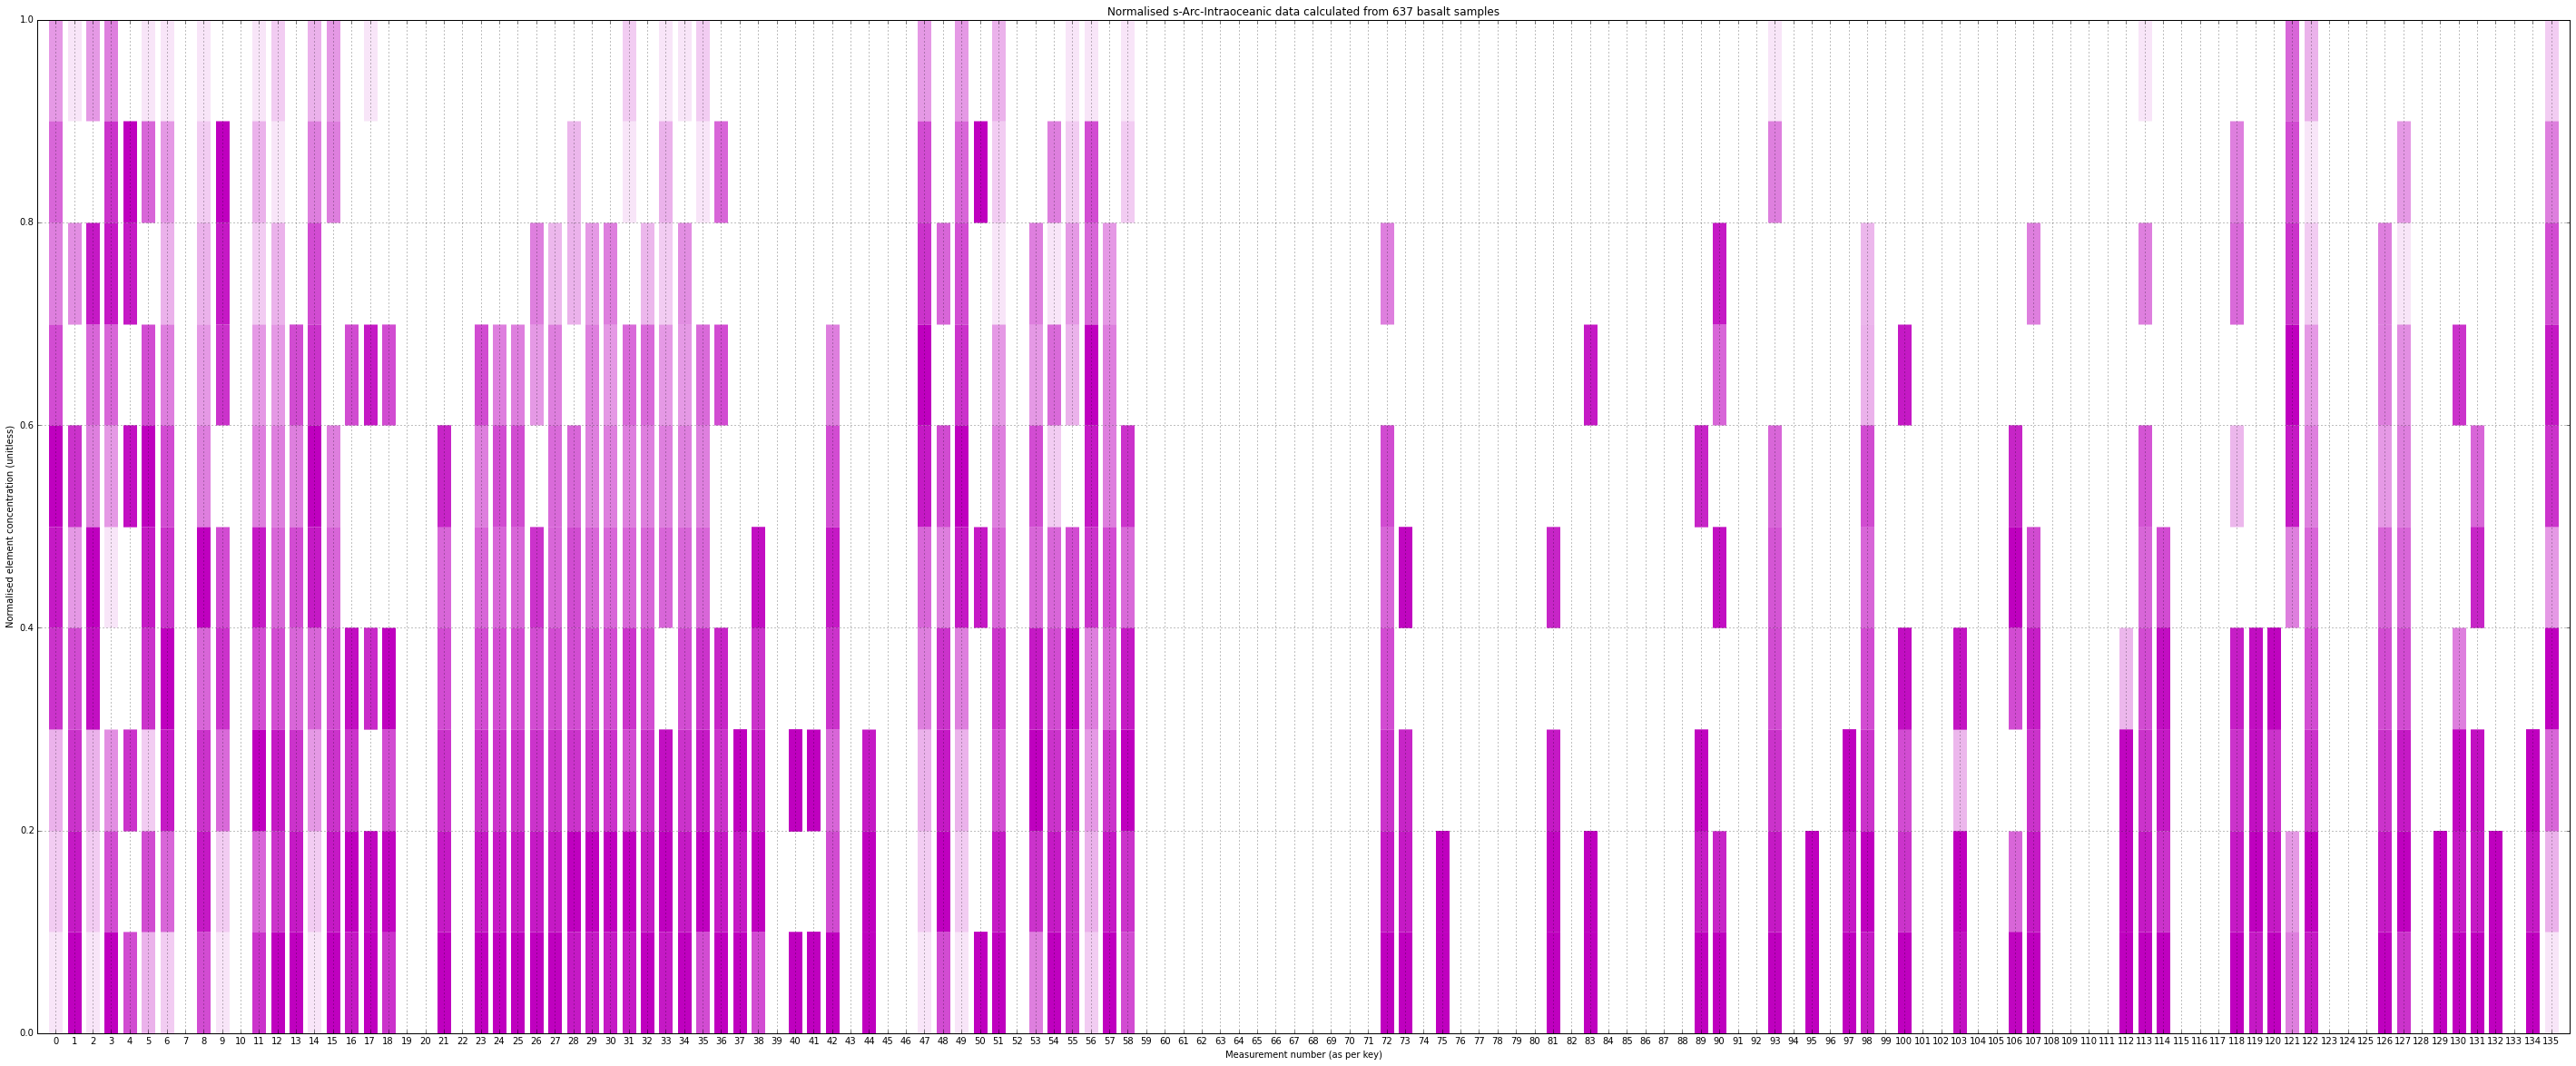

s-Arc-Continental model built from 176 data points containing 62 available measured data types.


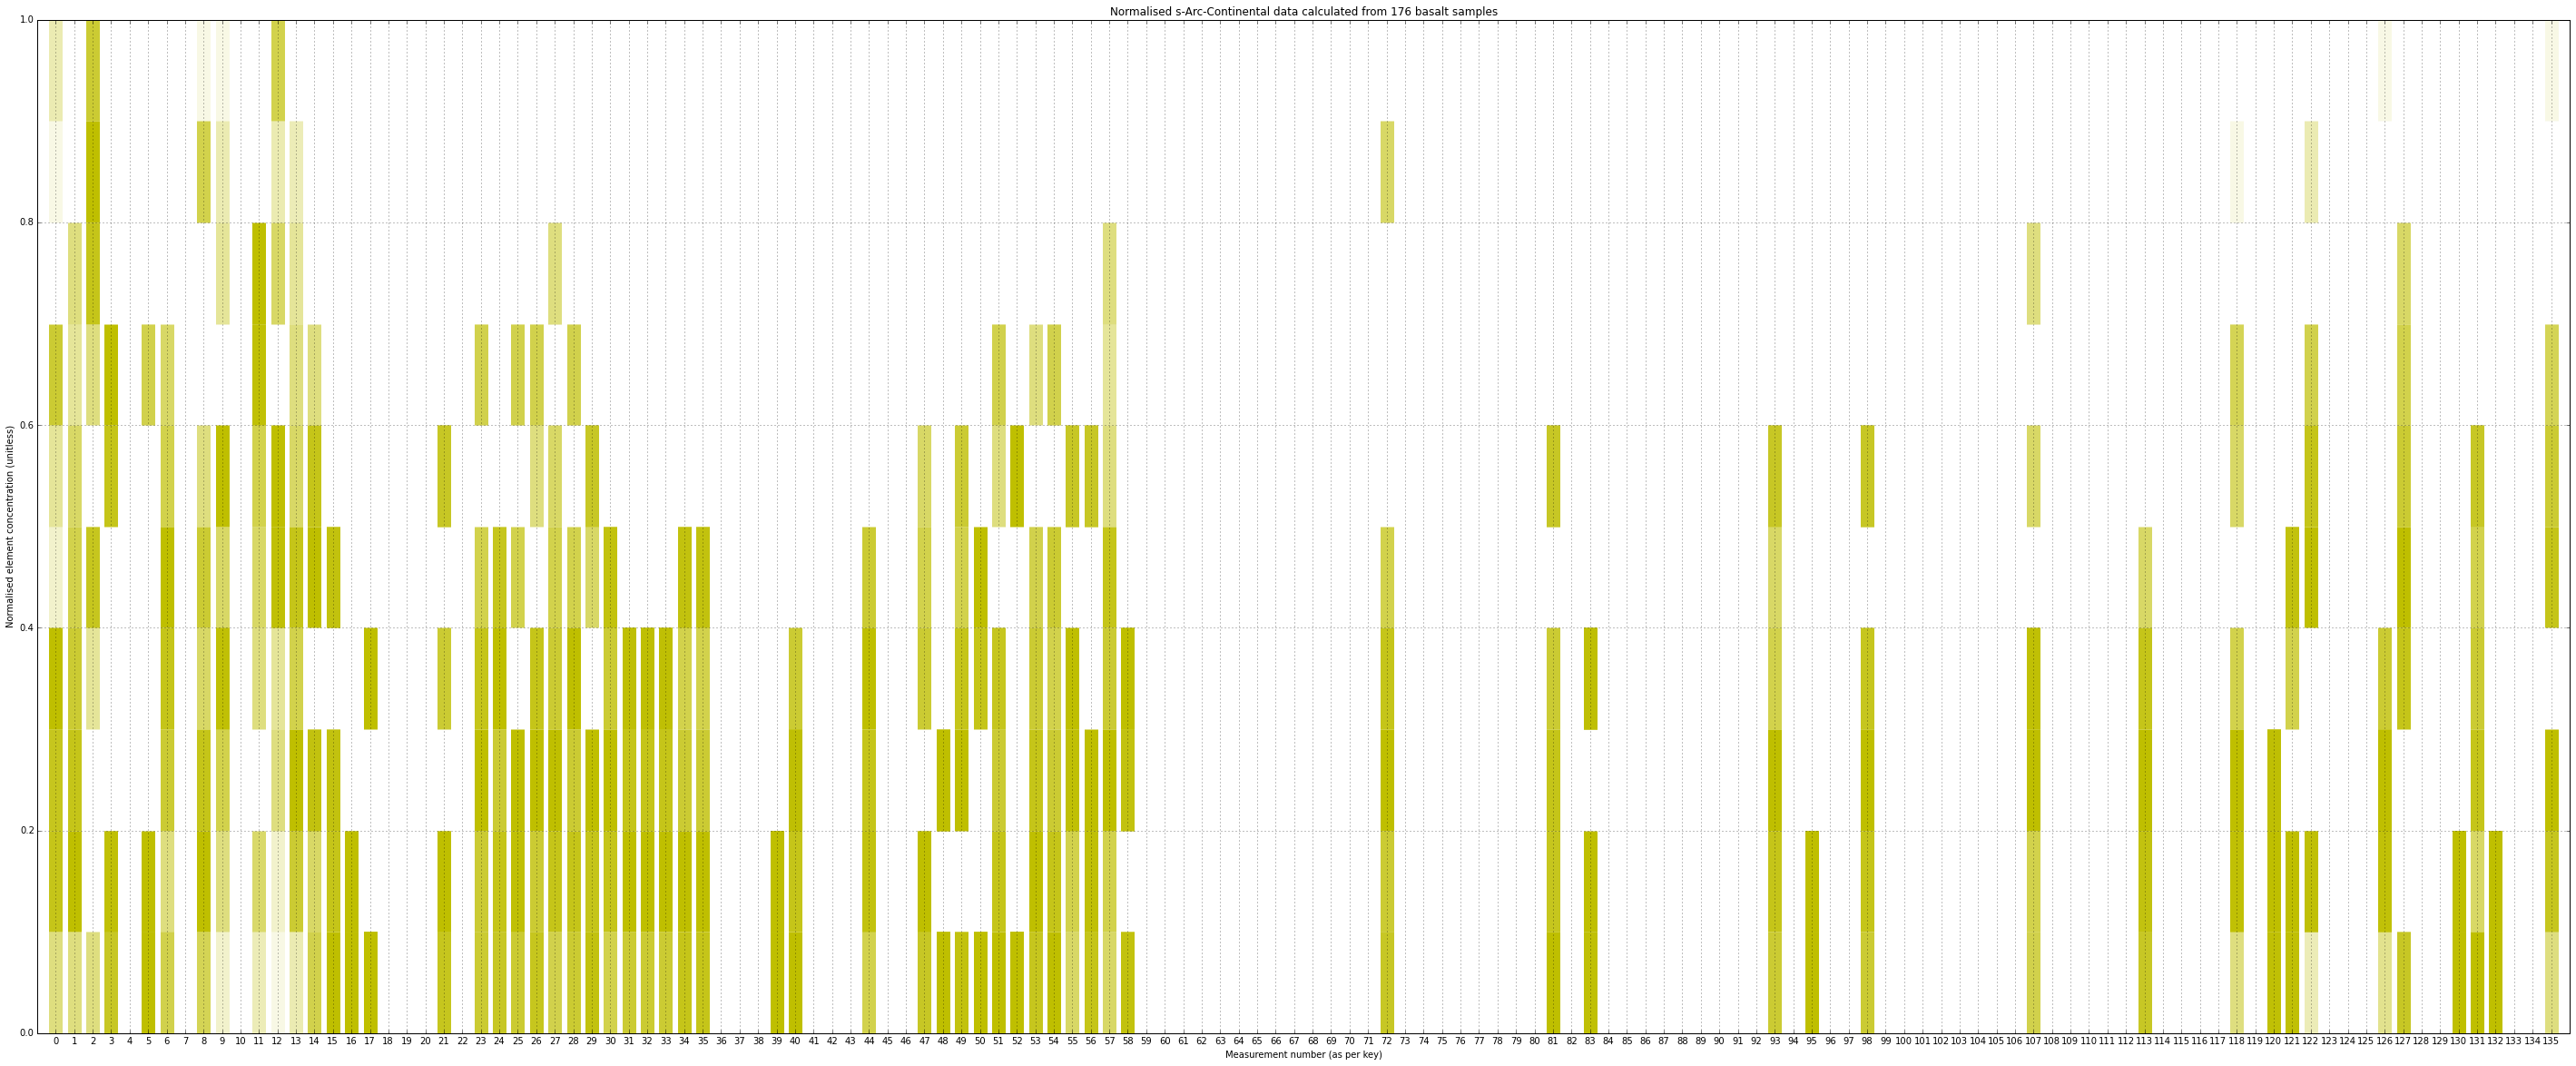

s-Arc-Continental-Aleutian model built from 1045 data points containing 87 available measured data types.


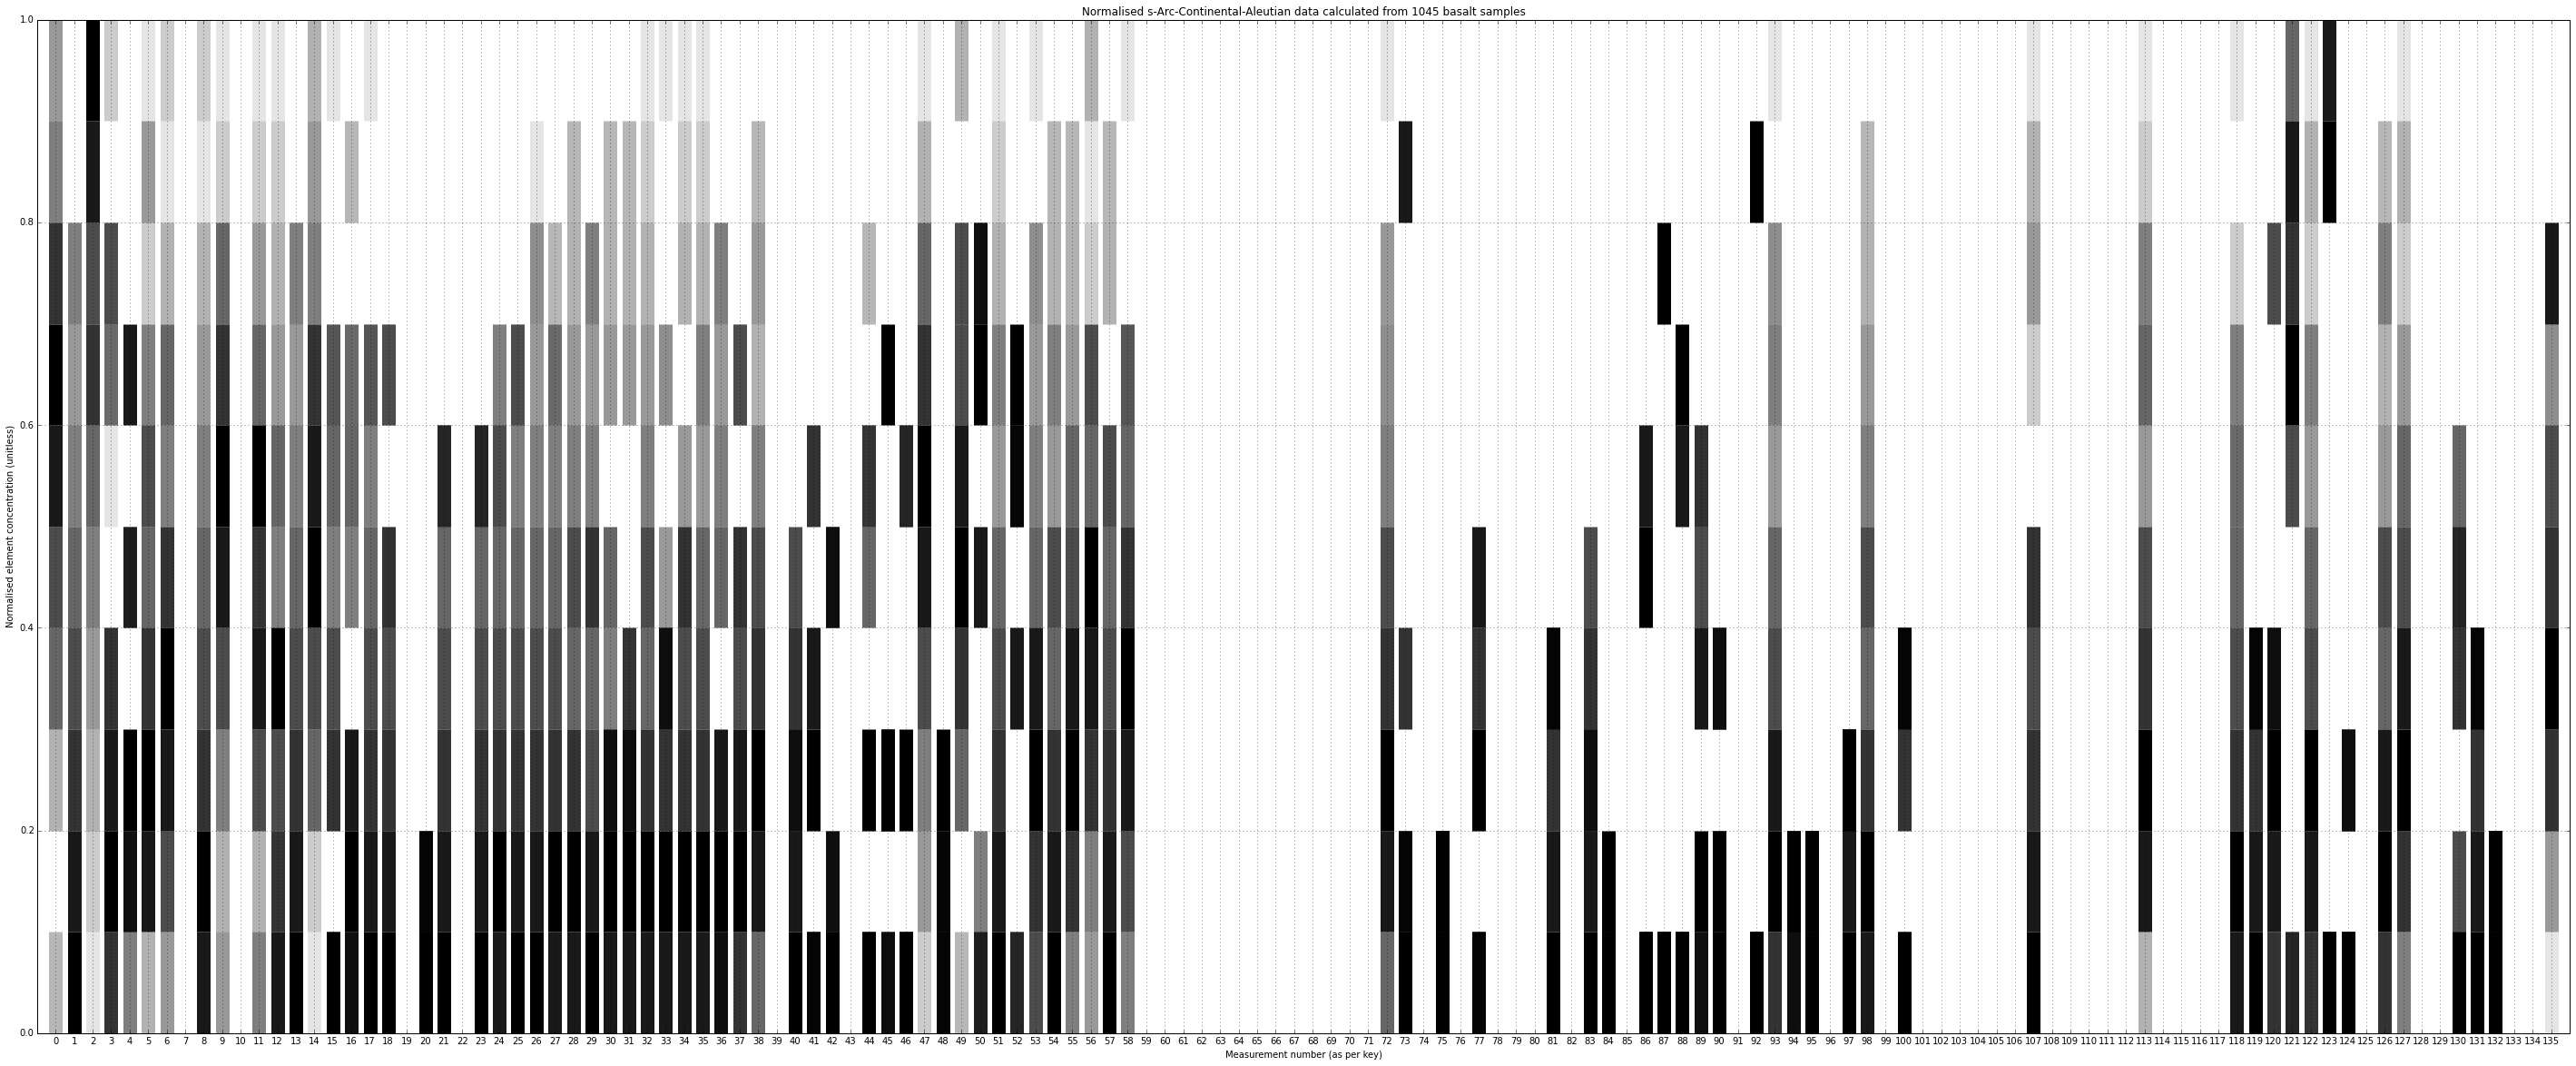

s-BAB model built from 1875 data points containing 89 available measured data types.


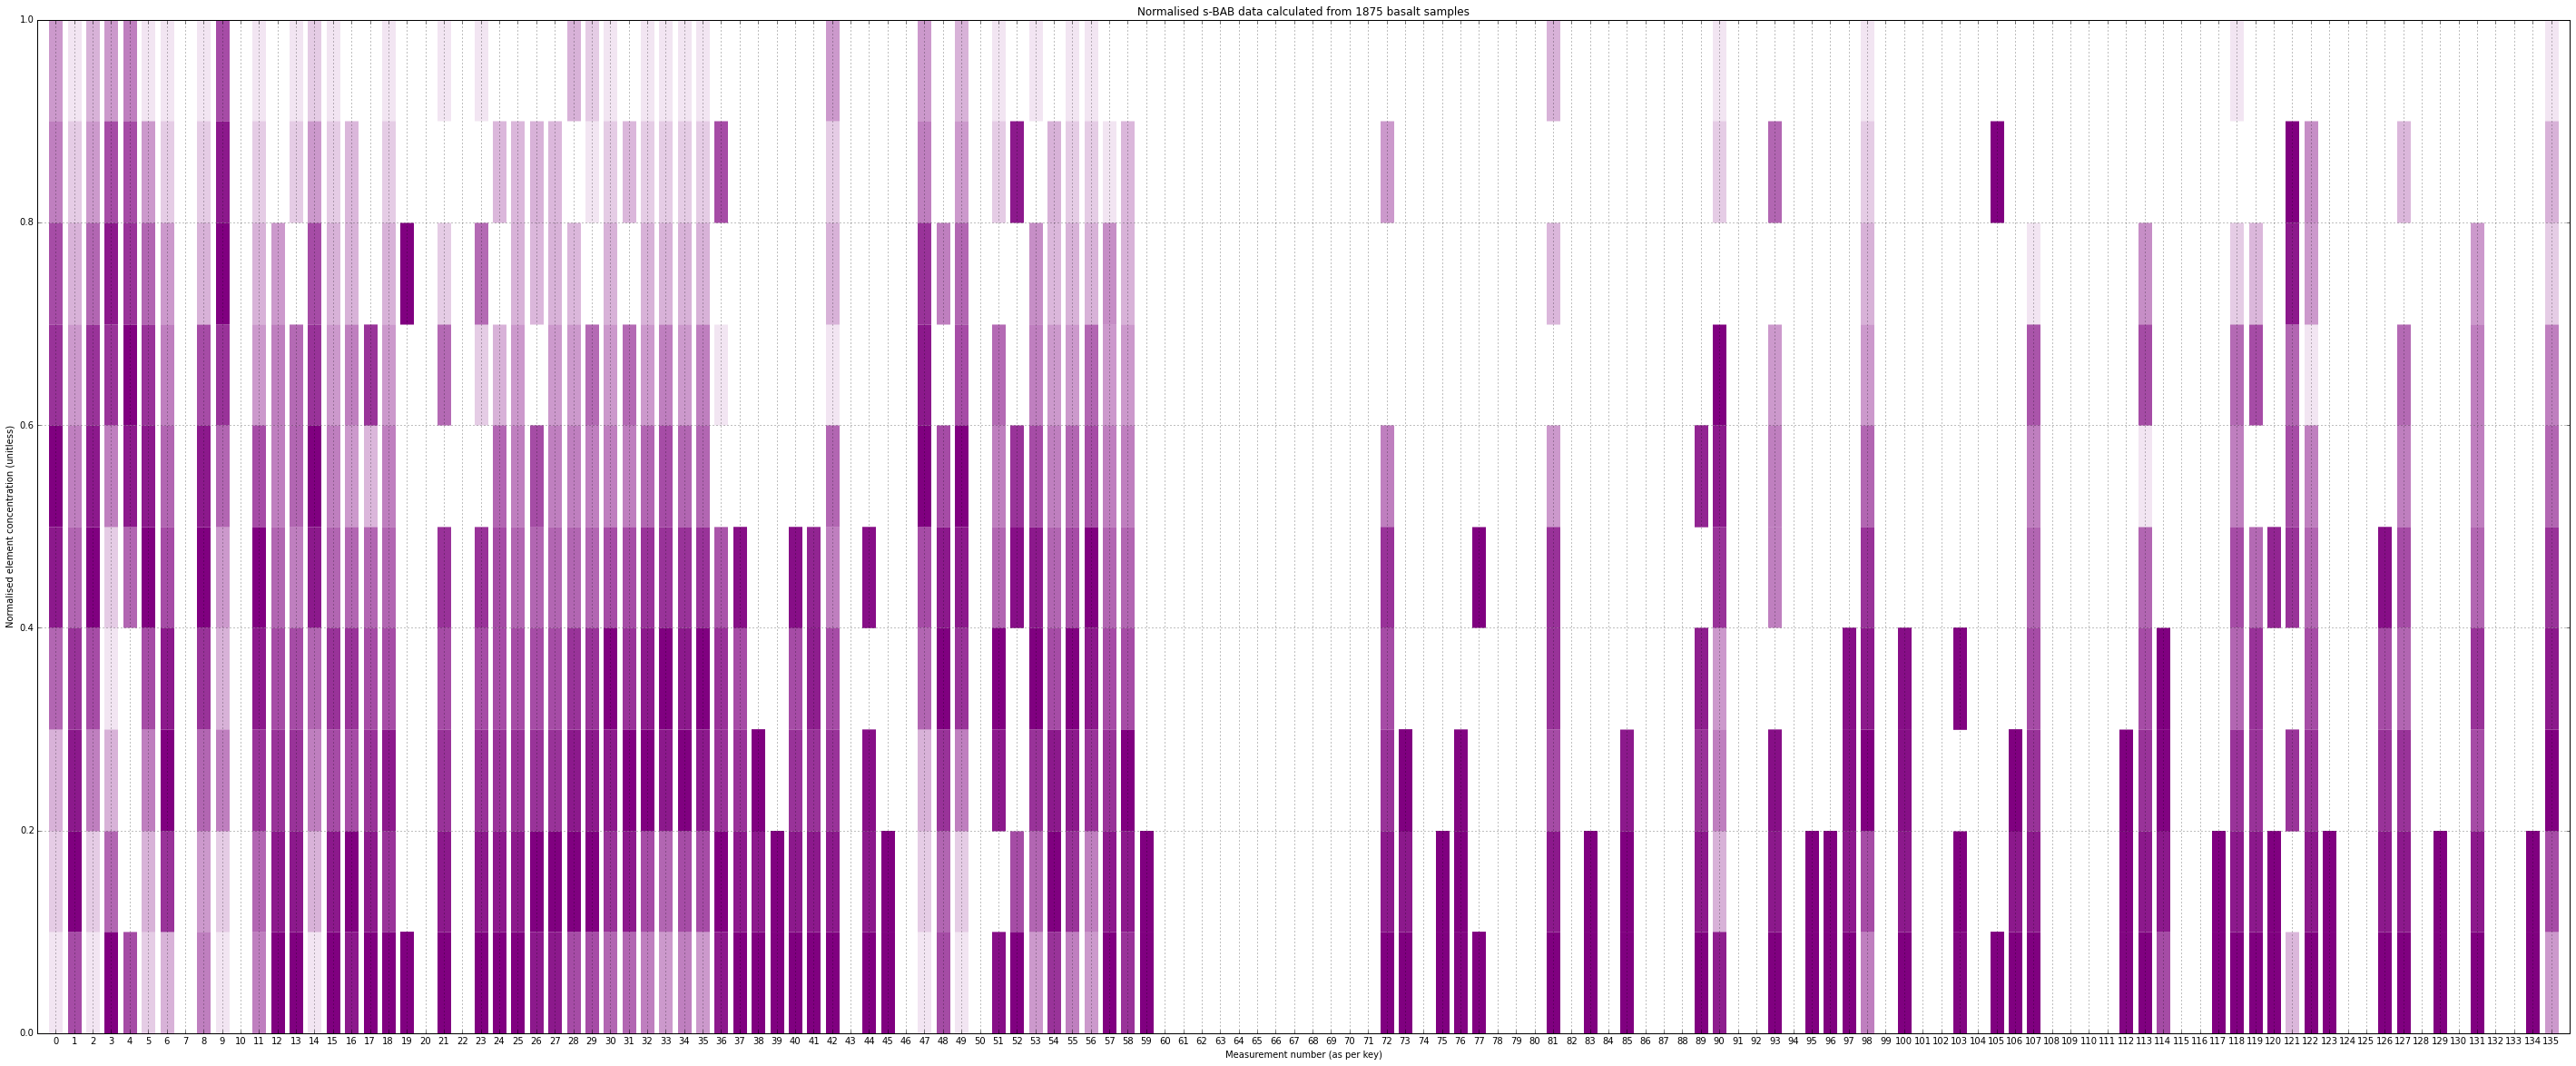

s-Rift model built from 6312 data points containing 93 available measured data types.


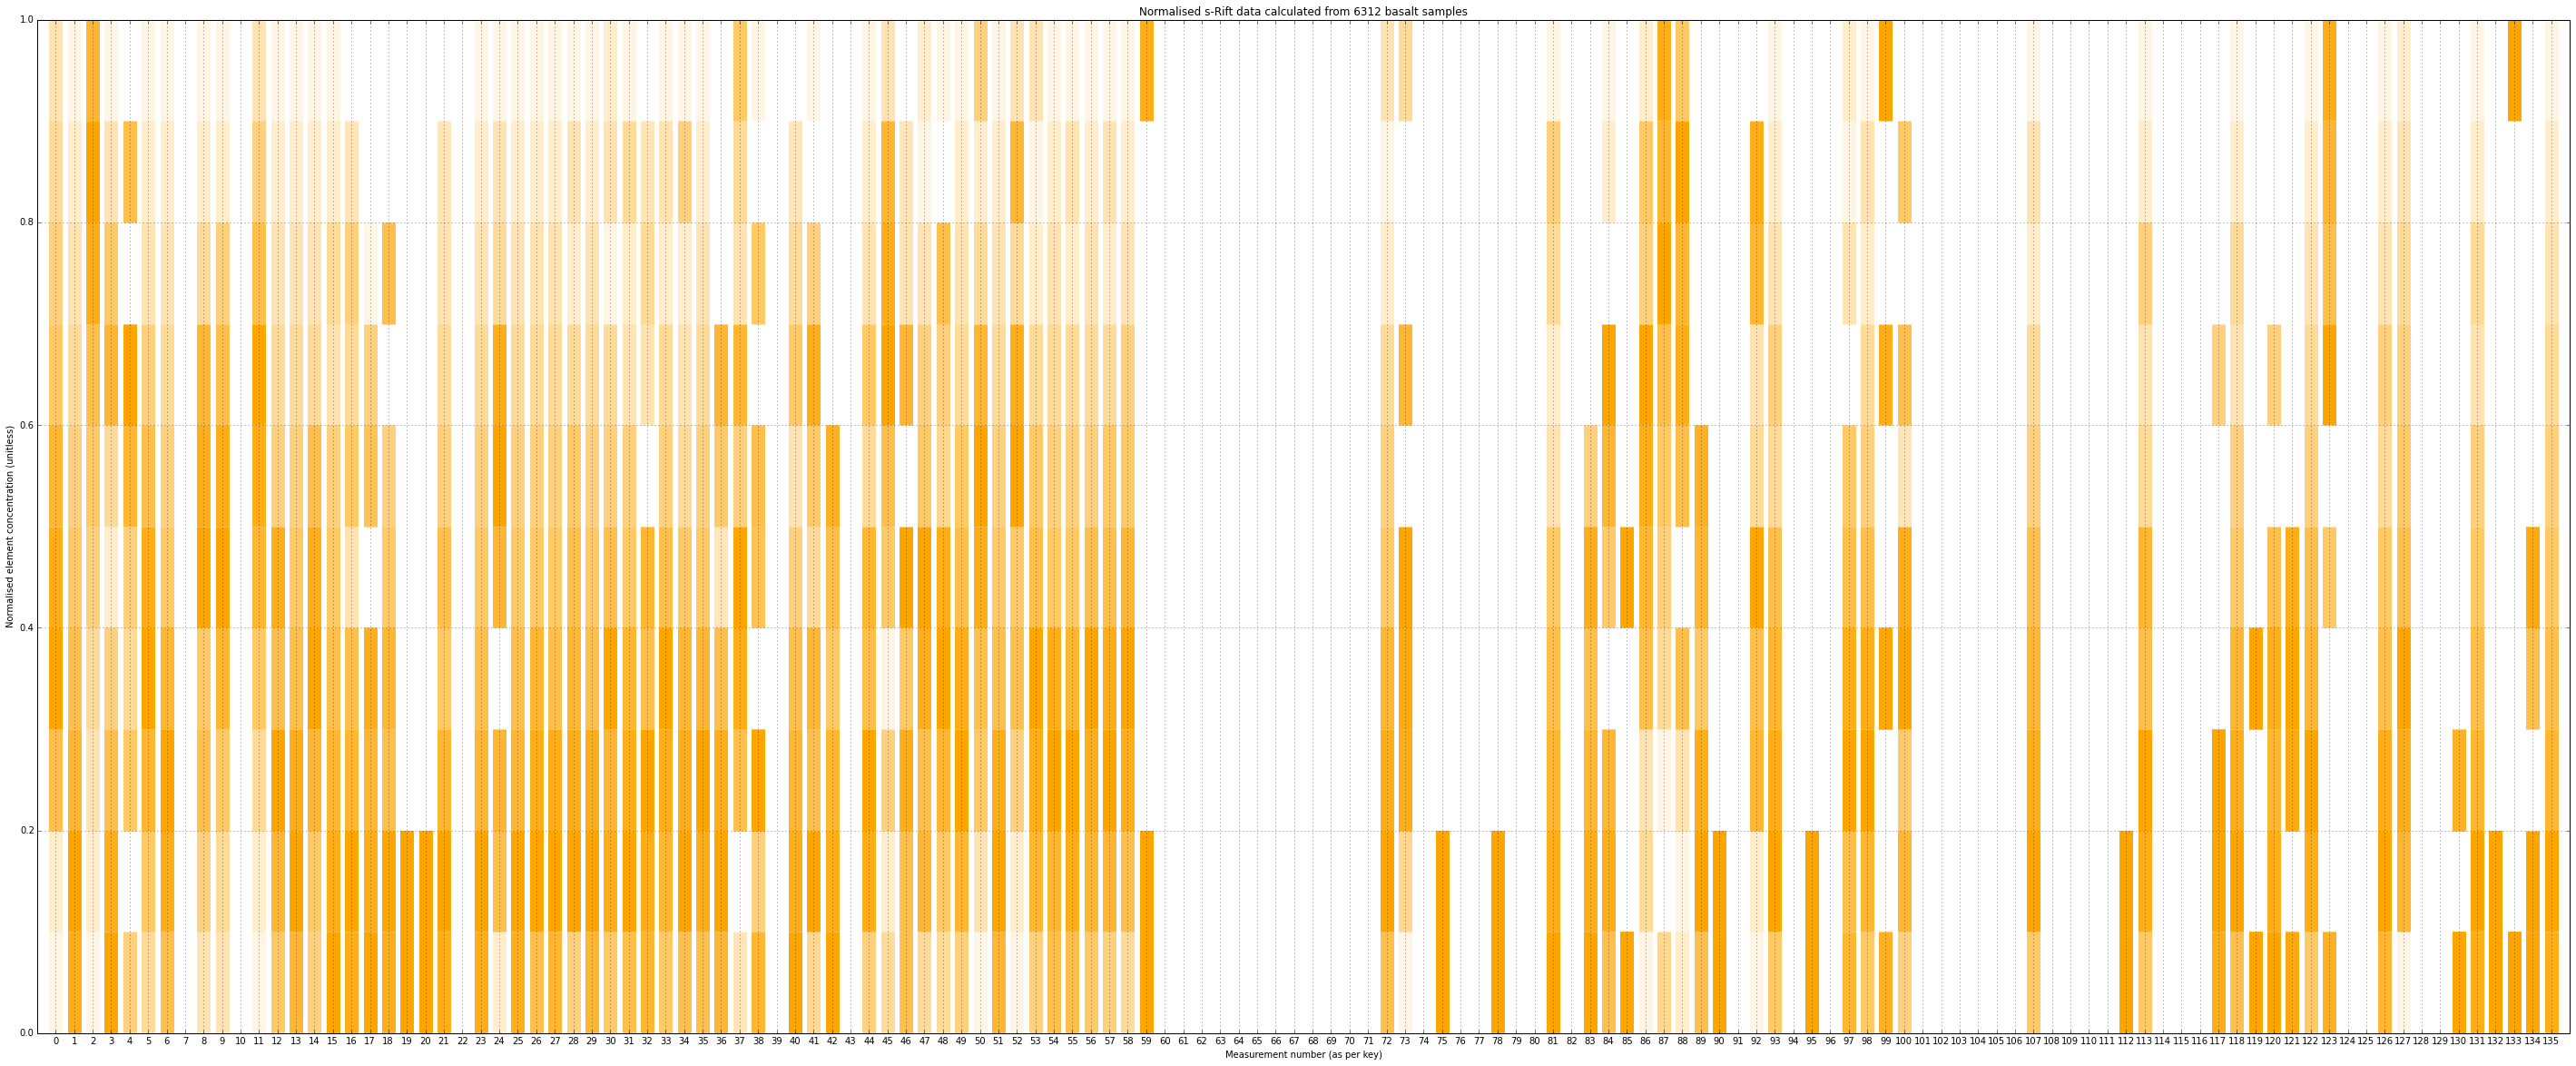

s-Hotspot model built from 10199 data points containing 107 available measured data types.


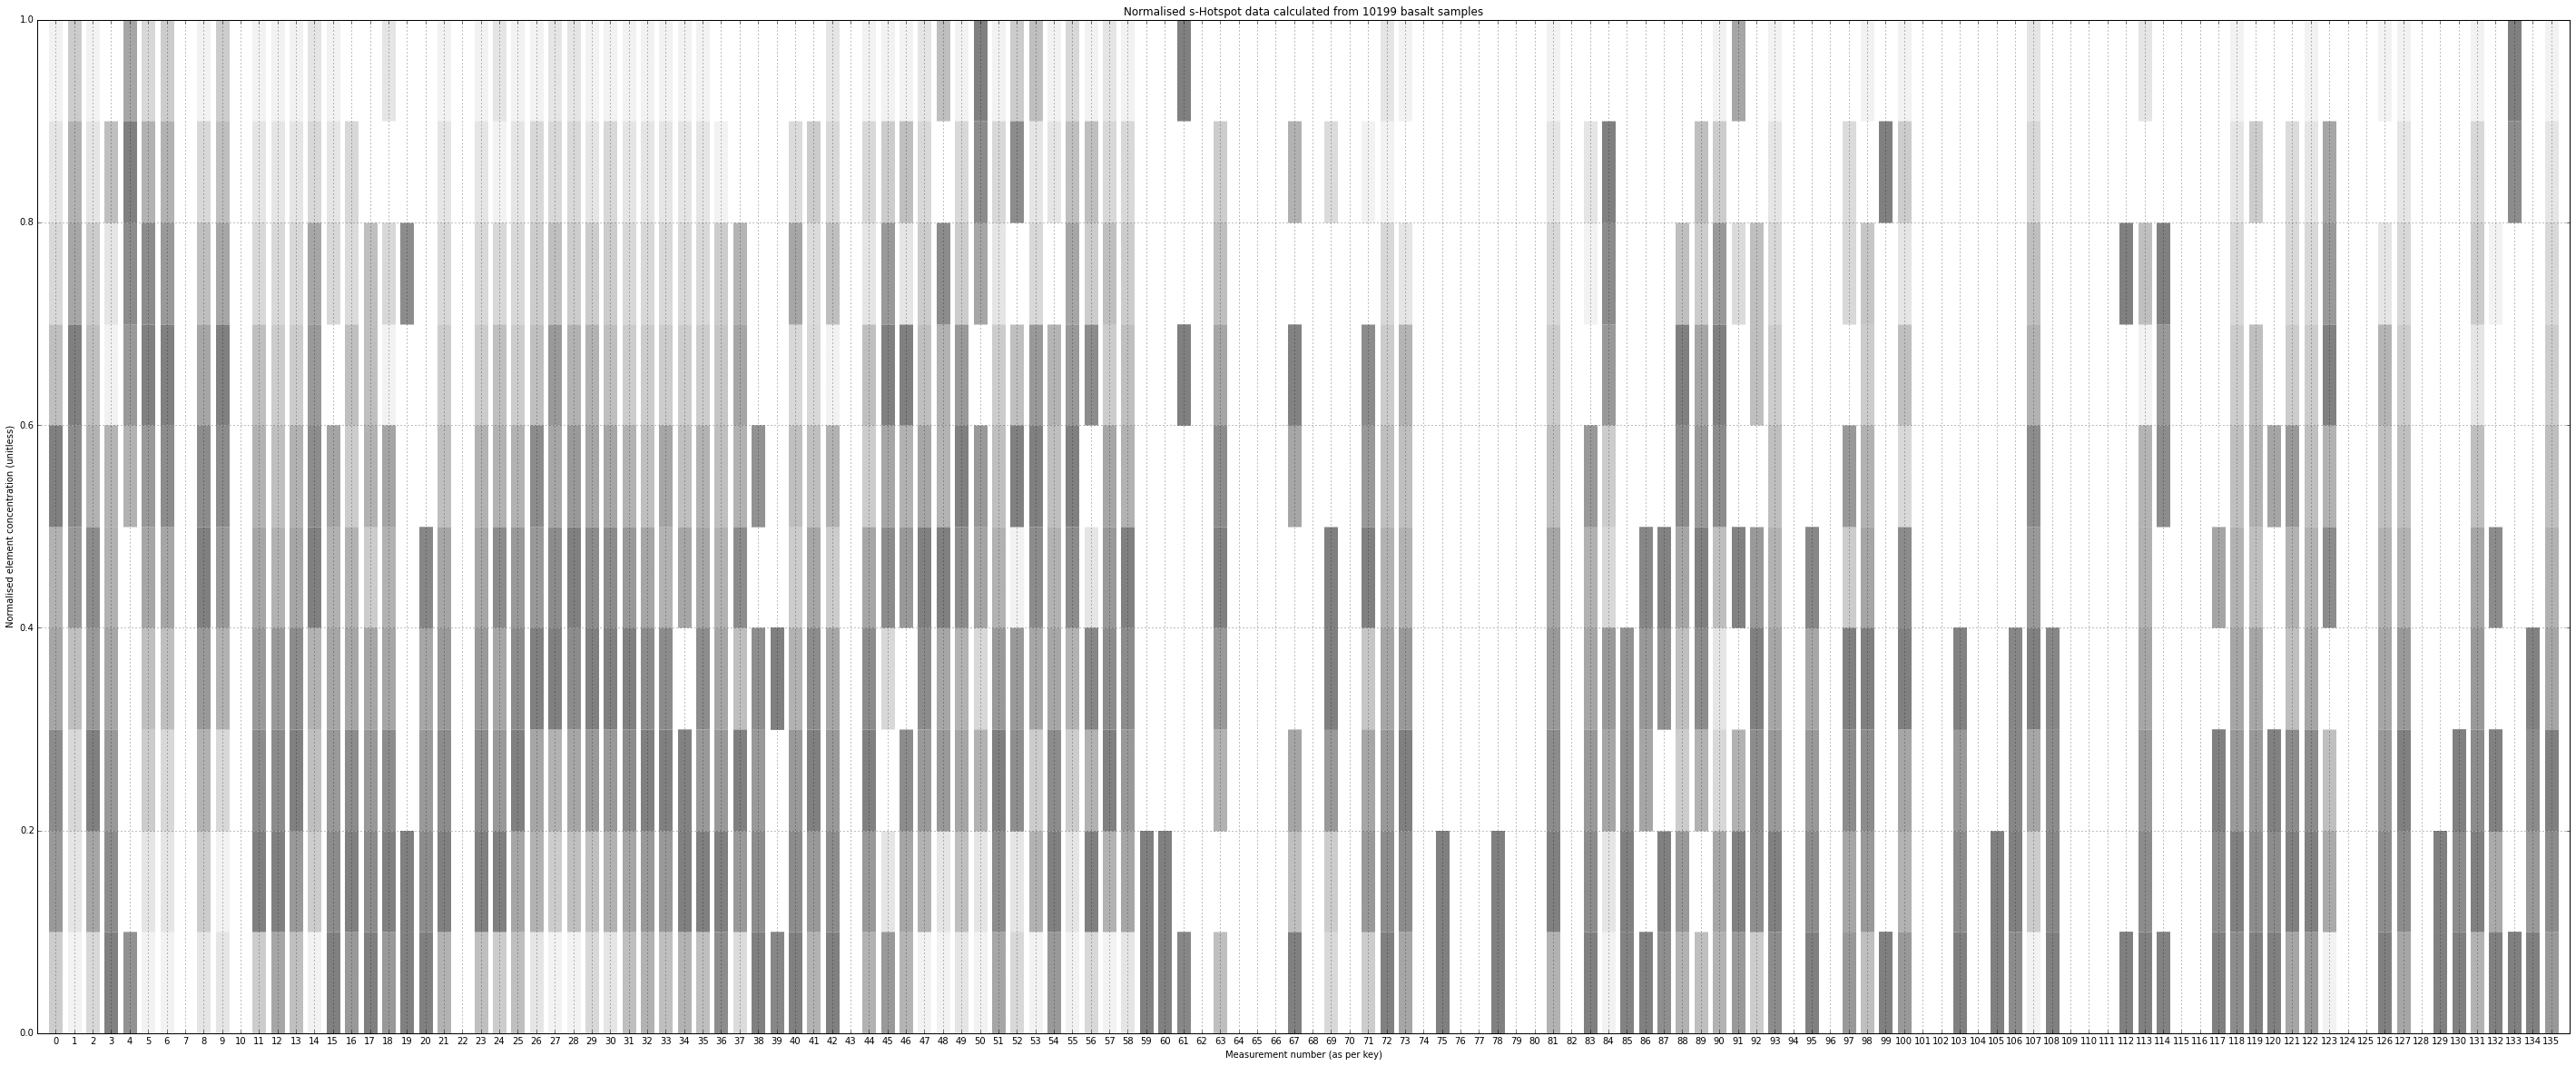

s-Hotspot-Ridge model built from 4027 data points containing 103 available measured data types.


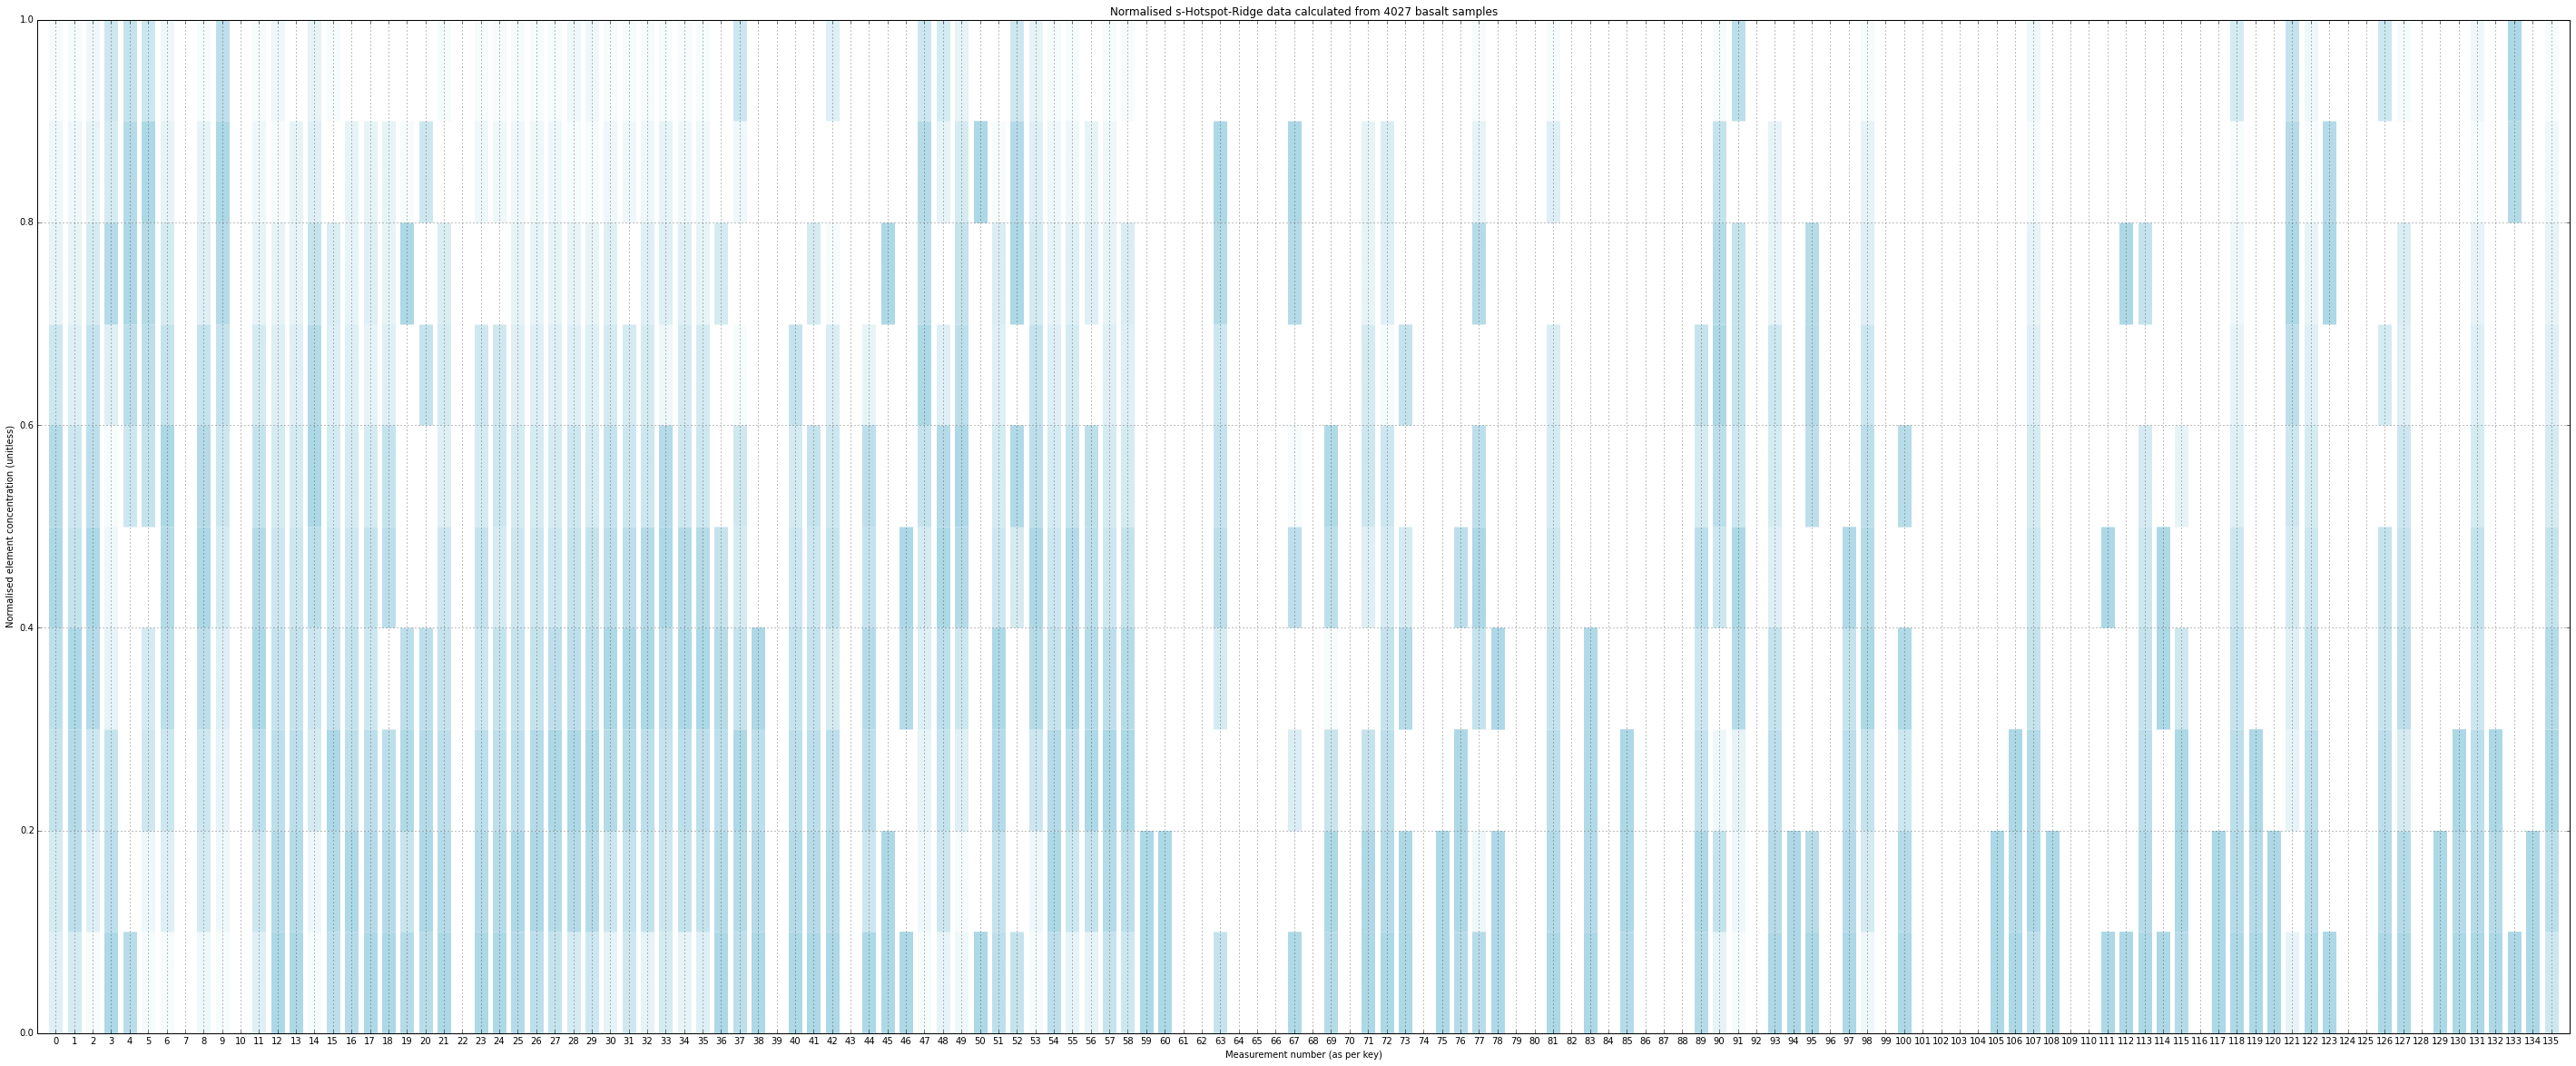

s-Basin-Range model built from 6144 data points containing 92 available measured data types.


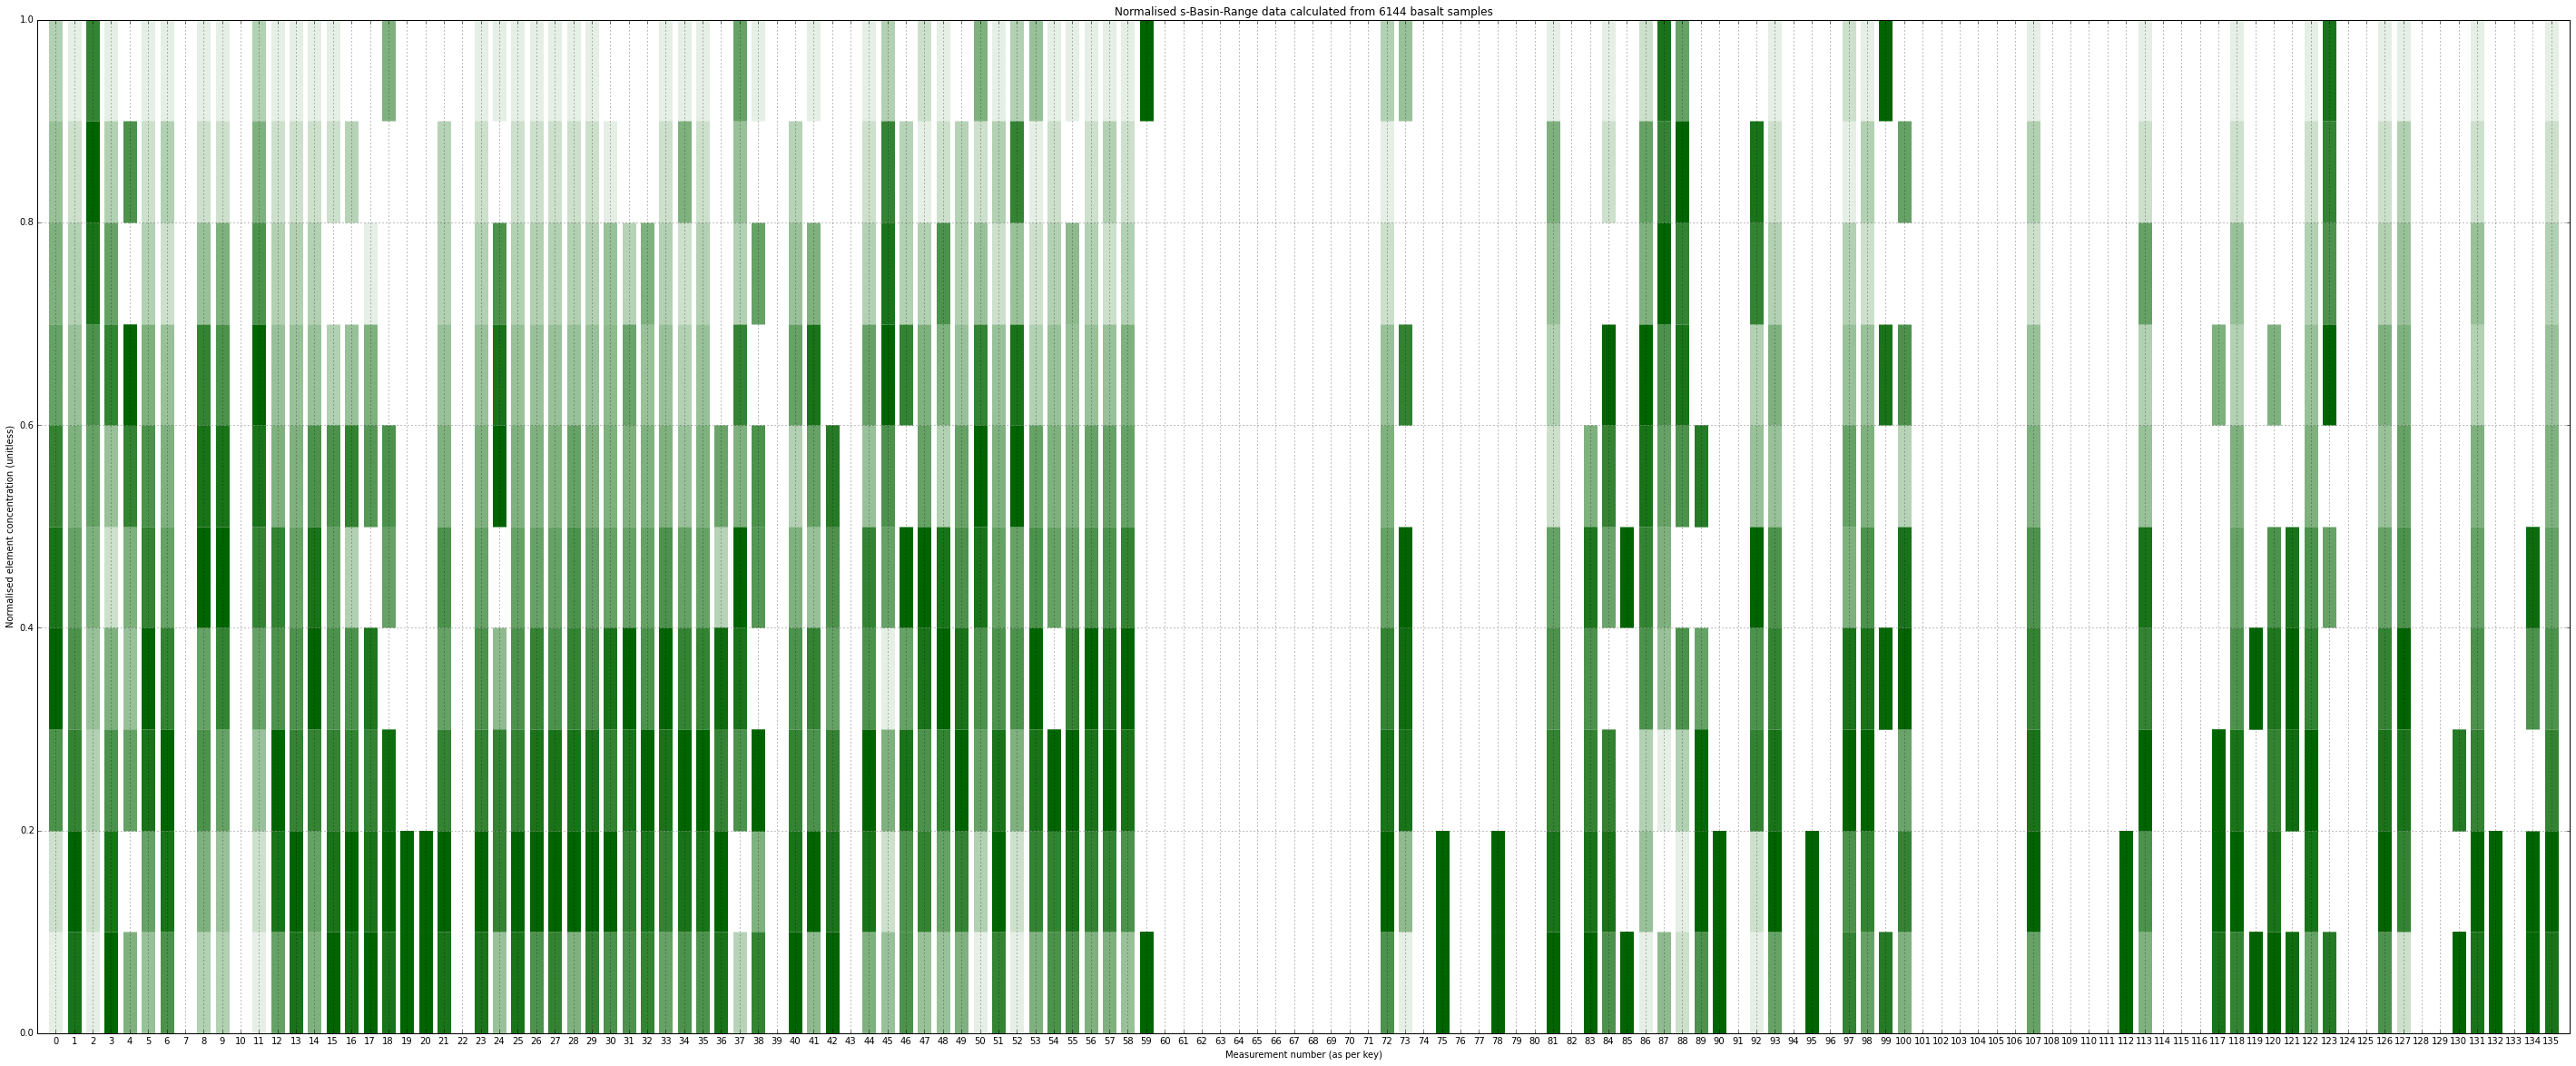

s-LIP model built from 1062 data points containing 76 available measured data types.


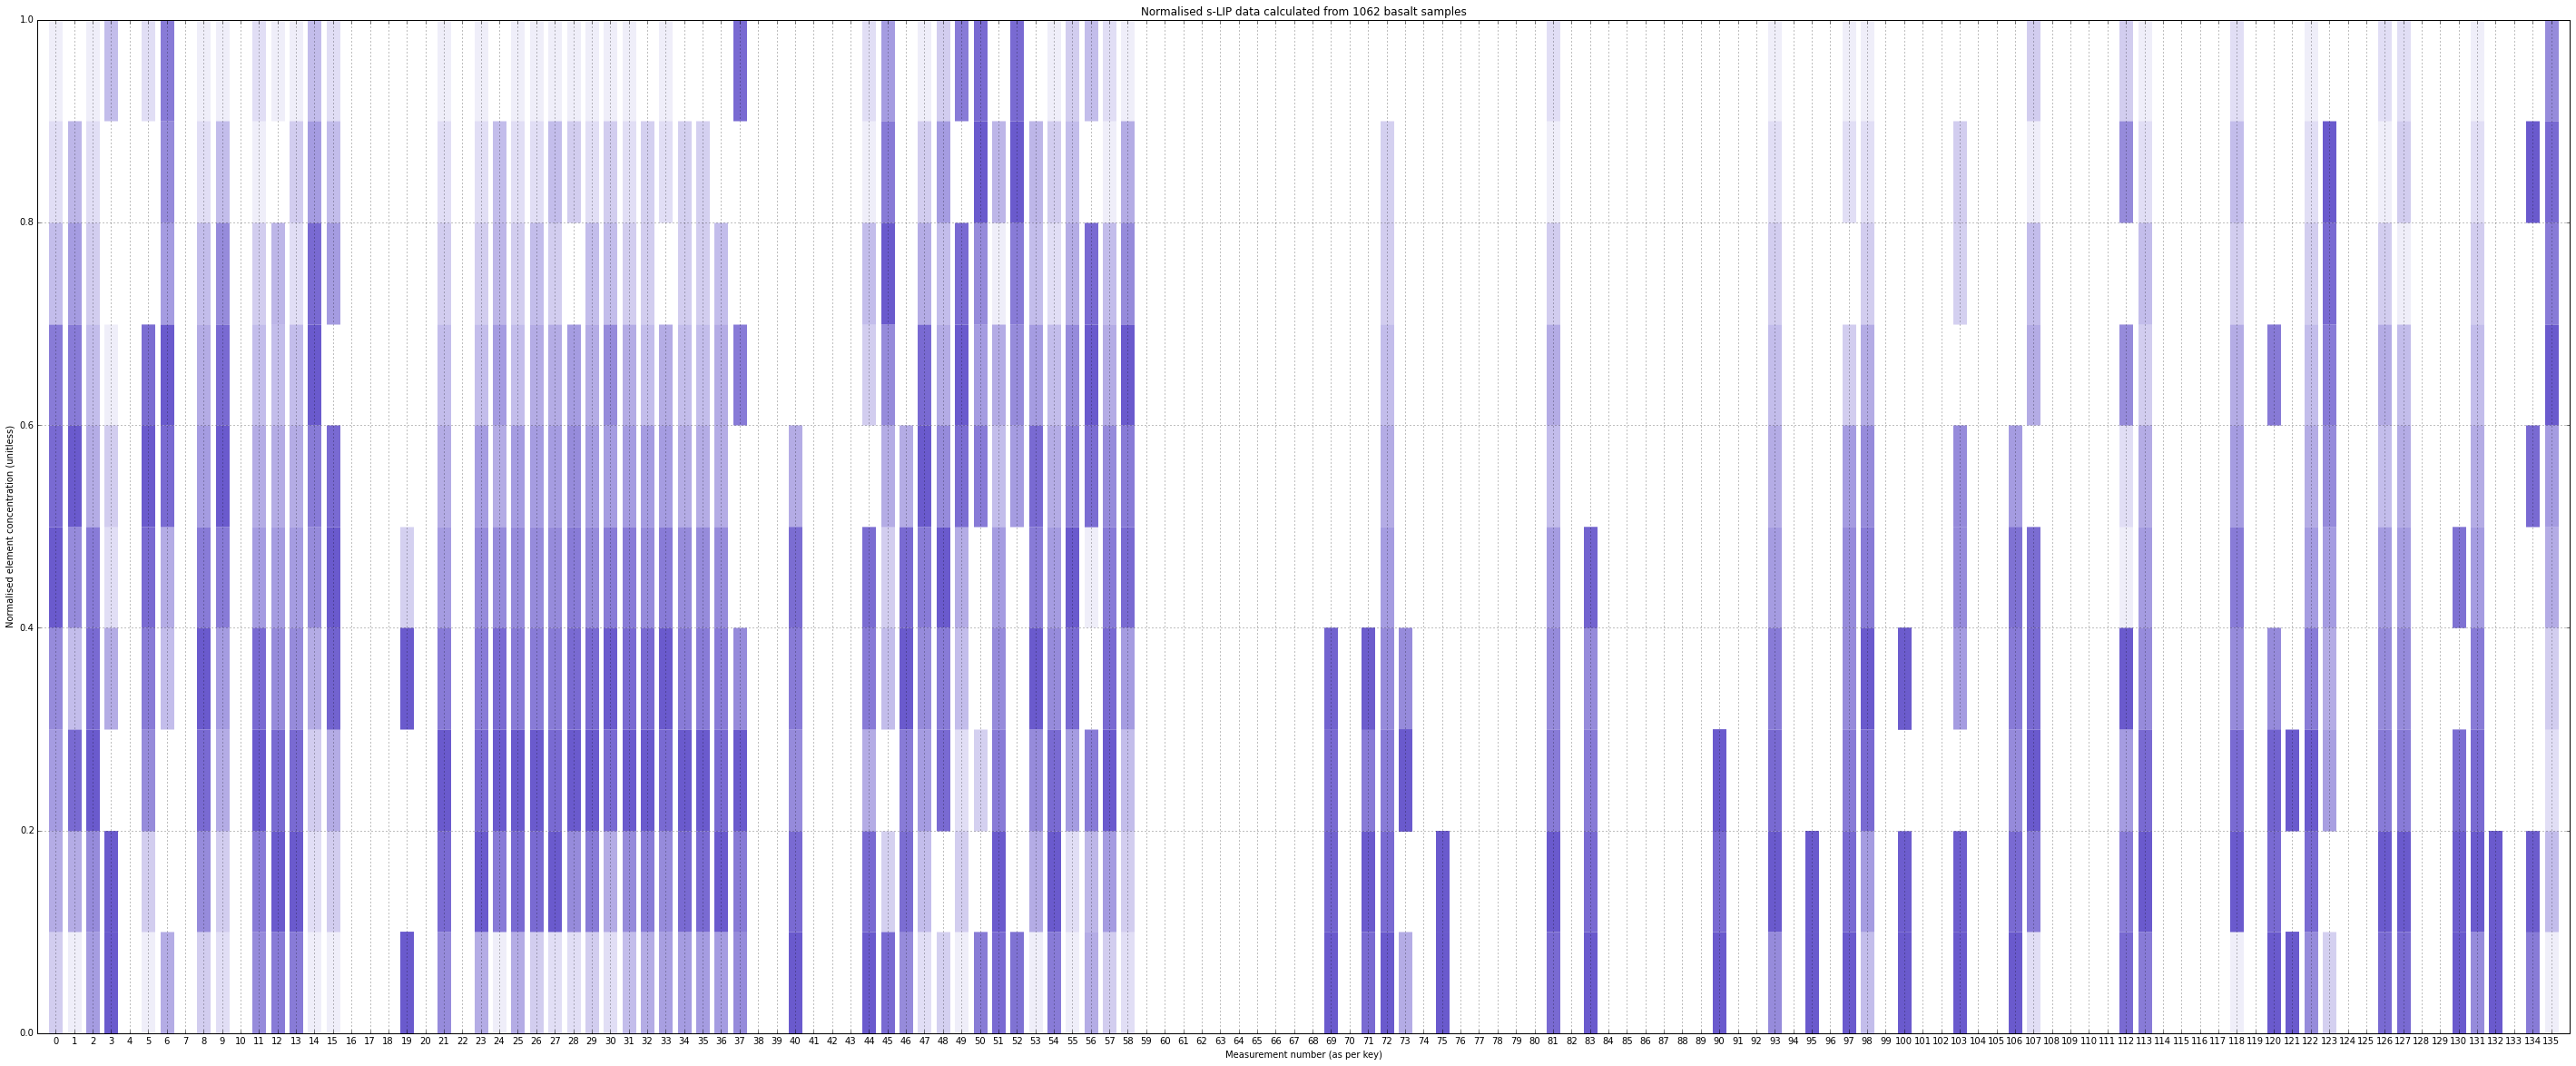

In [23]:
f_mor_classifier = []
f_subduction_classifier = []
f_hotspot_classifier = []

s_mor_classifier = []
s_arc_intraoceanic_classifier = []
s_arc_continental_classifier = []
s_arc_continental_aleutian_classifier = []
s_bab_classifier = []
s_rift_classifier = []
s_hotspot_classifier = []
s_hotspot_ridge_classifier = []
s_basin_range_classifier = []
s_lip_classifier = []


classifiers = [f_mor_classifier, f_subduction_classifier, f_hotspot_classifier, s_mor_classifier,
               s_arc_intraoceanic_classifier, s_arc_continental_classifier, s_arc_continental_aleutian_classifier,
               s_bab_classifier, s_rift_classifier, s_hotspot_classifier, s_hotspot_ridge_classifier,
               s_basin_range_classifier, s_lip_classifier]

alpha_ = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
color_ = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'purple', 'orange', 'gray', 'lightblue', 'darkgreen', 'slateblue']
names_ = labels
data_ = normalised_models

data_length = [f_mor_len, f_sub_len, f_hs_len, s_mor_len, s_ao_len, s_ac_len,
               s_aca_len, s_bab_len, s_rift_len, s_hs_len, s_hsr_len, s_bnr_len, s_lip_len]


for k in xrange(0, len(classifiers)):
    
    count = 0

    plt.figure(figsize=(50,20),dpi=150)

    for i in xrange(0, len(bin_max[k])):
        
        if bin_max[k][i] != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            
            count = count + 1
            
            for j in xrange(0, len(bin_max[k][0])):

                plt.plot([i, i], [bin_labels[bin_max[k][i][j]][1], bin_labels[bin_max[k][i][j]][0]], linewidth=15, 
                         solid_capstyle="butt", alpha=alpha_[j], color=color_[k])

                
                # Create classifier array: (if available) primary, secondary, tertiary value ranges for classification
                # [measurement number, score, value range low, value range high]
                
                classifiers[k].append([i, j + 1, bin_labels[bin_max[k][i][j]][0], bin_labels[bin_max[k][i][j]][1]])
                
        else:

            continue
            
    print names_[k], "model built from", data_length[k], "data points containing", count, "available measured data types."

    tmp_title = "Normalised " + names_[k] + " data calculated from " + str(data_length[k]) + " basalt samples"
    plt.title(tmp_title)
    plt.xlabel('Measurement number (as per key)')
    plt.ylabel('Normalised element concentration (unitless)')
    plt.xlim(-1, 136)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 136, 1))
    plt.grid()
    plt.show()

### Use classification models to identify basalts of unknown tectonic affinity and compare with plate model

#### Create vector for all unlabelled data from a desired time period

In [37]:
# Set low (more recent) and hi (older) ages for sampling
lowAge = 770
hiAge = 790


# Create vector for chemdata
vector_length = len(chemdata.columns.values)
full_chem_data_vector = []

data_count = 0

# Function to find any data point that contains zero measurement data (all nan)
def empty(items):
    
    return all(np.isnan(x) for x in items)


# Loop through EarthChem data and extract Basalts of desired criteria
for i in xrange(0, len(chemdata)):
       
    # Filter data by rock name
    if chemdata['ROCK NAME'][i] == "BASALT":

        # Filter data by age window
        if chemdata['AGE'][i] >= lowAge and chemdata['AGE'][i] <= hiAge:
            
            full_chem_data_vector.append([0] * vector_length)
            data_count = data_count + 1

            # Add all chem data to data point vector
            for j in xrange(0, vector_length):

                full_chem_data_vector[-1][j] = chemdata[chemdata.columns.values[j]][i]

            # Check to make sure actual chem data exists for data point (not metadata: labels etc)
            tmp_data = []
            for k in xrange(16, vector_length, 1):

                tmp_data.append(full_chem_data_vector[-1][k])

            # If no chem data found, remove data point from dataset
            if empty(tmp_data):

                del full_chem_data_vector[-1]
                    
print "Data range", lowAge, "-", hiAge, "Ma contains", str(len(full_chem_data_vector)), "points. Dropped", data_count - len(full_chem_data_vector), "\
points that do not contain any actual measurement data!"

Data range 770 - 790 Ma contains 471 points. Dropped 11 points that do not contain any actual measurement data!


#### Normalise data using feature scaling to tectonic setting fingerprint model data sets (0 - 5 Ma)

For an entire selected data range:

In [38]:
full_normalised_data = []
full_meta_data = []

for i in xrange(0, len(full_chem_data_vector)):
    
    # Extract sample meta-data
    full_meta_data.append({'Cruise_ID': full_chem_data_vector[i][4], 'Reference': full_chem_data_vector[i][3], 
                           'Sample_age': full_chem_data_vector[i][9], 'Site_lon': full_chem_data_vector[i][6], 
                           'Site_lat': full_chem_data_vector[i][5]})
    
    # Normalise measurement data
    pre_normalised_sample = []
    normalised_sample = []
    
    for j in xrange(16, len(full_chem_data_vector[i])):
        
        pre_normalised_sample.append(full_chem_data_vector[i][j])
        normalised_sample.append([])

    for k in xrange(0, len(pre_normalised_sample)):

        if np.isnan(pre_normalised_sample[k]) != True:

            normalised_sample[k].append( (pre_normalised_sample[k] - data_95[k][0]) / (data_95[k][1] - data_95[k][0]) )
            
    full_normalised_data.append(normalised_sample)

Calculate sample fit with all tectonic setting classification models

In [39]:
start_clock()

results_array = []

for ii in xrange(0, len(full_normalised_data)):
#for ii in xrange(0, 1):
    
    # Get true length of sample data (number of measurements present) + index 
    len_sample = len(full_normalised_data[ii])
    measurement_index = []
    
    for i in xrange(0, len(full_normalised_data[ii])):

        if not full_normalised_data[ii][i]:

            len_sample = len_sample - 1

        else:

            measurement_index.append(i)
            
    # Only use samples that have >= 4 attributes (less than 5 give spuirous answers as they 'match' everything!)
    if len(measurement_index) >= 4:
        
        # Add number of measurements to meta_data array
        full_meta_data[ii]['Measurements'] = len(measurement_index)


        # Assign sample plate ID and reconstruct to birth age
        if full_meta_data[ii]['Cruise_ID'] == 'HELIOS' or full_meta_data[ii]['Cruise_ID'] == 'POLYNAUT':

            full_meta_data[ii]['Site_lon'] = np.abs(full_meta_data[ii]['Site_lon'])


        inputlatLon = pgp.LatLonPoint(full_meta_data[ii]['Site_lat'], full_meta_data[ii]['Site_lon'])
        latLonPoint = pgp.convert_lat_lon_point_to_point_on_sphere(inputlatLon)


        # Assign correct rotation file and polygon set based on age of data
        sample_plateID = 0

        if full_meta_data[ii]['Sample_age'] <= 250:

            rotation_model = rotation_model_250_0

            for feature in polygons_410_0:

                for geometry in feature.get_geometries():

                    polygon = pgp.PolygonOnSphere(geometry)
                    isPoly = polygon.is_point_in_polygon(latLonPoint)

                    if isPoly == True:

                        sample_plateID = feature.get_reconstruction_plate_id()
                        break

                    else:

                        continue


        elif full_meta_data[ii]['Sample_age'] >= 251 and full_meta_data[ii]['Sample_age'] <= 410:

            rotation_model = rotation_model_410_251

            for feature in polygons_410_0:

                for geometry in feature.get_geometries():

                    polygon = pgp.PolygonOnSphere(geometry)
                    isPoly = polygon.is_point_in_polygon(latLonPoint)

                    if isPoly == True:

                        sample_plateID = feature.get_reconstruction_plate_id()
                        break

                    else:

                        continue


        elif full_meta_data[ii]['Sample_age'] >= 411 and full_meta_data[ii]['Sample_age'] <= 520:

            rotation_model = rotation_model_540_411

            for feature in polygons_540_411:

                for geometry in feature.get_geometries():

                    polygon = pgp.PolygonOnSphere(geometry)
                    isPoly = polygon.is_point_in_polygon(latLonPoint)

                    if isPoly == True:

                        sample_plateID = feature.get_reconstruction_plate_id()
                        break

                    else:

                        continue


        elif full_meta_data[ii]['Sample_age'] >= 521 and full_meta_data[ii]['Sample_age'] <= 1100:

            rotation_model = rotation_model_1100_541

            for feature in polygons_1100_541:

                for geometry in feature.get_geometries():

                    polygon = pgp.PolygonOnSphere(geometry)
                    isPoly = polygon.is_point_in_polygon(latLonPoint)

                    if isPoly == True:

                        sample_plateID = feature.get_reconstruction_plate_id()
                        break

                    else:

                        continue


        # Get rotation for data point and reconstruct back to birth age
        # (to_time, moving_plate_id, from_time)

        if sample_plateID != 0:

            point_rotation = rotation_model.get_rotation(np.double(full_meta_data[ii]['Sample_age']), sample_plateID, 0.)
            reconstructed_point = point_rotation * latLonPoint
            reconstructed_point_degrees = pgp.convert_point_on_sphere_to_lat_lon_point(reconstructed_point)

            reconstructed_sample_lon = reconstructed_point_degrees.get_longitude()
            reconstructed_sample_lat = reconstructed_point_degrees.get_latitude()

            # Add reconstructed data to meta_data array
            full_meta_data[ii]['Site_lon_reconstructed'] = round(reconstructed_sample_lon, 2)
            full_meta_data[ii]['Site_lat_reconstructed'] = round(reconstructed_sample_lat, 2)
            full_meta_data[ii]['plateID'] = sample_plateID

        else:

            # Add reconstructed data to meta_data array
            full_meta_data[ii]['Site_lon_reconstructed'] = "Not known"
            full_meta_data[ii]['Site_lat_reconstructed'] = "Not known"
            full_meta_data[ii]['plateID'] = "Not known"


        # Score array contains results in same order as classifiers array:
        # [f_mor_classifier, f_subduction_classifier, f_hotspot_classifier, s_mor_classifier,
        #  s_arc_intraoceanic_classifier, s_arc_continental_classifier, s_arc_continental_aleutian_classifier,
        #  s_bab_classifier, s_rift_classifier, s_hotspot_classifier, s_hotspot_ridge_classifier]


        f_mor_score = []
        f_subduction_score = []
        f_hotspot_score = []

        s_mor_score = []
        s_arc_intraoceanic_score = []
        s_arc_continental_score = []
        s_arc_continental_aleutian_score = []
        s_bab_score = []
        s_rift_score = []
        s_hotspot_score = []
        s_hotspot_ridge_score = []
        s_basin_range_score = []
        s_lip_score = []

        score = [f_mor_score, f_subduction_score, f_hotspot_score, s_mor_score, s_arc_intraoceanic_score, s_arc_continental_score, 
                 s_arc_continental_aleutian_score, s_bab_score, s_rift_score, s_hotspot_score, s_hotspot_ridge_score,
                 s_basin_range_score, s_lip_score]


        f_mor_pscore = []
        f_subduction_pscore = []
        f_hotspot_pscore = []

        s_mor_pscore = []
        s_arc_intraoceanic_pscore = []
        s_arc_continental_pscore = []
        s_arc_continental_aleutian_pscore = []
        s_bab_pscore = []
        s_rift_pscore = []
        s_hotspot_pscore = []
        s_hotspot_ridge_pscore = []
        s_basin_range_pscore = []
        s_lip_pscore = []

        p_score = [f_mor_pscore, f_subduction_pscore, f_hotspot_pscore, s_mor_pscore, s_arc_intraoceanic_pscore, 
                   s_arc_continental_pscore, s_arc_continental_aleutian_pscore, s_bab_pscore, s_rift_pscore, 
                   s_hotspot_pscore, s_hotspot_ridge_pscore, s_basin_range_pscore, s_lip_pscore]

        d_num = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        nd_num = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


        # Calculate score
        for i in xrange(0, len(score)):

            for j in xrange(0, len_sample):

                for k in xrange(0, len(classifiers[i])):

                    if classifiers[i][k][0] == measurement_index[j]:

                        if full_normalised_data[ii][measurement_index[j]][0] > classifiers[i][k][2] and \
                           full_normalised_data[ii][measurement_index[j]][0] < classifiers[i][k][3]:


                            # Scale percentage fit 
                            if weighting[i][measurement_index[j]] == 1:

                                score[i].append(classifiers[i][k][1] * scaling[i][0])
                                p_score[i].append(10 * scaling[i][0])
                                d_num[i] = d_num[i] + 1
                                break

                            elif weighting[i][measurement_index[j]] == 0:

                                score[i].append(classifiers[i][k][1] * scaling[i][1])
                                p_score[i].append(10 * scaling[i][1])
                                nd_num[i] = nd_num[i] + 1
                                break


                              # Unscaled percentage fit 
    #                         score[i].append(classifiers[i][k][1])
    #                         p_score[i].append(10)
    #                         break

        possible_score = [np.sum(p_score[0]), np.sum(p_score[1]), np.sum(p_score[2]), np.sum(p_score[3]),
                          np.sum(p_score[4]), np.sum(p_score[5]), np.sum(p_score[6]), np.sum(p_score[7]),
                          np.sum(p_score[8]), np.sum(p_score[9]), np.sum(p_score[10]), np.sum(p_score[11]),
                          np.sum(p_score[12])] 


        for i in xrange(0, len(score)):

            if score[i] == []:

                score[i] = [0]




    #     # Unscaled possible score
    #     ps = 10 * len(measurement_index)
    #     possible_score = [ps] * 11




        # Calculate fits  
        f_mor_fit = round((np.sum(score[0]) / np.float(possible_score[0])) * 100, 2)     
        f_mor_confidence = round(((np.float(d_num[0]) / diagnostic_array[0] * 100) +
                                  (np.float(nd_num[0]) / ((len(classifiers[0]) / 10) - diagnostic_array[0]) * 100)) / 2, 2)

        f_subduction_fit = round((np.sum(score[1]) / np.float(possible_score[1])) * 100, 2)
        f_subduction_confidence = round(((np.float(d_num[1]) / diagnostic_array[1] * 100) +
                                         (np.float(nd_num[1]) / ((len(classifiers[1]) / 10) - diagnostic_array[1]) * 100)) / 2, 2)

        f_hotspot_fit = round((np.sum(score[2]) / np.float(possible_score[2])) * 100, 2)
        f_hotspot_confidence = round(((np.float(d_num[2]) / diagnostic_array[2] * 100) +
                                      (np.float(nd_num[2]) / ((len(classifiers[2]) / 10) - diagnostic_array[2]) * 100)) / 2, 2)



        s_mor_fit = round((np.sum(score[3]) / np.float(possible_score[3])) * 100, 2)
        s_mor_confidence = round(((np.float(d_num[3]) / diagnostic_array[3] * 100) +
                                  (np.float(nd_num[3]) / ((len(classifiers[3]) / 10) - diagnostic_array[3]) * 100)) / 2, 2)

        s_arc_intraoceanic_fit = round((np.sum(score[4]) / np.float(possible_score[4])) * 100, 2)
        s_arc_intraoceanic_confidence = round(((np.float(d_num[4]) / diagnostic_array[4] * 100) +
                                        (np.float(nd_num[4]) / ((len(classifiers[4]) / 10) - diagnostic_array[4]) * 100)) / 2, 2)

        s_arc_continental_fit = round((np.sum(score[5]) / np.float(possible_score[5])) * 100, 2)
        s_arc_continental_confidence = round(((np.float(d_num[5]) / diagnostic_array[5] * 100) +
                                       (np.float(nd_num[5]) / ((len(classifiers[5]) / 10) - diagnostic_array[5]) * 100)) / 2, 2)

        s_arc_aleutian_fit = round((np.sum(score[6]) / np.float(possible_score[6])) * 100, 2)
        s_arc_aleutian_confidence = round(((np.float(d_num[6]) / diagnostic_array[6] * 100) +
                                        (np.float(nd_num[6]) / ((len(classifiers[6]) / 10) - diagnostic_array[6]) * 100)) / 2, 2) 

        s_bab_fit = round((np.sum(score[7]) / np.float(possible_score[7])) * 100, 2)
        s_bab_confidence = round(((np.float(d_num[7]) / diagnostic_array[7] * 100) +
                                  (np.float(nd_num[7]) / ((len(classifiers[7]) / 10) - diagnostic_array[7]) * 100)) / 2, 2)

        s_rift_fit = round((np.sum(score[8]) / np.float(possible_score[8])) * 100, 2)
        s_rift_confidence = round(((np.float(d_num[8]) / diagnostic_array[8] * 100) +
                                   (np.float(nd_num[8]) / ((len(classifiers[8]) / 10) - diagnostic_array[8]) * 100)) / 2, 2)

        s_hotspot_fit = round((np.sum(score[9]) / np.float(possible_score[9])) * 100, 2)
        s_hotspot_confidence = round(((np.float(d_num[9]) / diagnostic_array[9] * 100) +
                                      (np.float(nd_num[9]) / ((len(classifiers[9]) / 10) - diagnostic_array[9]) * 100)) / 2, 2)

        s_hotspot_ridge_fit = round((np.sum(score[10]) / np.float(possible_score[10])) * 100, 2)
        s_hotspot_ridge_confidence = round(((np.float(d_num[10]) / diagnostic_array[10] * 100) +
                                    (np.float(nd_num[10]) / ((len(classifiers[10]) / 10) - diagnostic_array[10]) * 100)) / 2, 2)

        s_basin_range_fit = round((np.sum(score[11]) / np.float(possible_score[11])) * 100, 2)
        s_basin_range_confidence = round(((np.float(d_num[11]) / diagnostic_array[11] * 100) +
                                    (np.float(nd_num[11]) / ((len(classifiers[11]) / 10) - diagnostic_array[11]) * 100)) / 2, 2)

        s_lip_fit = round((np.sum(score[12]) / np.float(possible_score[12])) * 100, 2)
        s_lip_confidence = round(((np.float(d_num[12]) / diagnostic_array[12] * 100) +
                                    (np.float(nd_num[12]) / ((len(classifiers[12]) / 10) - diagnostic_array[12]) * 100)) / 2, 2)


        # Create arrays of fit results

        try:
            f_fits_array = [f_mor_fit, f_subduction_fit, f_hotspot_fit]
            s_fits_array = [s_mor_fit, s_arc_intraoceanic_fit, s_arc_continental_fit, s_arc_aleutian_fit, s_bab_fit, s_rift_fit, 
                            s_hotspot_fit, s_hotspot_ridge_fit, s_basin_range_fit, s_lip_fit]

            # Get top 3 fitting results
            f_fits_array_sorted = np.sort(f_fits_array)
            f_fits_array_sorted_reversed = f_fits_array_sorted[::-1]
            f_fits_array_top = [[np.where(f_fits_array == f_fits_array_sorted_reversed[0])[0][0], f_fits_array_sorted_reversed[0]], 
                              [np.where(f_fits_array == f_fits_array_sorted_reversed[1])[0][0], f_fits_array_sorted_reversed[1]], 
                              [np.where(f_fits_array == f_fits_array_sorted_reversed[2])[0][0], f_fits_array_sorted_reversed[2]]]

            s_fits_array_sorted = np.sort(s_fits_array)
            s_fits_array_sorted_reversed = s_fits_array_sorted[::-1]
            s_fits_array_top = [[np.where(s_fits_array == s_fits_array_sorted_reversed[0])[0][0], s_fits_array_sorted_reversed[0]], 
                              [np.where(s_fits_array == s_fits_array_sorted_reversed[1])[0][0], s_fits_array_sorted_reversed[1]], 
                              [np.where(s_fits_array == s_fits_array_sorted_reversed[2])[0][0], s_fits_array_sorted_reversed[2]],
                              [np.where(s_fits_array == s_fits_array_sorted_reversed[3])[0][0], s_fits_array_sorted_reversed[3]],
                              [np.where(s_fits_array == s_fits_array_sorted_reversed[4])[0][0], s_fits_array_sorted_reversed[4]]]


            # Create ararys of confidence results
            f_confidence_array = [f_mor_confidence, f_subduction_confidence, f_hotspot_confidence]
            s_confidence_array = [s_mor_confidence, s_arc_intraoceanic_confidence, s_arc_continental_confidence, 
                                  s_arc_aleutian_confidence, s_bab_confidence, s_rift_confidence, s_hotspot_confidence, 
                                  s_hotspot_ridge_confidence, s_basin_range_confidence, s_lip_confidence]

            # Get top 3 confidence results
            f_confidence_array_sorted = np.sort(f_confidence_array)
            f_confidence_array_sorted_reversed = f_confidence_array_sorted[::-1]
            f_confidence_array_top = [[np.where(f_confidence_array == f_confidence_array_sorted_reversed[0])[0][0], 
                                       f_confidence_array_sorted_reversed[0]], 
                                      [np.where(f_confidence_array == f_confidence_array_sorted_reversed[1])[0][0], 
                                       f_confidence_array_sorted_reversed[1]], 
                                      [np.where(f_confidence_array == f_confidence_array_sorted_reversed[2])[0][0], 
                                       f_confidence_array_sorted_reversed[2]]]
                                      

            s_confidence_array_sorted = np.sort(s_confidence_array)
            s_confidence_array_sorted_reversed = s_confidence_array_sorted[::-1]
            s_confidence_array_top = [[np.where(s_confidence_array == s_confidence_array_sorted_reversed[0])[0][0], 
                                       s_confidence_array_sorted_reversed[0]], 
                                      [np.where(s_confidence_array == s_confidence_array_sorted_reversed[1])[0][0], 
                                       s_confidence_array_sorted_reversed[1]], 
                                      [np.where(s_confidence_array == s_confidence_array_sorted_reversed[2])[0][0], 
                                       s_confidence_array_sorted_reversed[2]]]
        except:
            pass



        # Add sample results to master results array
        results_array.append([full_meta_data[ii], f_fits_array, s_fits_array, f_confidence_array, s_confidence_array,
                              f_fits_array_top, s_fits_array_top, f_confidence_array_top, s_confidence_array_top])


stop_clock()

Process took 0 hour(s), 0 minute(s), 16.7064 second(s)


#### Print out results for random sample taken from processed dataset above

In [40]:
# Select random sample from processed data
r_num = random.sample(range(0, len(results_array)), 1)[0]

# Print out fits / confidence arrays  
print results_array[r_num][0]

print " "
print 'f-fits', results_array[r_num][5]
for i in xrange(0, len(results_array[r_num][5])):
    
    print 'f_fit', i, labels[results_array[r_num][5][i][0]]

print " "
print 's-fits', results_array[r_num][6]
for i in xrange(0, len(results_array[r_num][6])):
    
    print 's_fit', i, labels[results_array[r_num][6][i][0] + 3]

print " "
print 'f_confidence', results_array[r_num][7]
for i in xrange(0, len(results_array[r_num][7])):
    
    print 'f_confidence', i, labels[results_array[r_num][7][i][0]]
    
print " "
print 's_confidence', results_array[r_num][8]
for i in xrange(0, len(results_array[r_num][8])):
    
    print 's_confidence', i, labels[results_array[r_num][8][i][0] + 3]
    
         
print " "
print " "
print "Tectonic Setting                              %fit  / %confidence"
print " "
print "1st Order    Mid-ocean Ridge                 ", "%.2f" % results_array[r_num][1][0], "/", "%.2f" % results_array[r_num][3][0]
print "1st Order    Subduction                      ", "%.2f" % results_array[r_num][1][1], "/", "%.2f" % results_array[r_num][3][1]
print "1st Order    Hotspot                         ", "%.2f" % results_array[r_num][1][2], "/", "%.2f" % results_array[r_num][3][2]
    
print " "

print "2nd Order    Mid-ocean Ridge                 ", "%.2f" % results_array[r_num][2][0], "/", "%.2f" % results_array[r_num][4][0]   
print "2nd Order    Arc Intraoceanic                ", "%.2f" % results_array[r_num][2][1], "/", "%.2f" % results_array[r_num][4][1]
print "2nd Order    Arc Continental                 ", "%.2f" % results_array[r_num][2][2], "/", "%.2f" % results_array[r_num][4][2]
print "2nd Order    Arc Aleutian                    ", "%.2f" % results_array[r_num][2][3], "/", "%.2f" % results_array[r_num][4][3]
print "2nd Order    Basin and Range                 ", "%.2f" % results_array[r_num][2][8], "/", "%.2f" % results_array[r_num][4][8]
print "2nd Order    Back-arc Basin                  ", "%.2f" % results_array[r_num][2][4], "/", "%.2f" % results_array[r_num][4][4]
print "2nd Order    Rift Zone                       ", "%.2f" % results_array[r_num][2][5], "/", "%.2f" % results_array[r_num][4][5]
print "2nd Order    Hotspot                         ", "%.2f" % results_array[r_num][2][6], "/", "%.2f" % results_array[r_num][4][6]
print "2nd Order    Hotspot Ridge                   ", "%.2f" % results_array[r_num][2][7], "/", "%.2f" % results_array[r_num][4][7]
print "2nd Order    Hotspot Continental (LIP)       ", "%.2f" % results_array[r_num][2][9], "/", "%.2f" % results_array[r_num][4][9]


print " "
print "-------------------"
print  " "

{'Sample_age': 771.0, 'Site_lon': 87.799999999999997, 'Reference': 'UTSUNOMIYA A.; JAHN B.-M.; OTA T.; SAFONOVA I. YU., 2009', 'Site_lat_reconstructed': 29.99, 'Cruise_ID': 'NOTOVE', 'Measurements': 55, 'plateID': 4001, 'Site_lon_reconstructed': 115.15, 'Site_lat': 50.229999999999997}
 
f-fits [[0, 83.140000000000001], [2, 77.329999999999998], [1, 76.0]]
f_fit 0 f-MOR
f_fit 1 f-Hotspot
f_fit 2 f-Subduction
 
s-fits [[0, 82.189999999999998], [7, 81.849999999999994], [6, 78.409999999999997], [9, 78.200000000000003], [1, 76.849999999999994]]
s_fit 0 s-MOR
s_fit 1 s-Hotspot-Ridge
s_fit 2 s-Hotspot
s_fit 3 s-LIP
s_fit 4 s-Arc-Intraoceanic
 
f_confidence [[0, 52.270000000000003], [1, 51.950000000000003], [2, 48.649999999999999]]
f_confidence 0 f-MOR
f_confidence 1 f-Subduction
f_confidence 2 f-Hotspot
 
s_confidence [[9, 63.299999999999997], [1, 61.109999999999999], [2, 60.729999999999997]]
s_confidence 0 s-LIP
s_confidence 1 s-Arc-Intraoceanic
s_confidence 2 s-Arc-Continental
 
 
Tectonic S

#### Save sample setting predictions to file

In [41]:
# Create DataFrame of results data
resultsDF = pd.DataFrame(results_array)

# Save location
save_path = '/Users/Mike/Projects/tectonic_classifications/Paper/Analysis/Fingerprint_data/'

# Save DataFrame as pickle file
resultsDF.to_pickle(save_path + "basalt_fingerprinting_" + str(lowAge) + "-" + str(hiAge) + "_Ma.pkl")


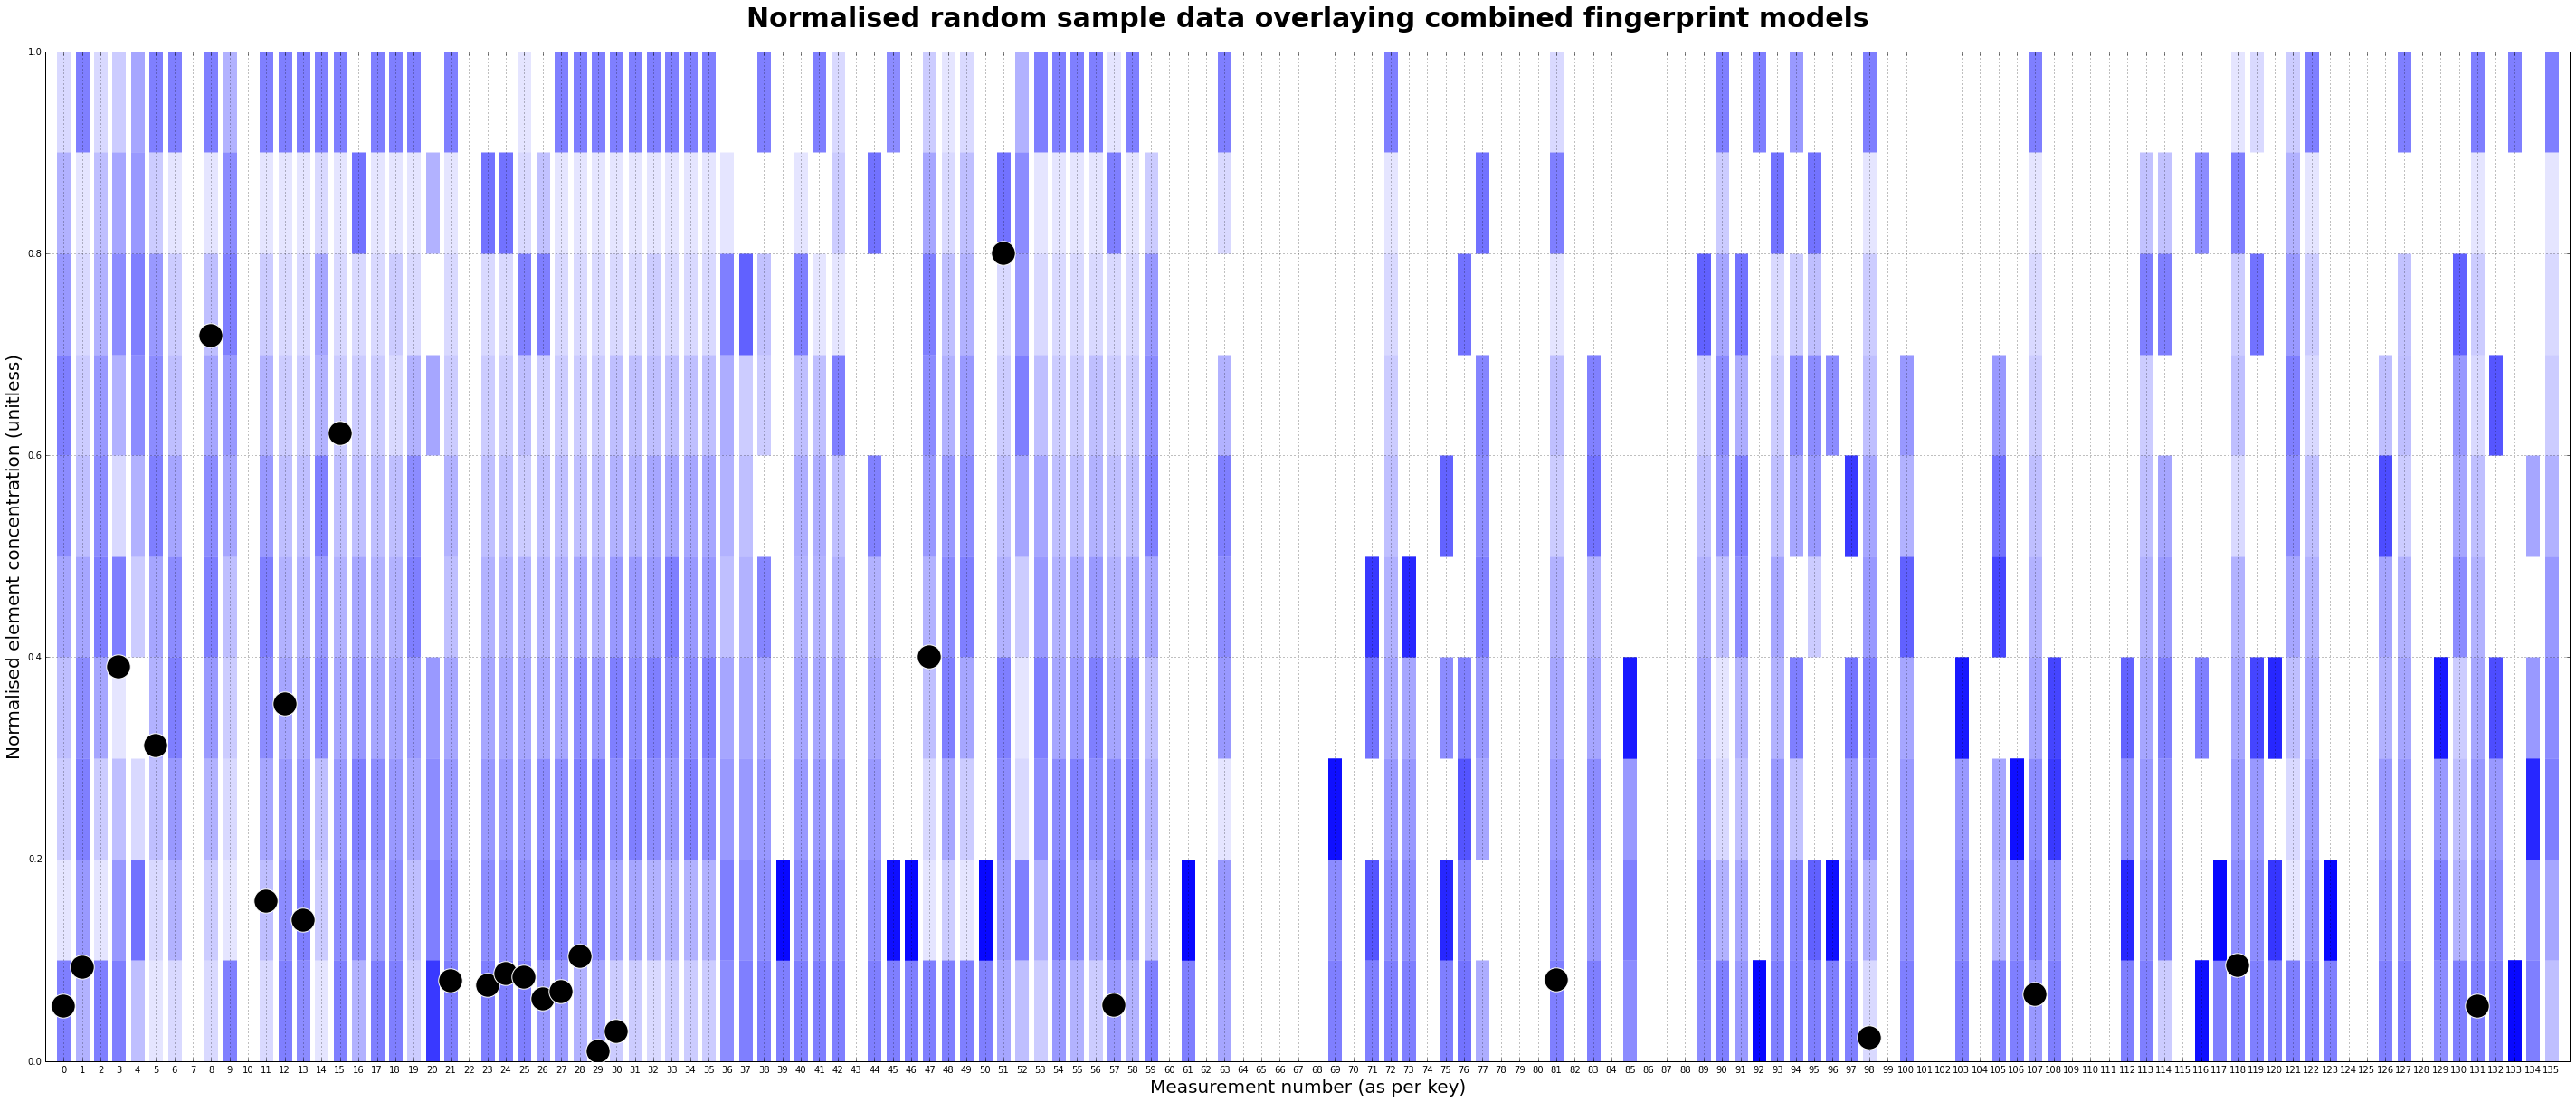

NameError: name 'rand_sample' is not defined

In [265]:
# Plotting results

alpha_ = [0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
color_ = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'purple', 'orange', 'gray', 'lightblue', 'darkgreen', 'pink', 'slateblue']

plt.figure(figsize=(50,20),dpi=150)

# for k in xrange(0, len(classifiers)):
for k in xrange(0, 1):
    
    count = 0

    for i in xrange(0, len(bin_max[k])):
        
        if bin_max[k][i] != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
            
            count = count + 1
            
            for j in xrange(0, len(bin_max[k][0])):

                plt.plot([i, i], [bin_labels[bin_max[k][i][j]][1], bin_labels[bin_max[k][i][j]][0]], linewidth=15, 
                         solid_capstyle="butt", alpha=alpha_[j], color=color_[k])

        else:

            continue
            
for i in xrange(0, len(measurement_index)):
    
    plt.scatter(measurement_index[i], normalised_sample[measurement_index[i]], s=700, color='k',
             edgecolor='w', zorder=1000)
            
tmp_title = "Normalised random sample data overlaying combined fingerprint models"
plt.title(tmp_title, fontsize=30, y=1.02, weight='bold')
plt.xlabel('Measurement number (as per key)', fontsize=20, y=0.97)
plt.ylabel('Normalised element concentration (unitless)', fontsize=20, x=0.97)
plt.xlim(-1, 136)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 136, 1))
plt.grid()
plt.show()

# Plot sample on reconstructed topologies
#topology_age = int(round(rand_sample[9], 0))

print " "    
try:
    plot_global_data(reconstructed_sample_lon, reconstructed_sample_lat, 
                     'Random sample reconstructed palaeo-position + reconstructed plate boundaries at ' + str(topology_age) \
                      + 'Ma.', 0, 1, 50, None, False, 
                     gpml_path + 'topology_platepolygons_' + str(topology_age) + '_00Ma', 
                     gpml_path + 'topology_subduction_boundaries_' + str(topology_age) + '_00Ma',
                     gpml_path + 'topology_mid_ocean_ridges_' + str(topology_age) + '_00Ma',
                     hotspot_path + 'JW_HotspotCatalogue_20140605',
                     gpml_path + 'topology_platepolygons_' + str(topology_age - 2) + '_00Ma',
                     gpml_path + 'topology_platepolygons_' + str(topology_age + 2) + '_00Ma',
                     gpml_path + 'topology_subduction_boundaries_' + str(topology_age - 2) + '_00Ma',
                     gpml_path + 'topology_subduction_boundaries_' + str(topology_age + 2) + '_00Ma',
                     gpml_path + 'topology_mid_ocean_ridges_' + str(topology_age - 2) + '_00Ma',
                     gpml_path + 'topology_mid_ocean_ridges_' + str(topology_age + 2) + '_00Ma')
except:
    pass


print " "    
plot_global_data(rand_sample[6], rand_sample[5], 'Random sample at present day + present day plate boundaries', \
                 0, 1, 50, None, True, 
                 gpml_path + 'topology_platepolygons_0_00Ma', 
                 gpml_path + 'topology_subduction_boundaries_0_00Ma',
                 gpml_path + 'topology_mid_ocean_ridges_0_00Ma',
                 hotspot_path + 'JW_HotspotCatalogue_20140605')

print " "
print "GREEN:   Mid-ocean ridges"
print "RED:     Subduction zones"
print "ORANGE:  Fixed hotspots"
print "GREY:    Plate boundaries"
print " "
print " "


# Plot fit vs confidence plot 
x_array = np.arange(1, len(labels) + 1, 1)

fig, ax1 = plt.subplots(figsize=(18,9),dpi=150)
ax1.plot(x_array, fits_array)
ax1.set_ylabel('% Fit', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
plt.grid()

ax2 = ax1.twinx()
ax2.set_ylabel('% Confidence', color='r')
ax2.plot(x_array, confidence_array, color='r', linestyle='dashed')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

ax1.set_xlim(1, 11)
ax1.set_xticks(x_array)
ax1.set_xlabel('Model number')
plt.title('Sample tectonic setting model fit statistics')

#plt.grid()    
plt.show()
